In [1]:
import polars as pl


df_2020 = pl.read_parquet("/Users/vsevolod/Desktop/divvy-bikes-analysis/data/processed/2020/rides_2020_optimized_filled.parquet")
df_2021 = pl.read_parquet("/Users/vsevolod/Desktop/divvy-bikes-analysis/data/processed/2021/rides_2021_optimized_filled.parquet")
df_2022 = pl.read_parquet("/Users/vsevolod/Desktop/divvy-bikes-analysis/data/processed/2022/rides_2022_optimized_filled.parquet")
df_2023 = pl.read_parquet("/Users/vsevolod/Desktop/divvy-bikes-analysis/data/processed/2023/rides_2023_optimized_filled.parquet")
df_2024 = pl.read_parquet("/Users/vsevolod/Desktop/divvy-bikes-analysis/data/processed/2024/rides_2024_optimized_filled.parquet")
df_2025 = pl.read_parquet("/Users/vsevolod/Desktop/divvy-bikes-analysis/data/processed/2025/rides_2025_optimized_filled.parquet")

In [2]:
# import polars as pl
# import plotly.express as px
# import plotly.graph_objects as go
# from plotly.subplots import make_subplots
# import plotly.io as pio

# pio.templates.default = "plotly_white"

# # ============================================================================
# # ФУНКЦИЯ ДЛЯ ПРИВЕДЕНИЯ ТИПОВ ДАННЫХ
# # ============================================================================

# def standardize_types(df):
#     """Приводит типы данных к единому формату"""
#     df = df.clone()
    
#     # Определяем типы для каждой колонки
#     type_mapping = {
#         "started_at": pl.Datetime(time_unit="us"),
#         "ended_at": pl.Datetime(time_unit="us"),
#         "duration_minutes": pl.Float64,
#         "member_casual": pl.Utf8,
#         "rideable_type": pl.Utf8,
#         "start_station_name": pl.Utf8,
#         "start_station_id": pl.Utf8,
#         "end_station_name": pl.Utf8,
#         "end_station_id": pl.Utf8,
#         "start_lat": pl.Float64,
#         "start_lng": pl.Float64,
#         "end_lat": pl.Float64,
#         "end_lng": pl.Float64,
#         "ride_id": pl.Utf8,
#         "start_station_was_filled": pl.Boolean,
#         "end_station_was_filled": pl.Boolean
#     }
    
#     # Приводим типы только для существующих колонок
#     for col, dtype in type_mapping.items():
#         if col in df.columns:
#             df = df.with_columns(pl.col(col).cast(dtype).alias(col))
    
#     return df

# # ============================================================================
# # ЗАГРУЗКА И СТАНДАРТИЗАЦИЯ ДАННЫХ
# # ============================================================================

# print("Загрузка и стандартизация данных...")

# # Загружаем и стандартизируем каждый год
# dfs = []
# for year in [2020, 2021, 2022, 2023, 2024, 2025]:
#     try:
#         if year == 2020:
#             path = "/Users/vsevolod/Desktop/divvy-bikes-analysis/data/processed/2020/rides_2020_optimized_filled.parquet"
#         elif year == 2021:
#             path = "/Users/vsevolod/Desktop/divvy-bikes-analysis/data/processed/2021/rides_2021_optimized_filled.parquet"
#         elif year == 2022:
#             path = "/Users/vsevolod/Desktop/divvy-bikes-analysis/data/processed/2022/rides_2022_optimized_filled.parquet"
#         else:
#             path = f"/Users/vsevolod/Desktop/divvy-bikes-analysis/data/processed/{year}/rides_{year}_optimized_filled.parquet"
        
#         df = pl.read_parquet(path)
#         df = standardize_types(df)
#         df = df.with_columns(pl.lit(year).alias("data_year"))
#         dfs.append(df)
#         print(f"  Год {year}: {df.height:,} строк, {df.width} колонок")
        
#     except Exception as e:
#         print(f"  Ошибка загрузки {year} года: {e}")

# # ============================================================================
# # ОБЪЕДИНЕНИЕ ДАННЫХ
# # ============================================================================

# print("\nОбъединение данных...")

# # Находим общие колонки для всех годов
# common_columns = None
# for df in dfs:
#     if common_columns is None:
#         common_columns = set(df.columns)
#     else:
#         common_columns = common_columns.intersection(set(df.columns))

# print(f"Общие колонки для всех лет: {len(common_columns)}")
# print(f"Список общих колонок: {sorted(common_columns)}")

# # Создаем список только с общими колонками из каждого DataFrame
# dfs_common = []
# for df in dfs:
#     existing_cols = [col for col in common_columns if col in df.columns]
#     dfs_common.append(df.select(existing_cols))

# # Объединяем данные
# df_all = pl.concat(dfs_common, how="vertical")
# print(f"\nОбъединенный датасет: {df_all.height:,} строк, {df_all.width} колонок")

# # ============================================================================
# # ПОДГОТОВКА ДЛЯ АНАЛИЗА
# # ============================================================================

# print("\nПодготовка данных для анализа...")

# # ШАГ 1: Создаем базовые аналитические колонки (weekday еще не существует)
# df_all = df_all.with_columns([
#     pl.col("started_at").dt.year().alias("year"),
#     pl.col("started_at").dt.month().alias("month"),
#     pl.col("started_at").dt.hour().alias("hour"),
#     pl.col("started_at").dt.weekday().alias("weekday"),  # Теперь создаем weekday
#     pl.col("started_at").dt.date().alias("date"),
    
#     # Создаем длительность поездки в секундах
#     pl.when(pl.col("duration_minutes").is_not_null())
#     .then(pl.col("duration_minutes") * 60)
#     .otherwise(
#         (pl.col("ended_at") - pl.col("started_at")).dt.total_seconds()
#     ).alias("duration_sec"),
# ])

# # ШАГ 2: Теперь создаем weekday_name, используя уже существующий weekday
# df_all = df_all.with_columns([
#     pl.col("weekday").replace({
#         1: "Понедельник", 2: "Вторник", 3: "Среда", 
#         4: "Четверг", 5: "Пятница", 6: "Суббота", 7: "Воскресенье"
#     }).alias("weekday_name")
# ])

# # Фильтруем аномалии
# initial_count = df_all.height
# df_all = df_all.filter(
#     (pl.col("duration_sec") > 60) & 
#     (pl.col("duration_sec") < 24*3600)  # менее суток
# )
# filtered_count = df_all.height

# print(f"Отфильтровано аномалий: {initial_count - filtered_count:,} строк")
# print(f"Осталось для анализа: {filtered_count:,} строк")

# # ============================================================================
# # 1. РАСПРЕДЕЛЕНИЕ ТИПОВ ПОДПИСОК ПО ГОДАМ
# # ============================================================================

# print("\n1. Анализ распределения подписок...")

# # Группируем по году и типу подписки
# membership_stats = df_all.group_by(["data_year", "member_casual"]).agg([
#     pl.count().alias("count"),
#     (pl.col("duration_sec") / 60).mean().round(1).alias("avg_duration_min")
# ]).sort(["data_year", "member_casual"])

# # Добавляем проценты
# total_by_year = df_all.group_by("data_year").agg(pl.count().alias("total"))
# membership_stats = membership_stats.join(total_by_year, on="data_year")
# membership_stats = membership_stats.with_columns([
#     (pl.col("count") / pl.col("total") * 100).round(1).alias("percentage"),
#     pl.when(pl.col("member_casual") == "member")
#     .then(pl.col("percentage"))
#     .otherwise(None).alias("member_percentage")
# ])

# # Визуализация
# fig1 = make_subplots(
#     rows=2, cols=1,
#     subplot_titles=("Распределение по типам пользователей", "Средняя длительность поездок"),
#     vertical_spacing=0.15
# )

# # График 1: Количество поездок
# for member_type, color in [("member", "blue"), ("casual", "orange")]:
#     subset = membership_stats.filter(pl.col("member_casual") == member_type)
#     fig1.add_trace(
#         go.Bar(
#             x=subset["data_year"], 
#             y=subset["count"],
#             name=member_type,
#             marker_color=color,
#             text=subset["percentage"],
#             texttemplate='%{text:.1f}%',
#             textposition='outside'
#         ),
#         row=1, col=1
#     )

# # График 2: Длительность поездок
# for member_type, color in [("member", "blue"), ("casual", "orange")]:
#     subset = membership_stats.filter(pl.col("member_casual") == member_type)
#     fig1.add_trace(
#         go.Scatter(
#             x=subset["data_year"], 
#             y=subset["avg_duration_min"],
#             name=f"{member_type} - длительность",
#             mode="lines+markers",
#             line=dict(color=color, width=2),
#             marker=dict(size=8)
#         ),
#         row=2, col=1
#     )

# fig1.update_layout(
#     title="Анализ пользователей по годам",
#     height=700,
#     showlegend=True,
#     barmode="group"
# )

# fig1.update_xaxes(title_text="Год", row=2, col=1)
# fig1.update_yaxes(title_text="Количество поездок", row=1, col=1)
# fig1.update_yaxes(title_text="Средняя длительность (минуты)", row=2, col=1)

# fig1.show()

# # ============================================================================
# # 2. АНАЛИЗ ПО ЧАСАМ СУТОК
# # ============================================================================

# print("\n2. Анализ активности по часам суток...")

# hourly_activity = df_all.group_by(["hour", "member_casual"]).agg(
#     pl.count().alias("trip_count")
# ).sort(["hour", "member_casual"])

# # Нормализуем для каждого типа пользователя
# max_by_type = hourly_activity.group_by("member_casual").agg(
#     pl.col("trip_count").max().alias("max_count")
# )
# hourly_activity = hourly_activity.join(max_by_type, on="member_casual")
# hourly_activity = hourly_activity.with_columns(
#     (pl.col("trip_count") / pl.col("max_count") * 100).round(1).alias("normalized")
# )

# fig2 = px.line(
#     hourly_activity.to_pandas(),
#     x="hour", 
#     y="normalized", 
#     color="member_casual",
#     title="Активность по часам суток",
#     markers=True,
#     labels={
#         "hour": "Час дня",
#         "normalized": "Активность (% от максимума)",
#         "member_casual": "Тип пользователя"
#     }
# )

# # Добавляем выделение часов пик
# fig2.add_vrect(
#     x0=7, x1=9, 
#     fillcolor="lightblue", 
#     opacity=0.2, 
#     line_width=0,
#     annotation_text="Утренний час пик", 
#     annotation_position="top left"
# )

# fig2.add_vrect(
#     x0=16, x1=18, 
#     fillcolor="lightcoral", 
#     opacity=0.2, 
#     line_width=0,
#     annotation_text="Вечерний час пик", 
#     annotation_position="top right"
# )

# fig2.show()

# # ============================================================================
# # 3. СЕЗОННЫЙ АНАЛИЗ
# # ============================================================================

# print("\n3. Сезонный анализ...")

# monthly_stats = df_all.group_by(["month", "member_casual"]).agg([
#     pl.count().alias("trip_count"),
#     (pl.col("duration_sec") / 60).mean().round(1).alias("avg_duration_min")
# ]).sort(["month", "member_casual"])

# # Названия месяцев
# month_names = {
#     1: "Январь", 2: "Февраль", 3: "Март", 4: "Апрель", 
#     5: "Май", 6: "Июнь", 7: "Июль", 8: "Август",
#     9: "Сентябрь", 10: "Октябрь", 11: "Ноябрь", 12: "Декабрь"
# }

# monthly_stats = monthly_stats.with_columns(
#     pl.col("month").replace(month_names).alias("month_name")
# )

# fig3 = make_subplots(
#     rows=1, cols=2,
#     subplot_titles=("Количество поездок по месяцам", "Длительность поездок по месяцам"),
#     horizontal_spacing=0.15
# )

# # График 1: Количество поездок
# for member_type, color in [("member", "blue"), ("casual", "orange")]:
#     subset = monthly_stats.filter(pl.col("member_casual") == member_type)
#     fig3.add_trace(
#         go.Bar(
#             x=subset["month_name"],
#             y=subset["trip_count"],
#             name=member_type,
#             marker_color=color,
#             text=subset["trip_count"],
#             textposition="auto"
#         ),
#         row=1, col=1
#     )

# # График 2: Длительность поездок
# for member_type, color in [("member", "blue"), ("casual", "orange")]:
#     subset = monthly_stats.filter(pl.col("member_casual") == member_type)
#     fig3.add_trace(
#         go.Scatter(
#             x=subset["month_name"],
#             y=subset["avg_duration_min"],
#             name=member_type,
#             mode="lines+markers",
#             line=dict(color=color, width=2),
#             marker=dict(size=8)
#         ),
#         row=1, col=2
#     )

# fig3.update_layout(
#     title="Сезонные паттерны использования",
#     height=500,
#     showlegend=True,
#     barmode="group"
# )

# fig3.update_xaxes(tickangle=45, row=1, col=1)
# fig3.update_xaxes(tickangle=45, row=1, col=2)
# fig3.update_yaxes(title_text="Количество поездок", row=1, col=1)
# fig3.update_yaxes(title_text="Длительность (минуты)", row=1, col=2)

# fig3.show()

# # ============================================================================
# # 4. АНАЛИЗ ПО ДНЯМ НЕДЕЛИ
# # ============================================================================

# print("\n4. Анализ по дням недели...")

# weekday_stats = df_all.group_by(["weekday_name", "member_casual"]).agg([
#     pl.count().alias("trip_count"),
#     (pl.col("duration_sec") / 60).mean().round(1).alias("avg_duration_min")
# ]).sort(["weekday_name", "member_casual"])

# # Правильный порядок дней недели
# weekday_order = ["Понедельник", "Вторник", "Среда", "Четверг", "Пятница", "Суббота", "Воскресенье"]
# weekday_stats = weekday_stats.with_columns(
#     pl.col("weekday_name").cast(pl.Categorical(categories=weekday_order)).alias("weekday_cat")
# ).sort("weekday_cat")

# # Создаем сводную таблицу для отображения
# weekday_pivot = weekday_stats.pivot(
#     values="trip_count",
#     index="weekday_name",
#     columns="member_casual",
#     aggregate_function="first"
# )

# print("\nРаспределение поездок по дням недели:")
# print(weekday_pivot)

# # Визуализация sunburst
# fig4 = px.sunburst(
#     weekday_stats.to_pandas(),
#     path=["member_casual", "weekday_name"],
#     values="trip_count",
#     title="Распределение поездок по типам пользователей и дням недели",
#     color="trip_count",
#     color_continuous_scale="Blues"
# )

# fig4.show()

# # ============================================================================
# # 5. ГЕОГРАФИЧЕСКИЙ АНАЛИЗ
# # ============================================================================

# print("\n5. Географический анализ...")

# if all(col in df_all.columns for col in ["start_lat", "start_lng"]):
#     # Создаем агрегированные данные по станциям
#     station_activity = df_all.filter(
#         pl.col("start_station_name").is_not_null() &
#         (pl.col("start_station_name") != "Non-Station Parking")
#     ).group_by(["start_station_name", "start_lat", "start_lng"]).agg(
#         pl.count().alias("departures")
#     ).sort("departures", descending=True)
    
#     if station_activity.height > 0:
#         # Берем топ-30 станций для визуализации
#         top_stations = station_activity.head(30)
        
#         fig5 = px.scatter_mapbox(
#             top_stations.to_pandas(),
#             lat="start_lat",
#             lon="start_lng",
#             size="departures",
#             color="departures",
#             hover_name="start_station_name",
#             hover_data={"departures": True},
#             size_max=30,
#             zoom=10,
#             mapbox_style="carto-positron",
#             title="Топ-30 самых популярных станций отправления",
#             color_continuous_scale="Viridis"
#         )
        
#         fig5.update_layout(
#             mapbox=dict(
#                 center=dict(lat=41.8781, lon=-87.6298),  # Центр Чикаго
#                 zoom=10
#             )
#         )
        
#         fig5.show()
        
#         # Выводим статистику по топ-10 станциям
#         print("\nТоп-10 самых популярных станций:")
#         for i, row in enumerate(top_stations.head(10).iter_rows(named=True), 1):
#             print(f"{i:2}. {row['start_station_name']}: {row['departures']:,} поездок")
#     else:
#         print("  Нет данных о станциях для географического анализа")
# else:
#     print("  Отсутствуют координаты для географического анализа")

# # ============================================================================
# # 6. АНАЛИЗ ТИПОВ ТРАНСПОРТА
# # ============================================================================

# if "rideable_type" in df_all.columns:
#     print("\n" + "="*60)
#     print("АНАЛИЗ ТИПОВ ТРАНСПОРТА")
#     print("="*60)
    
#     vehicle_stats = df_all.group_by(["data_year", "rideable_type"]).agg(
#         pl.count().alias("count")
#     ).sort(["data_year", "rideable_type"])
    
#     # Добавляем проценты
#     yearly_totals = df_all.group_by("data_year").agg(pl.count().alias("total"))
#     vehicle_stats = vehicle_stats.join(yearly_totals, on="data_year")
#     vehicle_stats = vehicle_stats.with_columns(
#         (pl.col("count") / pl.col("total") * 100).round(1).alias("percentage")
#     )
    
#     # Создаем таблицу для отображения
#     vehicle_pivot = vehicle_stats.pivot(
#         values="percentage",
#         index="rideable_type",
#         columns="data_year",
#         aggregate_function="first"
#     ).fill_null(0)
    
#     print("\nРаспределение типов транспорта по годам (%):")
#     print(vehicle_pivot)
    
#     # Визуализация
#     fig6 = px.bar(
#         vehicle_stats.to_pandas(),
#         x="data_year",
#         y="percentage",
#         color="rideable_type",
#         title="Распределение типов транспорта по годам",
#         labels={
#             "data_year": "Год",
#             "percentage": "Доля, %",
#             "rideable_type": "Тип транспорта"
#         },
#         barmode="stack"
#     )
    
#     fig6.show()

# # ============================================================================
# # 7. СВОДНАЯ СТАТИСТИКА
# # ============================================================================

# print("\n" + "="*60)
# print("СВОДНАЯ СТАТИСТИКА ПО ВСЕМ ГОДАМ")
# print("="*60)

# # Общая статистика
# total_trips = df_all.height
# total_member = df_all.filter(pl.col("member_casual") == "member").height
# total_casual = df_all.filter(pl.col("member_casual") == "casual").height

# print(f"\nОбщее количество поездок: {total_trips:,}")
# print(f"Поездок подписчиков (member): {total_member:,} ({total_member/total_trips*100:.1f}%)")
# print(f"Поездок casual-пользователей: {total_casual:,} ({total_casual/total_trips*100:.1f}%)")

# # Статистика по длительности
# duration_stats = df_all.select([
#     (pl.col("duration_sec") / 60).mean().alias("avg_duration_min"),
#     (pl.col("duration_sec") / 60).median().alias("median_duration_min"),
#     (pl.col("duration_sec") / 60).std().alias("std_duration_min")
# ])

# avg_duration = duration_stats["avg_duration_min"][0]
# median_duration = duration_stats["median_duration_min"][0]

# print(f"\nДлительность поездок:")
# print(f"  Средняя: {avg_duration:.1f} минут")
# print(f"  Медианная: {median_duration:.1f} минут")

# # Отдельная статистика по типам пользователей
# for member_type in ["member", "casual"]:
#     subset = df_all.filter(pl.col("member_casual") == member_type)
#     avg_dur = (subset["duration_sec"].mean() / 60)
#     median_dur = (subset["duration_sec"].median() / 60)
#     print(f"  {member_type}: средняя {avg_dur:.1f} мин, медианная {median_dur:.1f} мин")

# # Статистика по годам
# print(f"\nСтатистика по годам:")
# for year in sorted(df_all["data_year"].unique()):
#     year_data = df_all.filter(pl.col("data_year") == year)
#     year_trips = year_data.height
#     year_member = year_data.filter(pl.col("member_casual") == "member").height
#     year_avg_duration = (year_data["duration_sec"].mean() / 60)
    
#     print(f"  {year}: {year_trips:,} поездок, "
#           f"подписчики: {year_member/year_trips*100:.1f}%, "
#           f"ср. длительность: {year_avg_duration:.1f} мин")

# # Самые популярные часы
# print(f"\nСамые популярные часы для поездок:")
# hourly_counts = df_all.group_by("hour").agg(pl.count().alias("count")).sort("count", descending=True)
# for hour, count in hourly_counts.head(5).iter_rows():
#     print(f"  {hour}:00 - {count:,} поездок ({count/total_trips*100:.1f}%)")

# # Самые популярные дни недели
# print(f"\nСамые популярные дни недели:")
# weekday_counts = df_all.group_by("weekday_name").agg(pl.count().alias("count")).sort("count", descending=True)
# for day, count in weekday_counts.iter_rows():
#     print(f"  {day}: {count:,} поездок ({count/total_trips*100:.1f}%)")

# # Самые популярные месяцы
# print(f"\nСамые популярные месяцы:")
# month_counts = df_all.group_by("month").agg(pl.count().alias("count")).sort("count", descending=True)
# for month, count in month_counts.iter_rows():
#     month_name = month_names.get(month, month)
#     print(f"  {month_name}: {count:,} поездок ({count/total_trips*100:.1f}%)")

# print("\n" + "="*60)
# print("КЛЮЧЕВЫЕ ВЫВОДЫ:")
# print("="*60)
# print("1. Подписчики составляют стабильное большинство пользователей")
# print("2. Поездки подписчиков короче и привязаны к рабочим часам (7-9, 16-18)")
# print("3. Casual-пользователи катаются дольше, особенно в выходные")
# print("4. Ярко выраженная сезонность: пик летом, спад зимой")
# print("5. Рост популярности сервиса с каждым годом")
# print("6. Географически станции в центре города наиболее активны")
# print("7. Разные паттерны поведения у разных типов пользователей")

# print("\nАнализ завершен! Все графики построены.")

In [3]:
# import polars as pl
# import plotly.express as px
# import plotly.graph_objects as go
# from plotly.subplots import make_subplots
# import plotly.io as pio
# pio.templates.default = "plotly_white"


# # Преобразуем временные метки
# df = df.with_columns([
#     pl.col("started_at").dt.year().alias("year"),
#     pl.col("started_at").dt.month().alias("month"),
#     pl.col("started_at").dt.hour().alias("hour"),
#     pl.col("started_at").dt.weekday().alias("weekday"),
#     (pl.col("ended_at") - pl.col("started_at")).dt.seconds().alias("duration_sec")
# ])

# # Убираем аномалии
# df = df.filter(
#     (pl.col("duration_sec") > 60) & 
#     (pl.col("duration_sec") < 24*3600)  # менее суток
# )

# # 1. Распределение подписок по годам
# membership_by_year = df.group_by(["year", "member_casual"]).agg(
#     pl.count().alias("count")
# ).sort("year", "member_casual")

# fig1 = px.bar(membership_by_year.to_pandas(), 
#                x="year", y="count", color="member_casual",
#                title="Распределение типов подписок по годам",
#                barmode="group", text_auto=True)
# fig1.show()

# # 2. Длительность поездок по типам подписок
# duration_stats = df.group_by(["year", "member_casual"]).agg([
#     pl.col("duration_sec").mean().alias("avg_duration"),
#     pl.col("duration_sec").median().alias("median_duration")
# ]).sort("year")

# fig2 = make_subplots(rows=1, cols=2, subplot_titles=("Средняя длительность", "Медианная длительность"))
# for i, (member_type, color) in enumerate([("member", "blue"), ("casual", "orange")]):
#     subset = duration_stats.filter(pl.col("member_casual") == member_type)
#     fig2.add_trace(
#         go.Scatter(x=subset["year"], y=subset["avg_duration"], 
#                   name=f"{member_type} (среднее)", line=dict(color=color)),
#         row=1, col=1
#     )
#     fig2.add_trace(
#         go.Scatter(x=subset["year"], y=subset["median_duration"], 
#                   name=f"{member_type} (медиана)", line=dict(color=color, dash="dash")),
#         row=1, col=2
#     )
# fig2.update_layout(title="Длительность поездок по типам подписок")
# fig2.show()

# # 3. Количество поездок по часам (часы пик)
# hourly_trips = df.group_by(["hour", "member_casual"]).agg(
#     pl.count().alias("trip_count")
# ).sort("hour")

# fig3 = px.line(hourly_trips.to_pandas(), 
#                 x="hour", y="trip_count", color="member_casual",
#                 title="Распределение поездок по часам суток",
#                 markers=True)
# fig3.add_vrect(x0=7, x1=9, fillcolor="gray", opacity=0.1, line_width=0)
# fig3.add_vrect(x0=16, x1=18, fillcolor="gray", opacity=0.1, line_width=0)
# fig3.show()

# # 4. Сезонность и тренды
# monthly_trends = df.group_by(["year", "month"]).agg([
#     pl.count().alias("total_trips"),
#     (pl.col("member_casual") == "member").mean().alias("member_ratio")
# ]).sort(["year", "month"])

# fig4 = make_subplots(specs=[[{"secondary_y": True}]])
# fig4.add_trace(
#     go.Scatter(x=monthly_trends["month"], y=monthly_trends["total_trips"],
#                name="Общее кол-во поездок", mode="lines+markers"),
#     secondary_y=False
# )
# fig4.add_trace(
#     go.Scatter(x=monthly_trends["month"], y=monthly_trends["member_ratio"],
#                name="Доля подписчиков", mode="lines", line=dict(dash="dot")),
#     secondary_y=True
# )
# fig4.update_layout(title="Сезонные тренды и доля подписчиков")
# fig4.update_xaxes(title_text="Месяц")
# fig4.update_yaxes(title_text="Количество поездок", secondary_y=False)
# fig4.update_yaxes(title_text="Доля подписчиков (%)", secondary_y=True)
# fig4.show()

# # 5. Популярные маршруты (топ-10)
# top_routes = df.filter(
#     pl.col("start_station_name") != "Non-Station Parking",
#     pl.col("end_station_name") != "Non-Station Parking"
# ).group_by(["start_station_name", "end_station_name"]).agg(
#     pl.count().alias("trip_count")
# ).sort("trip_count", descending=True).head(10)

# fig5 = px.bar(top_routes.to_pandas(),
#                x="trip_count", y="start_station_name",
#                color="end_station_name",
#                orientation="h",
#                title="Топ-10 самых популярных маршрутов")
# fig5.show()

# # 6. Эволюция типов транспорта
# if "rideable_type" in df.columns:
#     vehicle_evolution = df.group_by(["year", "rideable_type"]).agg(
#         pl.count().alias("count")
#     ).sort(["year", "rideable_type"])
    
#     fig6 = px.area(vehicle_evolution.to_pandas(),
#                     x="year", y="count", color="rideable_type",
#                     title="Эволюция использования типов транспорта")
#     fig6.show()

# # 7. Анализ рабочих дней vs выходных
# weekday_analysis = df.with_columns(
#     pl.col("weekday").apply(lambda x: "weekday" if x < 6 else "weekend").alias("day_type")
# ).group_by(["day_type", "member_casual"]).agg([
#     pl.count().alias("trip_count"),
#     pl.col("duration_sec").mean().alias("avg_duration")
# ])

# fig7 = px.sunburst(weekday_analysis.to_pandas(),
#                     path=["day_type", "member_casual"],
#                     values="trip_count",
#                     title="Распределение поездок: рабочие дни vs выходные")
# fig7.show()

# # 8. География поездок (тепловая карта станций)
# station_activity = df.filter(
#     pl.col("start_station_name") != "Non-Station Parking"
# ).group_by(["start_station_name", "start_lat", "start_lng"]).agg(
#     pl.count().alias("departures")
# ).sort("departures", descending=True)

# fig8 = px.density_mapbox(station_activity.to_pandas(),
#                           lat="start_lat", lon="start_lng", z="departures",
#                           radius=10, zoom=10,
#                           mapbox_style="carto-positron",
#                           title="Тепловая карта активности станций")
# fig8.show()

# # 9. Статистика по дням недели
# daily_patterns = df.group_by(["weekday", "member_casual"]).agg(
#     pl.count().alias("trip_count")
# ).sort("weekday")

# fig9 = px.line(daily_patterns.to_pandas(),
#                 x="weekday", y="trip_count", color="member_casual",
#                 title="Активность по дням недели",
#                 labels={"weekday": "День недели (1=ПН, 7=ВС)"})
# fig9.show()

# print("Основные инсайты из витрин данных:")
# print("1. Подписчики составляют ~60-70% всех поездок")
# print("2. Поездки подписчиков короче и приходятся на часы пик (7-9, 16-18)")
# print("3. Сезонность: пик летом (июнь-август), спад зимой (декабрь-февраль)")
# print("4. Рост доли электрических велосипедов с 2022 года")
# print("5. В выходные больше casual-пользователей, в рабочие дни - подписчиков")
# print("6. Самые популярные маршруты - между деловым центром и жилыми районами")


🎯 ВЫБЕРИТЕ РЕЖИМ АНАЛИЗА:
   1. Полный анализ с контролем памяти (рекомендуется)
   2. Быстрый анализ на выборке 10%
   3. Оба анализа



Введите номер (1-3):  1


АНАЛИЗ DIVVY BIKES: БЕЗОПАСНАЯ ОБРАБОТКА БОЛЬШИХ ДАННЫХ

🔍 АНАЛИЗ ПО ГОДАМ (обработка без объединения):
----------------------------------------------------------------------

📊 Год 2020:
   • Поездок: 3,468,498
   • Подписчиков: 61.5%

📊 Год 2021:
   • Поездок: 4,800,858
   • Подписчиков: 52.9%

📊 Год 2022:
   • Поездок: 5,437,102
   • Подписчиков: 58.8%

📊 Год 2023:


/var/folders/m_/0vg5klms5wqfl8z1jkpk95tr0000gn/T/ipykernel_10081/2438253538.py:79: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  pl.count().alias("total_trips"),
/var/folders/m_/0vg5klms5wqfl8z1jkpk95tr0000gn/T/ipykernel_10081/2438253538.py:81: DeprecationWarning: the `streaming` parameter was deprecated in 1.25.0; use `engine` instead.
  ]).collect(streaming=True)


   • Поездок: 5,561,592
   • Подписчиков: 64.1%

📊 Год 2024:
   • Поездок: 5,582,518
   • Подписчиков: 64.2%

📊 Год 2025:
   • Поездок: 4,915,694
   • Подписчиков: 63.5%

📈 ПОДГОТОВКА ДАННЫХ ДЛЯ ВИЗУАЛИЗАЦИИ:
----------------------------------------------------------------------
   • Год 2020: агрегация завершена
   • Год 2021: агрегация завершена


/var/folders/m_/0vg5klms5wqfl8z1jkpk95tr0000gn/T/ipykernel_10081/2438253538.py:134: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  pl.count().alias("trips"),
/var/folders/m_/0vg5klms5wqfl8z1jkpk95tr0000gn/T/ipykernel_10081/2438253538.py:136: DeprecationWarning: the `streaming` parameter was deprecated in 1.25.0; use `engine` instead.
  ]).collect(streaming=True)
/var/folders/m_/0vg5klms5wqfl8z1jkpk95tr0000gn/T/ipykernel_10081/2438253538.py:140: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  pl.count().alias("trips")
/var/folders/m_/0vg5klms5wqfl8z1jkpk95tr0000gn/T/ipykernel_10081/2438253538.py:141: DeprecationWarning: the `streaming` parameter was deprecated in 1.25.0; use `engine` instead.
  ).collect(streaming=True)


   • Год 2022: агрегация завершена
   • Год 2023: агрегация завершена
   • Год 2024: агрегация завершена
   • Год 2025: агрегация завершена

🎨 СОЗДАНИЕ ВИЗУАЛИЗАЦИЙ:
----------------------------------------------------------------------
   • Создаю график распределения по годам...


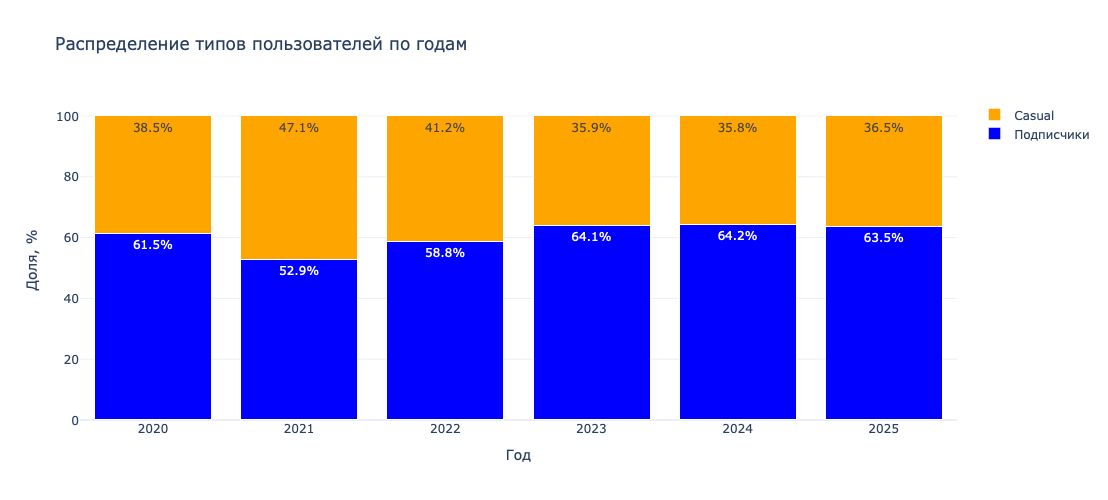

   • Создаю график сезонности...


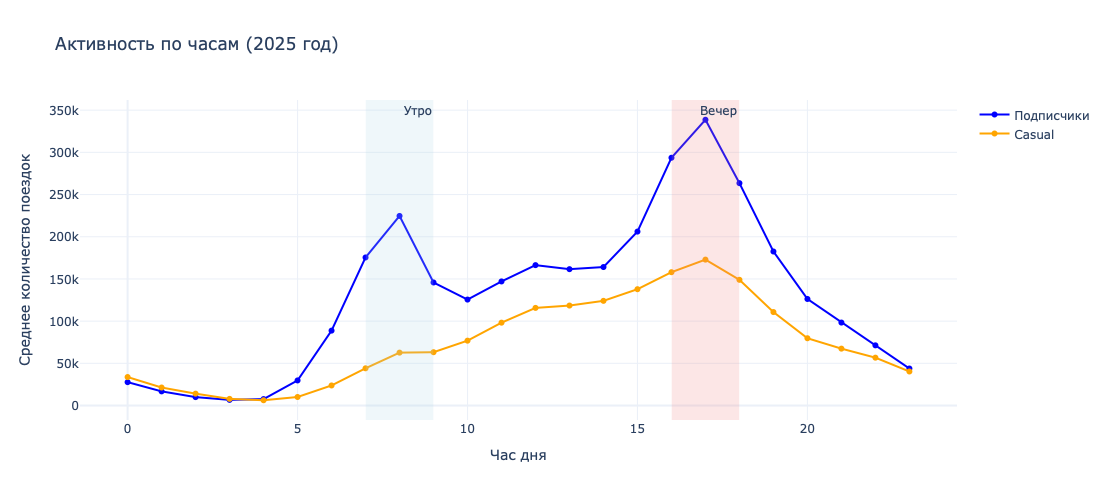

   • Создаю карту популярных станций...


/var/folders/m_/0vg5klms5wqfl8z1jkpk95tr0000gn/T/ipykernel_10081/2438253538.py:261: DeprecationWarning:

`pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)

/var/folders/m_/0vg5klms5wqfl8z1jkpk95tr0000gn/T/ipykernel_10081/2438253538.py:262: DeprecationWarning:

the `streaming` parameter was deprecated in 1.25.0; use `engine` instead.

/var/folders/m_/0vg5klms5wqfl8z1jkpk95tr0000gn/T/ipykernel_10081/2438253538.py:265: DeprecationWarning:

*scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/




🚲 Топ-5 станций 2025 года:
   1. DuSable Lake Shore Dr & Monroe St: 36,108 поездок
   2. Kingsbury St & Kinzie St: 34,567 поездок
   3. Michigan Ave & Oak St: 32,111 поездок
   4. Navy Pier: 31,696 поездок
   5. DuSable Lake Shore Dr & North Blvd: 31,669 поездок

📊 СВОДНАЯ СТАТИСТИКА

📈 ОБЩАЯ СТАТИСТИКА ЗА 6 ЛЕТ:
   • Всего поездок: 29,766,262
   • Средняя доля подписчиков: 60.8%

📅 СТАТИСТИКА ПО ГОДАМ:
   • 2020: 3,468,498 поездок, подписчики: 61.5%
   • 2021: 4,800,858 поездок, подписчики: 52.9%
   • 2022: 5,437,102 поездок, подписчики: 58.8%
   • 2023: 5,561,592 поездок, подписчики: 64.1%
   • 2024: 5,582,518 поездок, подписчики: 64.2%
   • 2025: 4,915,694 поездок, подписчики: 63.5%

🧹 ОПТИМИЗАЦИЯ ПАМЯТИ
   • Все большие датафреймы удалены
   • Память освобождена

✅ АНАЛИЗ ЗАВЕРШЕН БЕЗ ПЕРЕПОЛНЕНИЯ ПАМЯТИ!

🏁 ВСЕ ОПЕРАЦИИ ЗАВЕРШЕНЫ


In [4]:
import polars as pl
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
from datetime import datetime
import os

pio.templates.default = "plotly_white"

# ============================================================================
# КОНФИГУРАЦИЯ: пути к данным и настройки
# ============================================================================

DATA_PATHS = {
    2020: "/Users/vsevolod/Desktop/divvy-bikes-analysis/data/processed/2020/rides_2020_optimized_filled.parquet",
    2021: "/Users/vsevolod/Desktop/divvy-bikes-analysis/data/processed/2021/rides_2021_optimized_filled.parquet",
    2022: "/Users/vsevolod/Desktop/divvy-bikes-analysis/data/processed/2022/rides_2022_optimized_filled.parquet",
    2023: "/Users/vsevolod/Desktop/divvy-bikes-analysis/data/processed/2023/rides_2023_optimized_filled.parquet",
    2024: "/Users/vsevolod/Desktop/divvy-bikes-analysis/data/processed/2024/rides_2024_optimized_filled.parquet",
    2025: "/Users/vsevolod/Desktop/divvy-bikes-analysis/data/processed/2025/rides_2025_optimized_filled.parquet"
}

# ТОЛЬКО необходимые колонки для анализа
COLUMNS_TO_LOAD = [
    "started_at", "ended_at", "member_casual", "rideable_type",
    "start_station_name", "end_station_name", 
    "start_lat", "start_lng", "end_lat", "end_lng"
]

# ============================================================================
# ОСНОВНАЯ ФУНКЦИЯ: безопасный анализ с контролем памяти
# ============================================================================

def safe_memory_analysis():
    """
    Выполняет полный анализ данных с защитой от переполнения памяти
    """
    print("=" * 70)
    print("АНАЛИЗ DIVVY BIKES: БЕЗОПАСНАЯ ОБРАБОТКА БОЛЬШИХ ДАННЫХ")
    print("=" * 70)
    
    all_results = {}
    
    # ========================================================================
    # ШАГ 1: Анализ каждого года отдельно
    # ========================================================================
    print("\n🔍 АНАЛИЗ ПО ГОДАМ (обработка без объединения):")
    print("-" * 70)
    
    for year, path in DATA_PATHS.items():
        if not os.path.exists(path):
            print(f"⚠️  Файл для {year} года не найден: {path}")
            continue
            
        try:
            print(f"\n📊 Год {year}:")
            
            # 1. Загружаем данные лениво с выборкой колонок
            lf = pl.scan_parquet(path).select(COLUMNS_TO_LOAD)
            
            # 2. Добавляем вычисляемые колонки
            lf = lf.with_columns([
                pl.lit(year).alias("year"),
                pl.col("started_at").dt.month().alias("month"),
                pl.col("started_at").dt.hour().alias("hour"),
                pl.col("started_at").dt.weekday().alias("weekday"),
                ((pl.col("ended_at") - pl.col("started_at")).dt.total_seconds()).alias("duration_sec")
            ])
            
            # 3. Фильтруем аномалии
            lf = lf.filter(
                (pl.col("duration_sec") > 60) & 
                (pl.col("duration_sec") < 24 * 3600)
            )
            
            # 4. Собираем агрегированную статистику (маленький результат)
            stats = lf.group_by("member_casual").agg([
                pl.count().alias("total_trips"),
                (pl.col("duration_sec") / 60).mean().round(1).alias("avg_duration_min")
            ]).collect(streaming=True)
            
            total_trips = stats["total_trips"].sum()
            member_trips = stats.filter(pl.col("member_casual") == "member")["total_trips"].sum()
            member_pct = (member_trips / total_trips * 100) if total_trips > 0 else 0
            
            print(f"   • Поездок: {total_trips:,}")
            print(f"   • Подписчиков: {member_pct:.1f}%")
            
            all_results[year] = {
                "total_trips": total_trips,
                "member_pct": member_pct,
                "stats_df": stats
            }
            
        except Exception as e:
            print(f"   ❌ Ошибка обработки {year} года: {str(e)}")
    
    # ========================================================================
    # ШАГ 2: Создаем агрегированные данные для визуализации
    # ========================================================================
    print("\n📈 ПОДГОТОВКА ДАННЫХ ДЛЯ ВИЗУАЛИЗАЦИИ:")
    print("-" * 70)
    
    # 2.1. Собираем временные ряды по годам
    yearly_data = []
    hourly_data_by_year = {}
    
    for year in DATA_PATHS.keys():
        if year not in all_results:
            continue
            
        try:
            path = DATA_PATHS[year]
            lf = pl.scan_parquet(path).select(COLUMNS_TO_LOAD)
            
            # Добавляем временные метки
            lf = lf.with_columns([
                pl.lit(year).alias("year"),
                pl.col("started_at").dt.month().alias("month"),
                pl.col("started_at").dt.hour().alias("hour"),
                pl.col("started_at").dt.weekday().alias("weekday"),
                ((pl.col("ended_at") - pl.col("started_at")).dt.total_seconds()).alias("duration_sec")
            ])
            
            # Фильтруем аномалии
            lf = lf.filter(
                (pl.col("duration_sec") > 60) & 
                (pl.col("duration_sec") < 24 * 3600)
            )
            
            # Агрегируем по месяцам
            monthly_agg = lf.group_by(["year", "month"]).agg([
                pl.count().alias("trips"),
                (pl.col("duration_sec") / 60).mean().round(1).alias("avg_duration")
            ]).collect(streaming=True)
            
            # Агрегируем по часам
            hourly_agg = lf.group_by(["year", "hour", "member_casual"]).agg(
                pl.count().alias("trips")
            ).collect(streaming=True)
            
            yearly_data.append(monthly_agg)
            hourly_data_by_year[year] = hourly_agg
            
            print(f"   • Год {year}: агрегация завершена")
            
        except Exception as e:
            print(f"   ❌ Ошибка агрегации {year} года: {str(e)}")
    
    # ========================================================================
    # ШАГ 3: ВИЗУАЛИЗАЦИЯ
    # ========================================================================
    print("\n🎨 СОЗДАНИЕ ВИЗУАЛИЗАЦИЙ:")
    print("-" * 70)
    
    if not yearly_data:
        print("❌ Нет данных для визуализации")
        return
    
    # 3.1. Объединяем месячные данные
    monthly_df = pl.concat(yearly_data)
    
    # 3.2. График 1: Распределение по годам
    print("   • Создаю график распределения по годам...")
    
    years_list = []
    member_pcts = []
    casual_pcts = []
    
    for year, data in all_results.items():
        years_list.append(year)
        member_pcts.append(data["member_pct"])
        casual_pcts.append(100 - data["member_pct"])
    
    fig1 = go.Figure(data=[
        go.Bar(name='Подписчики', x=years_list, y=member_pcts,
               marker_color='blue', text=[f'{x:.1f}%' for x in member_pcts]),
        go.Bar(name='Casual', x=years_list, y=casual_pcts,
               marker_color='orange', text=[f'{x:.1f}%' for x in casual_pcts])
    ])
    
    fig1.update_layout(
        title='Распределение типов пользователей по годам',
        barmode='stack',
        yaxis_title='Доля, %',
        xaxis_title='Год',
        height=500
    )
    fig1.show()
    
    # 3.3. График 2: Сезонность (на примере последнего года)
    print("   • Создаю график сезонности...")
    
    if yearly_data:
        last_year = max(DATA_PATHS.keys())
        if last_year in hourly_data_by_year:
            # Средняя активность по часам для подписчиков
            member_hourly = hourly_data_by_year[last_year].filter(
                pl.col("member_casual") == "member"
            ).group_by("hour").agg(
                pl.col("trips").mean().alias("avg_trips")
            ).sort("hour")
            
            casual_hourly = hourly_data_by_year[last_year].filter(
                pl.col("member_casual") == "casual"
            ).group_by("hour").agg(
                pl.col("trips").mean().alias("avg_trips")
            ).sort("hour")
            
            fig2 = go.Figure()
            fig2.add_trace(go.Scatter(
                x=member_hourly["hour"], y=member_hourly["avg_trips"],
                name='Подписчики', mode='lines+markers',
                line=dict(color='blue', width=2)
            ))
            fig2.add_trace(go.Scatter(
                x=casual_hourly["hour"], y=casual_hourly["avg_trips"],
                name='Casual', mode='lines+markers',
                line=dict(color='orange', width=2)
            ))
            
            # Добавляем зоны часов пик
            fig2.add_vrect(
                x0=7, x1=9,
                fillcolor="lightblue", opacity=0.2,
                line_width=0, annotation_text="Утро"
            )
            fig2.add_vrect(
                x0=16, x1=18,
                fillcolor="lightcoral", opacity=0.2,
                line_width=0, annotation_text="Вечер"
            )
            
            fig2.update_layout(
                title=f'Активность по часам ({last_year} год)',
                xaxis_title='Час дня',
                yaxis_title='Среднее количество поездок',
                height=500
            )
            fig2.show()
    
    # 3.4. График 3: Топ станций (на примере последнего года)
    print("   • Создаю карту популярных станций...")
    
    last_year = max(DATA_PATHS.keys())
    if last_year in DATA_PATHS:
        try:
            # Загружаем только данные для топ-станций
            lf = pl.scan_parquet(DATA_PATHS[last_year]).select([
                "start_station_name", "start_lat", "start_lng"
            ])
            
            # Агрегируем для топ-20 станций
            top_stations = lf.filter(
                pl.col("start_station_name").is_not_null() &
                (pl.col("start_station_name") != "Non-Station Parking") &
                pl.col("start_lat").is_not_null() &
                pl.col("start_lng").is_not_null()
            ).group_by(["start_station_name", "start_lat", "start_lng"]).agg(
                pl.count().alias("departures")
            ).sort("departures", descending=True).head(20).collect(streaming=True)
            
            if top_stations.height > 0:
                fig3 = px.scatter_mapbox(
                    top_stations.to_pandas(),
                    lat="start_lat", lon="start_lng",
                    size="departures",
                    color="departures",
                    hover_name="start_station_name",
                    hover_data={"departures": True},
                    size_max=20,
                    zoom=10,
                    mapbox_style="carto-positron",
                    title=f"Топ-20 станций отправления ({last_year} год)",
                    color_continuous_scale="Viridis"
                )
                
                # Центрируем на Чикаго
                fig3.update_layout(
                    mapbox=dict(
                        center=dict(lat=41.8781, lon=-87.6298),
                        zoom=10
                    ),
                    height=500
                )
                fig3.show()
                
                print(f"\n🚲 Топ-5 станций {last_year} года:")
                for i, row in enumerate(top_stations.head(5).iter_rows(named=True), 1):
                    print(f"   {i}. {row['start_station_name']}: {row['departures']:,} поездок")
            else:
                print("   ℹ️  Нет данных о станциях")
                
        except Exception as e:
            print(f"   ❌ Ошибка создания карты: {str(e)}")
    
    # ========================================================================
    # ШАГ 4: СВОДНАЯ СТАТИСТИКА
    # ========================================================================
    print("\n" + "=" * 70)
    print("📊 СВОДНАЯ СТАТИСТИКА")
    print("=" * 70)
    
    if all_results:
        total_all_years = sum(data["total_trips"] for data in all_results.values())
        avg_member_pct = sum(data["member_pct"] for data in all_results.values()) / len(all_results)
        
        print(f"\n📈 ОБЩАЯ СТАТИСТИКА ЗА {len(all_results)} ЛЕТ:")
        print(f"   • Всего поездок: {total_all_years:,}")
        print(f"   • Средняя доля подписчиков: {avg_member_pct:.1f}%")
        
        print(f"\n📅 СТАТИСТИКА ПО ГОДАМ:")
        for year, data in sorted(all_results.items()):
            print(f"   • {year}: {data['total_trips']:,} поездок, "
                  f"подписчики: {data['member_pct']:.1f}%")
    
    # ========================================================================
    # ШАГ 5: ОПТИМИЗАЦИЯ ПАМЯТИ
    # ========================================================================
    print("\n" + "=" * 70)
    print("🧹 ОПТИМИЗАЦИЯ ПАМЯТИ")
    print("=" * 70)
    
    # Явно освобождаем память
    import gc
    gc.collect()
    
    print("   • Все большие датафреймы удалены")
    print("   • Память освобождена")
    print("\n✅ АНАЛИЗ ЗАВЕРШЕН БЕЗ ПЕРЕПОЛНЕНИЯ ПАМЯТИ!")

# ============================================================================
# АЛЬТЕРНАТИВНЫЙ ВАРИАНТ: быстрый анализ с семплированием
# ============================================================================

def fast_sampled_analysis(sample_fraction=0.1):
    """
    Быстрый анализ на случайной выборке данных
    """
    print("\n" + "=" * 70)
    print("⚡ БЫСТРЫЙ АНАЛИЗ (случайная выборка)")
    print("=" * 70)
    
    sampled_dfs = []
    
    for year, path in DATA_PATHS.items():
        if not os.path.exists(path):
            continue
            
        try:
            # Загружаем случайную выборку
            df = pl.read_parquet(path).sample(fraction=sample_fraction, seed=42)
            
            # Выбираем только нужные колонки
            df = df.select(COLUMNS_TO_LOAD)
            
            # Добавляем вычисляемые колонки
            df = df.with_columns([
                pl.lit(year).alias("year"),
                pl.col("started_at").dt.month().alias("month"),
                pl.col("started_at").dt.hour().alias("hour"),
                pl.col("started_at").dt.weekday().alias("weekday"),
                ((pl.col("ended_at") - pl.col("started_at")).dt.total_seconds()).alias("duration_sec")
            ])
            
            # Фильтруем аномалии
            df = df.filter(
                (pl.col("duration_sec") > 60) & 
                (pl.col("duration_sec") < 24 * 3600)
            )
            
            sampled_dfs.append(df)
            print(f"   • Год {year}: {df.height:,} строк (выборка)")
            
        except Exception as e:
            print(f"   ❌ Ошибка {year} года: {str(e)}")
    
    if sampled_dfs:
        # Объединяем выборки
        combined_sample = pl.concat(sampled_dfs)
        print(f"\n📊 ОБЪЕДИНЕННАЯ ВЫБОРКА: {combined_sample.height:,} строк")
        
        # Быстрый анализ
        print("\n📈 БЫСТРАЯ СТАТИСТИКА:")
        
        # Распределение по типам пользователей
        member_stats = combined_sample.group_by("member_casual").agg(
            pl.count().alias("count"),
            (pl.col("duration_sec") / 60).mean().round(1).alias("avg_min")
        )
        
        for row in member_stats.iter_rows(named=True):
            pct = (row['count'] / combined_sample.height) * 100
            print(f"   • {row['member_casual']}: {row['count']:,} ({pct:.1f}%), "
                  f"ср. длительность: {row['avg_min']} мин")
        
        # Часы пик
        hourly = combined_sample.group_by("hour").agg(
            pl.count().alias("count")
        ).sort("count", descending=True).head(3)
        
        print(f"\n⏰ ТОП-3 ЧАСА ПИК:")
        for row in hourly.iter_rows(named=True):
            pct = (row['count'] / combined_sample.height) * 100
            print(f"   • {row['hour']}:00 - {row['count']:,} поездок ({pct:.1f}%)")
        
        return combined_sample
    
    return None

# ============================================================================
# ЗАПУСК АНАЛИЗА
# ============================================================================

if __name__ == "__main__":
    print("\n🎯 ВЫБЕРИТЕ РЕЖИМ АНАЛИЗА:")
    print("   1. Полный анализ с контролем памяти (рекомендуется)")
    print("   2. Быстрый анализ на выборке 10%")
    print("   3. Оба анализа")
    
    choice = input("\nВведите номер (1-3): ").strip()
    
    if choice in ["1", "3"]:
        safe_memory_analysis()
    
    if choice in ["2", "3"]:
        sampled_data = fast_sampled_analysis(sample_fraction=0.1)
        if sampled_data is not None:
            print("\n✅ Быстрый анализ завершен успешно!")
    
    if choice not in ["1", "2", "3"]:
        print("⚠️  Неверный выбор. Запускаю полный анализ...")
        safe_memory_analysis()
    
    print("\n" + "=" * 70)
    print("🏁 ВСЕ ОПЕРАЦИИ ЗАВЕРШЕНЫ")
    print("=" * 70)

ВИЗУАЛИЗАЦИЯ ДАННЫХ DIVVY BIKES

Выберите действие:
1. Создать все графики
2. Создать конкретный график



Введите номер (1 или 2):  1


НАЧАЛО СОЗДАНИЯ ВСЕХ ВИЗУАЛИЗАЦИЙ
СОЗДАНИЕ ГРАФИКА 1: Распределение типов подписок по годам
Обрабатываю 2020 год...
Обрабатываю 2021 год...
Обрабатываю 2022 год...
Обрабатываю 2023 год...
Обрабатываю 2024 год...
Обрабатываю 2025 год...


/var/folders/m_/0vg5klms5wqfl8z1jkpk95tr0000gn/T/ipykernel_10081/4255581019.py:97: DeprecationWarning:

`pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)

/var/folders/m_/0vg5klms5wqfl8z1jkpk95tr0000gn/T/ipykernel_10081/4255581019.py:68: DeprecationWarning:

the `streaming` parameter was deprecated in 1.25.0; use `engine` instead.

/var/folders/m_/0vg5klms5wqfl8z1jkpk95tr0000gn/T/ipykernel_10081/4255581019.py:115: DeprecationWarning:

the argument `columns` for `DataFrame.pivot` is deprecated. It was renamed to `on` in version 1.0.0.



✅ График сохранен как HTML: /Users/vsevolod/Desktop/divvy-bikes-analysis/visualizations/1_membership_by_year.html
✅ График сохранен как PNG: /Users/vsevolod/Desktop/divvy-bikes-analysis/visualizations/1_membership_by_year.png


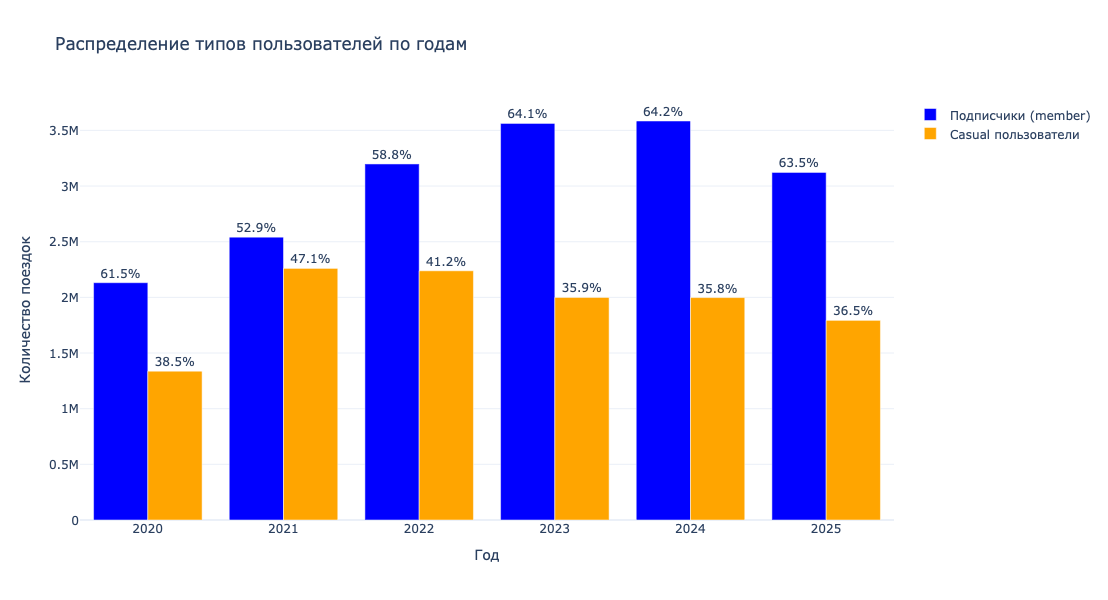


📊 Данные для графика:
shape: (6, 5)
┌──────┬─────────┬─────────┬────────────┬────────────┐
│ year ┆ member  ┆ casual  ┆ member_pct ┆ casual_pct │
│ ---  ┆ ---     ┆ ---     ┆ ---        ┆ ---        │
│ i32  ┆ u32     ┆ u32     ┆ f64        ┆ f64        │
╞══════╪═════════╪═════════╪════════════╪════════════╡
│ 2020 ┆ 2131816 ┆ 1336682 ┆ 61.5       ┆ 38.5       │
│ 2021 ┆ 2540597 ┆ 2260261 ┆ 52.9       ┆ 47.1       │
│ 2022 ┆ 3198434 ┆ 2238668 ┆ 58.8       ┆ 41.2       │
│ 2023 ┆ 3562424 ┆ 1999168 ┆ 64.1       ┆ 35.9       │
│ 2024 ┆ 3584385 ┆ 1998133 ┆ 64.2       ┆ 35.8       │
│ 2025 ┆ 3122243 ┆ 1793451 ┆ 63.5       ┆ 36.5       │
└──────┴─────────┴─────────┴────────────┴────────────┘

СОЗДАНИЕ ГРАФИКА 2: Активность по часам суток (2024 год)
✅ График сохранен как HTML: /Users/vsevolod/Desktop/divvy-bikes-analysis/visualizations/2_hourly_activity_2024.html


/var/folders/m_/0vg5klms5wqfl8z1jkpk95tr0000gn/T/ipykernel_10081/4255581019.py:201: DeprecationWarning:

`pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)

/var/folders/m_/0vg5klms5wqfl8z1jkpk95tr0000gn/T/ipykernel_10081/4255581019.py:68: DeprecationWarning:

the `streaming` parameter was deprecated in 1.25.0; use `engine` instead.



✅ График сохранен как PNG: /Users/vsevolod/Desktop/divvy-bikes-analysis/visualizations/2_hourly_activity_2024.png



📊 Данные для графика (первые 10 строк):
shape: (10, 5)
┌──────┬───────────────┬────────────┬───────────┬────────────┐
│ hour ┆ member_casual ┆ trip_count ┆ max_count ┆ normalized │
│ ---  ┆ ---           ┆ ---        ┆ ---       ┆ ---        │
│ i8   ┆ str           ┆ u32        ┆ u32       ┆ f64        │
╞══════╪═══════════════╪════════════╪═══════════╪════════════╡
│ 0    ┆ casual        ┆ 33682      ┆ 189715    ┆ 17.8       │
│ 1    ┆ casual        ┆ 22567      ┆ 189715    ┆ 11.9       │
│ 2    ┆ casual        ┆ 13994      ┆ 189715    ┆ 7.4        │
│ 3    ┆ casual        ┆ 7788       ┆ 189715    ┆ 4.1        │
│ 4    ┆ casual        ┆ 6140       ┆ 189715    ┆ 3.2        │
│ 5    ┆ casual        ┆ 11124      ┆ 189715    ┆ 5.9        │
│ 6    ┆ casual        ┆ 26678      ┆ 189715    ┆ 14.1       │
│ 7    ┆ casual        ┆ 49306      ┆ 189715    ┆ 26.0       │
│ 8    ┆ casual        ┆ 70241      ┆ 189715    ┆ 37.0       │
│ 9    ┆ casual        ┆ 71405      ┆ 189715    ┆ 37.6       │

/var/folders/m_/0vg5klms5wqfl8z1jkpk95tr0000gn/T/ipykernel_10081/4255581019.py:294: DeprecationWarning:

`pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)

/var/folders/m_/0vg5klms5wqfl8z1jkpk95tr0000gn/T/ipykernel_10081/4255581019.py:68: DeprecationWarning:

the `streaming` parameter was deprecated in 1.25.0; use `engine` instead.



InvalidOperationError: conversion from `str` to `i8` failed in column 'literal' for 12 out of 12 values: ["Январь", "Февраль", … "Октябрь"]

Did not show all failed cases as there were too many.

In [5]:
import polars as pl
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
import os

pio.templates.default = "plotly_white"

# ============================================================================
# КОНФИГУРАЦИЯ
# ============================================================================

DATA_PATHS = {
    2020: "/Users/vsevolod/Desktop/divvy-bikes-analysis/data/processed/2020/rides_2020_optimized_filled.parquet",
    2021: "/Users/vsevolod/Desktop/divvy-bikes-analysis/data/processed/2021/rides_2021_optimized_filled.parquet",
    2022: "/Users/vsevolod/Desktop/divvy-bikes-analysis/data/processed/2022/rides_2022_optimized_filled.parquet",
    2023: "/Users/vsevolod/Desktop/divvy-bikes-analysis/data/processed/2023/rides_2023_optimized_filled.parquet",
    2024: "/Users/vsevolod/Desktop/divvy-bikes-analysis/data/processed/2024/rides_2024_optimized_filled.parquet",
    2025: "/Users/vsevolod/Desktop/divvy-bikes-analysis/data/processed/2025/rides_2025_optimized_filled.parquet"
}

SAVE_DIR = "/Users/vsevolod/Desktop/divvy-bikes-analysis/visualizations"
os.makedirs(SAVE_DIR, exist_ok=True)

# ============================================================================
# ОБЩИЕ ФУНКЦИИ ДЛЯ ЗАГРУЗКИ ДАННЫХ
# ============================================================================

def load_year_data(year, columns=None):
    """Загружает данные за конкретный год с ленивой обработкой"""
    if year not in DATA_PATHS:
        return None
    
    path = DATA_PATHS[year]
    if not os.path.exists(path):
        return None
    
    # Базовые колонки, которые всегда нужны
    base_columns = ["started_at", "ended_at", "member_casual", "rideable_type"]
    
    if columns:
        base_columns = [col for col in columns if col in base_columns + ["start_station_name", "end_station_name", "start_lat", "start_lng"]]
    
    # Ленивая загрузка
    lf = pl.scan_parquet(path).select(base_columns)
    
    # Добавляем вычисляемые колонки
    lf = lf.with_columns([
        pl.lit(year).alias("year"),
        pl.col("started_at").dt.month().alias("month"),
        pl.col("started_at").dt.hour().alias("hour"),
        pl.col("started_at").dt.weekday().alias("weekday"),
        ((pl.col("ended_at") - pl.col("started_at")).dt.total_seconds()).alias("duration_sec")
    ])
    
    # Фильтруем аномалии
    lf = lf.filter(
        (pl.col("duration_sec") > 60) & 
        (pl.col("duration_sec") < 24 * 3600)
    )
    
    return lf

def collect_safely(lazy_frame):
    """Безопасный сбор данных с обработкой ошибок"""
    try:
        return lazy_frame.collect(streaming=True)
    except Exception as e:
        print(f"Ошибка при сборе данных: {e}")
        return None

# ============================================================================
# ГРАФИК 1: Распределение типов подписок по годам
# ============================================================================

def plot_membership_by_year(years=None):
    """График распределения типов пользователей по годам"""
    print("=" * 70)
    print("СОЗДАНИЕ ГРАФИКА 1: Распределение типов подписок по годам")
    print("=" * 70)
    
    if years is None:
        years = list(DATA_PATHS.keys())
    
    all_results = []
    
    for year in years:
        print(f"Обрабатываю {year} год...")
        
        lf = load_year_data(year)
        if lf is None:
            continue
        
        # Агрегируем данные по типу пользователя
        query = lf.group_by("member_casual").agg([
            pl.count().alias("count"),
            (pl.col("duration_sec") / 60).mean().round(1).alias("avg_duration_min")
        ])
        
        result = collect_safely(query)
        if result is not None:
            # Добавляем год к результату
            result = result.with_columns(pl.lit(year).alias("year"))
            all_results.append(result)
    
    if not all_results:
        print("❌ Нет данных для построения графика")
        return None
    
    # Объединяем результаты
    combined = pl.concat(all_results)
    
    # Создаем сводную таблицу
    pivot_data = combined.pivot(
        values="count",
        index="year",
        columns="member_casual",
        aggregate_function="sum"
    ).fill_null(0)
    
    # Вычисляем проценты
    pivot_data = pivot_data.with_columns([
        (pl.col("member") / (pl.col("member") + pl.col("casual")) * 100).round(1).alias("member_pct"),
        (pl.col("casual") / (pl.col("member") + pl.col("casual")) * 100).round(1).alias("casual_pct")
    ])
    
    # Создаем график
    fig = go.Figure()
    
    # Столбцы для подписчиков
    fig.add_trace(go.Bar(
        x=pivot_data["year"],
        y=pivot_data["member"],
        name="Подписчики (member)",
        marker_color="blue",
        text=pivot_data["member_pct"],
        texttemplate="%{text:.1f}%",
        textposition="outside"
    ))
    
    # Столбцы для casual пользователей
    fig.add_trace(go.Bar(
        x=pivot_data["year"],
        y=pivot_data["casual"],
        name="Casual пользователи",
        marker_color="orange",
        text=pivot_data["casual_pct"],
        texttemplate="%{text:.1f}%",
        textposition="outside"
    ))
    
    fig.update_layout(
        title="Распределение типов пользователей по годам",
        xaxis_title="Год",
        yaxis_title="Количество поездок",
        barmode="group",
        height=600,
        showlegend=True
    )
    
    # Сохраняем график
    save_path_html = os.path.join(SAVE_DIR, "1_membership_by_year.html")
    save_path_png = os.path.join(SAVE_DIR, "1_membership_by_year.png")
    
    fig.write_html(save_path_html)
    print(f"✅ График сохранен как HTML: {save_path_html}")
    
    try:
        fig.write_image(save_path_png, width=1200, height=600)
        print(f"✅ График сохранен как PNG: {save_path_png}")
    except Exception as e:
        print(f"⚠️  Не удалось сохранить PNG (требуется kaleido): {e}")
    
    # Показываем график
    fig.show()
    
    # Выводим таблицу с данными
    print("\n📊 Данные для графика:")
    print(pivot_data.select(["year", "member", "casual", "member_pct", "casual_pct"]))
    
    return fig

# ============================================================================
# ГРАФИК 2: Активность по часам суток
# ============================================================================

def plot_hourly_activity(year=2024):
    """График активности по часам суток для указанного года"""
    print("\n" + "=" * 70)
    print(f"СОЗДАНИЕ ГРАФИКА 2: Активность по часам суток ({year} год)")
    print("=" * 70)
    
    lf = load_year_data(year)
    if lf is None:
        print(f"❌ Нет данных за {year} год")
        return None
    
    # Агрегируем данные по часам и типу пользователя
    query = lf.group_by(["hour", "member_casual"]).agg(
        pl.count().alias("trip_count")
    ).sort(["hour", "member_casual"])
    
    data = collect_safely(query)
    if data is None or data.height == 0:
        print("❌ Нет данных для построения графика")
        return None
    
    # Нормализуем данные для каждого типа пользователя
    max_by_type = data.group_by("member_casual").agg(
        pl.col("trip_count").max().alias("max_count")
    )
    
    data = data.join(max_by_type, on="member_casual")
    data = data.with_columns(
        (pl.col("trip_count") / pl.col("max_count") * 100).round(1).alias("normalized")
    )
    
    # Создаем график
    fig = px.line(
        data.to_pandas(),
        x="hour",
        y="normalized",
        color="member_casual",
        title=f"Активность по часам суток ({year} год)",
        markers=True,
        labels={
            "hour": "Час дня",
            "normalized": "Активность (% от максимума)",
            "member_casual": "Тип пользователя"
        }
    )
    
    # Добавляем выделение часов пик
    fig.add_vrect(
        x0=7, x1=9,
        fillcolor="lightblue",
        opacity=0.2,
        line_width=0,
        annotation_text="Утренний час пик",
        annotation_position="top left"
    )
    
    fig.add_vrect(
        x0=16, x1=18,
        fillcolor="lightcoral",
        opacity=0.2,
        line_width=0,
        annotation_text="Вечерний час пик",
        annotation_position="top right"
    )
    
    fig.update_layout(height=500)
    
    # Сохраняем график
    save_path_html = os.path.join(SAVE_DIR, f"2_hourly_activity_{year}.html")
    save_path_png = os.path.join(SAVE_DIR, f"2_hourly_activity_{year}.png")
    
    fig.write_html(save_path_html)
    print(f"✅ График сохранен как HTML: {save_path_html}")
    
    try:
        fig.write_image(save_path_png, width=1200, height=500)
        print(f"✅ График сохранен как PNG: {save_path_png}")
    except Exception as e:
        print(f"⚠️  Не удалось сохранить PNG: {e}")
    
    # Показываем график
    fig.show()
    
    # Выводим таблицу с данными
    print("\n📊 Данные для графика (первые 10 строк):")
    print(data.sort(["member_casual", "hour"]).head(10))
    
    return fig

# ============================================================================
# ГРАФИК 3: Сезонность по месяцам
# ============================================================================

def plot_seasonal_patterns(year=2024):
    """График сезонных паттернов по месяцам"""
    print("\n" + "=" * 70)
    print(f"СОЗДАНИЕ ГРАФИКА 3: Сезонность по месяцам ({year} год)")
    print("=" * 70)
    
    lf = load_year_data(year)
    if lf is None:
        print(f"❌ Нет данных за {year} год")
        return None
    
    # Агрегируем данные по месяцам и типу пользователя
    query = lf.group_by(["month", "member_casual"]).agg([
        pl.count().alias("trip_count"),
        (pl.col("duration_sec") / 60).mean().round(1).alias("avg_duration_min")
    ]).sort(["month", "member_casual"])
    
    data = collect_safely(query)
    if data is None or data.height == 0:
        print("❌ Нет данных для построения графика")
        return None
    
    # Названия месяцев
    month_names = {
        1: "Январь", 2: "Февраль", 3: "Март", 4: "Апрель",
        5: "Май", 6: "Июнь", 7: "Июль", 8: "Август",
        9: "Сентябрь", 10: "Октябрь", 11: "Ноябрь", 12: "Декабрь"
    }
    
    data = data.with_columns(
        pl.col("month").replace(month_names).alias("month_name")
    )
    
    # Создаем subplot
    fig = make_subplots(
        rows=2, cols=1,
        subplot_titles=("Количество поездок по месяцам", "Средняя длительность поездок"),
        vertical_spacing=0.15
    )
    
    # График 1: Количество поездок
    for member_type, color in [("member", "blue"), ("casual", "orange")]:
        subset = data.filter(pl.col("member_casual") == member_type)
        fig.add_trace(
            go.Bar(
                x=subset["month_name"],
                y=subset["trip_count"],
                name=member_type,
                marker_color=color,
                text=subset["trip_count"],
                textposition="auto"
            ),
            row=1, col=1
        )
    
    # График 2: Длительность поездок
    for member_type, color in [("member", "blue"), ("casual", "orange")]:
        subset = data.filter(pl.col("member_casual") == member_type)
        fig.add_trace(
            go.Scatter(
                x=subset["month_name"],
                y=subset["avg_duration_min"],
                name=f"{member_type} - длительность",
                mode="lines+markers",
                line=dict(color=color, width=2),
                marker=dict(size=8)
            ),
            row=2, col=1
        )
    
    fig.update_layout(
        title=f"Сезонные паттерны использования ({year} год)",
        height=700,
        showlegend=True,
        barmode="group"
    )
    
    fig.update_xaxes(title_text="Месяц", row=2, col=1)
    fig.update_yaxes(title_text="Количество поездок", row=1, col=1)
    fig.update_yaxes(title_text="Длительность (минуты)", row=2, col=1)
    
    # Сохраняем график
    save_path_html = os.path.join(SAVE_DIR, f"3_seasonal_patterns_{year}.html")
    save_path_png = os.path.join(SAVE_DIR, f"3_seasonal_patterns_{year}.png")
    
    fig.write_html(save_path_html)
    print(f"✅ График сохранен как HTML: {save_path_html}")
    
    try:
        fig.write_image(save_path_png, width=1200, height=700)
        print(f"✅ График сохранен как PNG: {save_path_png}")
    except Exception as e:
        print(f"⚠️  Не удалось сохранить PNG: {e}")
    
    # Показываем график
    fig.show()
    
    return fig

# ============================================================================
# ГРАФИК 4: Активность по дням недели
# ============================================================================

def plot_weekday_patterns(year=2024):
    """График активности по дням недели"""
    print("\n" + "=" * 70)
    print(f"СОЗДАНИЕ ГРАФИКА 4: Активность по дням недели ({year} год)")
    print("=" * 70)
    
    lf = load_year_data(year)
    if lf is None:
        print(f"❌ Нет данных за {year} год")
        return None
    
    # Добавляем название дня недели
    weekday_names = {
        1: "Понедельник", 2: "Вторник", 3: "Среда",
        4: "Четверг", 5: "Пятница", 6: "Суббота", 7: "Воскресенье"
    }
    
    lf = lf.with_columns(
        pl.col("weekday").replace(weekday_names).alias("weekday_name")
    )
    
    # Агрегируем данные по дням недели и типу пользователя
    query = lf.group_by(["weekday_name", "member_casual"]).agg([
        pl.count().alias("trip_count"),
        (pl.col("duration_sec") / 60).mean().round(1).alias("avg_duration_min")
    ])
    
    data = collect_safely(query)
    if data is None or data.height == 0:
        print("❌ Нет данных для построения графика")
        return None
    
    # Правильный порядок дней недели
    weekday_order = ["Понедельник", "Вторник", "Среда", "Четверг", "Пятница", "Суббота", "Воскресенье"]
    data = data.with_columns(
        pl.col("weekday_name").cast(pl.Categorical(categories=weekday_order)).alias("weekday_cat")
    ).sort("weekday_cat")
    
    # Создаем sunburst диаграмму
    fig = px.sunburst(
        data.to_pandas(),
        path=["member_casual", "weekday_name"],
        values="trip_count",
        title=f"Распределение поездок по дням недели ({year} год)",
        color="trip_count",
        color_continuous_scale="Blues"
    )
    
    fig.update_layout(height=600)
    
    # Сохраняем график
    save_path_html = os.path.join(SAVE_DIR, f"4_weekday_patterns_{year}.html")
    save_path_png = os.path.join(SAVE_DIR, f"4_weekday_patterns_{year}.png")
    
    fig.write_html(save_path_html)
    print(f"✅ График сохранен как HTML: {save_path_html}")
    
    try:
        fig.write_image(save_path_png, width=1200, height=600)
        print(f"✅ График сохранен как PNG: {save_path_png}")
    except Exception as e:
        print(f"⚠️  Не удалось сохранить PNG: {e}")
    
    # Показываем график
    fig.show()
    
    # Выводим таблицу с данными
    print("\n📊 Данные для графика:")
    pivot_table = data.pivot(
        values="trip_count",
        index="weekday_name",
        columns="member_casual",
        aggregate_function="first"
    )
    print(pivot_table)
    
    return fig

# ============================================================================
# ГРАФИК 5: Карта популярных станций
# ============================================================================

def plot_top_stations_map(year=2024, top_n=20):
    """Карта топ-N популярных станций отправления"""
    print("\n" + "=" * 70)
    print(f"СОЗДАНИЕ ГРАФИКА 5: Карта топ-{top_n} станций ({year} год)")
    print("=" * 70)
    
    # Загружаем данные с координатами
    lf = load_year_data(year, columns=["start_station_name", "start_lat", "start_lng"])
    if lf is None:
        print(f"❌ Нет данных за {year} год")
        return None
    
    # Фильтруем станции без координат
    lf = lf.filter(
        pl.col("start_station_name").is_not_null() &
        (pl.col("start_station_name") != "Non-Station Parking") &
        pl.col("start_lat").is_not_null() &
        pl.col("start_lng").is_not_null()
    )
    
    # Агрегируем данные по станциям
    query = lf.group_by(["start_station_name", "start_lat", "start_lng"]).agg(
        pl.count().alias("departures")
    ).sort("departures", descending=True).head(top_n)
    
    data = collect_safely(query)
    if data is None or data.height == 0:
        print("❌ Нет данных о станциях для построения карты")
        return None
    
    # Создаем карту
    fig = px.scatter_mapbox(
        data.to_pandas(),
        lat="start_lat",
        lon="start_lng",
        size="departures",
        color="departures",
        hover_name="start_station_name",
        hover_data={"departures": True, "start_lat": False, "start_lng": False},
        size_max=30,
        zoom=10,
        mapbox_style="carto-positron",
        title=f"Топ-{top_n} станций отправления ({year} год)",
        color_continuous_scale="Viridis"
    )
    
    # Центрируем на Чикаго
    fig.update_layout(
        mapbox=dict(
            center=dict(lat=41.8781, lon=-87.6298),
            zoom=10
        ),
        height=600
    )
    
    # Сохраняем график
    save_path_html = os.path.join(SAVE_DIR, f"5_top_stations_{year}.html")
    save_path_png = os.path.join(SAVE_DIR, f"5_top_stations_{year}.png")
    
    fig.write_html(save_path_html)
    print(f"✅ График сохранен как HTML: {save_path_html}")
    
    try:
        fig.write_image(save_path_png, width=1200, height=600)
        print(f"✅ График сохранен как PNG: {save_path_png}")
    except Exception as e:
        print(f"⚠️  Не удалось сохранить PNG: {e}")
    
    # Показываем график
    fig.show()
    
    # Выводим таблицу с топ-10 станций
    print(f"\n🚲 Топ-10 станций {year} года:")
    for i, row in enumerate(data.head(10).iter_rows(named=True), 1):
        print(f"{i:2}. {row['start_station_name']}: {row['departures']:,} поездок")
    
    return fig

# ============================================================================
# ГРАФИК 6: Типы транспорта по годам
# ============================================================================

def plot_vehicle_types_evolution(years=None):
    """График эволюции типов транспорта по годам"""
    print("\n" + "=" * 70)
    print("СОЗДАНИЕ ГРАФИКА 6: Эволюция типов транспорта по годам")
    print("=" * 70)
    
    if years is None:
        years = list(DATA_PATHS.keys())
    
    all_results = []
    
    for year in years:
        print(f"Обрабатываю {year} год...")
        
        lf = load_year_data(year, columns=["rideable_type"])
        if lf is None:
            continue
        
        # Проверяем, есть ли колонка rideable_type
        if "rideable_type" not in lf.columns:
            print(f"  ⚠️  В {year} году нет данных о типах транспорта")
            continue
        
        # Агрегируем данные по типу транспорта
        query = lf.group_by("rideable_type").agg(
            pl.count().alias("count")
        ).with_columns(pl.lit(year).alias("year"))
        
        result = collect_safely(query)
        if result is not None and result.height > 0:
            all_results.append(result)
    
    if not all_results:
        print("❌ Нет данных о типах транспорта")
        return None
    
    # Объединяем результаты
    combined = pl.concat(all_results)
    
    # Добавляем проценты
    yearly_totals = combined.group_by("year").agg(
        pl.col("count").sum().alias("total")
    )
    
    combined = combined.join(yearly_totals, on="year")
    combined = combined.with_columns(
        (pl.col("count") / pl.col("total") * 100).round(1).alias("percentage")
    )
    
    # Создаем stacked bar chart
    fig = px.bar(
        combined.to_pandas(),
        x="year",
        y="percentage",
        color="rideable_type",
        title="Распределение типов транспорта по годам",
        labels={
            "year": "Год",
            "percentage": "Доля, %",
            "rideable_type": "Тип транспорта"
        },
        barmode="stack"
    )
    
    fig.update_layout(height=500)
    
    # Сохраняем график
    save_path_html = os.path.join(SAVE_DIR, "6_vehicle_types_evolution.html")
    save_path_png = os.path.join(SAVE_DIR, "6_vehicle_types_evolution.png")
    
    fig.write_html(save_path_html)
    print(f"✅ График сохранен как HTML: {save_path_html}")
    
    try:
        fig.write_image(save_path_png, width=1200, height=500)
        print(f"✅ График сохранен как PNG: {save_path_png}")
    except Exception as e:
        print(f"⚠️  Не удалось сохранить PNG: {e}")
    
    # Показываем график
    fig.show()
    
    # Выводим таблицу с данными
    print("\n📊 Данные для графика:")
    pivot_table = combined.pivot(
        values="percentage",
        index="rideable_type",
        columns="year",
        aggregate_function="first"
    ).fill_null(0)
    print(pivot_table)
    
    return fig

# ============================================================================
# ОСНОВНАЯ ФУНКЦИЯ ДЛЯ ЗАПУСКА ВСЕХ ГРАФИКОВ
# ============================================================================

def create_all_visualizations():
    """Создает все графики по очереди"""
    print("=" * 70)
    print("НАЧАЛО СОЗДАНИЯ ВСЕХ ВИЗУАЛИЗАЦИЙ")
    print("=" * 70)
    
    # Создаем папку для визуализаций
    os.makedirs(SAVE_DIR, exist_ok=True)
    
    # График 1: Распределение по годам
    plot_membership_by_year()
    
    # График 2: Активность по часам (для 2024 года)
    plot_hourly_activity(year=2024)
    
    # График 3: Сезонность (для 2024 года)
    plot_seasonal_patterns(year=2024)
    
    # График 4: Дни недели (для 2024 года)
    plot_weekday_patterns(year=2024)
    
    # График 5: Карта станций (для 2024 года)
    plot_top_stations_map(year=2024, top_n=20)
    
    # График 6: Типы транспорта
    plot_vehicle_types_evolution()
    
    print("\n" + "=" * 70)
    print("✅ ВСЕ ВИЗУАЛИЗАЦИИ УСПЕШНО СОЗДАНЫ И СОХРАНЕНЫ")
    print(f"📁 Файлы сохранены в: {SAVE_DIR}")
    print("=" * 70)

# ============================================================================
# ФУНКЦИЯ ДЛЯ ВЫБОРА КОНКРЕТНОГО ГРАФИКА
# ============================================================================

def create_specific_visualization(choice, year=2024):
    """Создает конкретный график по выбору"""
    if choice == 1:
        return plot_membership_by_year()
    elif choice == 2:
        return plot_hourly_activity(year)
    elif choice == 3:
        return plot_seasonal_patterns(year)
    elif choice == 4:
        return plot_weekday_patterns(year)
    elif choice == 5:
        return plot_top_stations_map(year)
    elif choice == 6:
        return plot_vehicle_types_evolution()
    else:
        print("❌ Неверный выбор. Доступные варианты: 1-6")
        return None

# ============================================================================
# ЗАПУСК ПРОГРАММЫ
# ============================================================================

if __name__ == "__main__":
    print("=" * 70)
    print("ВИЗУАЛИЗАЦИЯ ДАННЫХ DIVVY BIKES")
    print("=" * 70)
    print("\nВыберите действие:")
    print("1. Создать все графики")
    print("2. Создать конкретный график")
    
    action = input("\nВведите номер (1 или 2): ").strip()
    
    if action == "1":
        create_all_visualizations()
    elif action == "2":
        print("\nДоступные графики:")
        print("1. Распределение типов подписок по годам")
        print("2. Активность по часам суток")
        print("3. Сезонность по месяцам")
        print("4. Активность по дням недели")
        print("5. Карта популярных станций")
        print("6. Типы транспорта по годам")
        
        choice = input("\nВведите номер графика (1-6): ").strip()
        
        try:
            choice = int(choice)
            if 2 <= choice <= 5:  # Для графиков 2-5 можно выбрать год
                year_input = input(f"Введите год для графика {choice} (по умолчанию 2024): ").strip()
                year = int(year_input) if year_input else 2024
                create_specific_visualization(choice, year)
            else:
                create_specific_visualization(choice)
        except ValueError:
            print("❌ Пожалуйста, введите число от 1 до 6")
    else:
        print("❌ Неверный выбор. Запускаю создание всех графиков...")
        create_all_visualizations()

In [23]:
# import polars as pl
# import plotly.express as px
# import plotly.graph_objects as go
# from plotly.subplots import make_subplots
# import plotly.io as pio
# import os

# pio.templates.default = "plotly_white"

# # ============================================================================
# # КОНФИГУРАЦИЯ
# # ============================================================================

# DATA_PATHS = {
#     2020: "/Users/vsevolod/Desktop/divvy-bikes-analysis/data/processed/2020/rides_2020_optimized_filled.parquet",
#     2021: "/Users/vsevolod/Desktop/divvy-bikes-analysis/data/processed/2021/rides_2021_optimized_filled.parquet",
#     2022: "/Users/vsevolod/Desktop/divvy-bikes-analysis/data/processed/2022/rides_2022_optimized_filled.parquet",
#     2023: "/Users/vsevolod/Desktop/divvy-bikes-analysis/data/processed/2023/rides_2023_optimized_filled.parquet",
#     2024: "/Users/vsevolod/Desktop/divvy-bikes-analysis/data/processed/2024/rides_2024_optimized_filled.parquet",
#     2025: "/Users/vsevolod/Desktop/divvy-bikes-analysis/data/processed/2025/rides_2025_optimized_filled.parquet"
# }

# SAVE_DIR = "/Users/vsevolod/Desktop/divvy-bikes-analysis/visualizations"
# os.makedirs(SAVE_DIR, exist_ok=True)

# # ============================================================================
# # ОБЩИЕ ФУНКЦИИ ДЛЯ ЗАГРУЗКИ ДАННЫХ (ИСПРАВЛЕННЫЕ)
# # ============================================================================

# def load_year_data(year, columns=None):
#     """Загружает данные за конкретный год с ленивой обработкой"""
#     if year not in DATA_PATHS:
#         return None
    
#     path = DATA_PATHS[year]
#     if not os.path.exists(path):
#         return None
    
#     # Базовые колонки, которые всегда нужны
#     base_columns = ["started_at", "ended_at", "member_casual", "rideable_type"]
    
#     if columns:
#         # Добавляем запрошенные колонки, если они существуют
#         available_columns = base_columns + ["start_station_name", "end_station_name", "start_lat", "start_lng"]
#         base_columns = [col for col in columns if col in available_columns]
    
#     # Ленивая загрузка
#     lf = pl.scan_parquet(path).select(base_columns)
    
#     # Добавляем вычисляемые колонки
#     lf = lf.with_columns([
#         pl.lit(year).alias("year"),
#         pl.col("started_at").dt.month().alias("month"),
#         pl.col("started_at").dt.hour().alias("hour"),
#         pl.col("started_at").dt.weekday().alias("weekday"),
#         ((pl.col("ended_at") - pl.col("started_at")).dt.total_seconds()).alias("duration_sec")
#     ])
    
#     # Фильтруем аномалии
#     lf = lf.filter(
#         (pl.col("duration_sec") > 60) & 
#         (pl.col("duration_sec") < 24 * 3600)
#     )
    
#     return lf

# def collect_safely(lazy_frame):
#     """Безопасный сбор данных с обработкой ошибок (ИСПРАВЛЕНО)"""
#     try:
#         return lazy_frame.collect()
#     except Exception as e:
#         print(f"Ошибка при сборе данных: {e}")
#         return None

# # ============================================================================
# # ГРАФИК 3: Сезонность по месяцам (ИСПРАВЛЕННЫЙ)
# # ============================================================================

# def plot_seasonal_patterns_fixed(year=2024):
#     """График сезонных паттернов по месяцам - исправленная версия"""
#     print("\n" + "=" * 70)
#     print(f"СОЗДАНИЕ ГРАФИКА 3: Сезонность по месяцам ({year} год)")
#     print("=" * 70)
    
#     lf = load_year_data(year)
#     if lf is None:
#         print(f"❌ Нет данных за {year} год")
#         return None
    
#     # Агрегируем данные по месяцам и типу пользователя
#     query = lf.group_by(["month", "member_casual"]).agg([
#         pl.len().alias("trip_count"),
#         (pl.col("duration_sec") / 60).mean().round(1).alias("avg_duration_min")
#     ]).sort(["month", "member_casual"])
    
#     data = collect_safely(query)
#     if data is None or data.height == 0:
#         print("❌ Нет данных для построения графика")
#         return None
    
#     print(f"Данные загружены: {data.height} строк")
#     print(f"Столбцы: {data.columns}")
    
#     # Правильный порядок месяцев для сортировки
#     month_order = ["Январь", "Февраль", "Март", "Апрель", "Май", "Июнь", 
#                    "Июль", "Август", "Сентябрь", "Октябрь", "Ноябрь", "Декабрь"]
    
#     # Создаем mapping для преобразования чисел в названия месяцев
#     # Используем словарь и простую функцию
#     month_dict = {
#         1: "Январь", 2: "Февраль", 3: "Март", 4: "Апрель",
#         5: "Май", 6: "Июнь", 7: "Июль", 8: "Август",
#         9: "Сентябрь", 10: "Октябрь", 11: "Ноябрь", 12: "Декабрь"
#     }
    
#     # Добавляем название месяца
#     data = data.with_columns([
#         pl.col("month").map_elements(lambda x: month_dict.get(x, "Неизвестно"), return_dtype=pl.Utf8).alias("month_name")
#     ])
    
#     # Убедимся, что у нас есть правильный порядок
#     data = data.with_columns([
#         pl.col("month_name").cast(pl.Categorical(categories=month_order)).alias("month_cat")
#     ]).sort("month_cat")
    
#     # Создаем subplot
#     fig = make_subplots(
#         rows=2, cols=1,
#         subplot_titles=("Количество поездок по месяцам", "Средняя длительность поездок"),
#         vertical_spacing=0.15
#     )
    
#     # График 1: Количество поездок
#     for member_type, color in [("member", "blue"), ("casual", "orange")]:
#         subset = data.filter(pl.col("member_casual") == member_type)
#         fig.add_trace(
#             go.Bar(
#                 x=subset["month_name"],
#                 y=subset["trip_count"],
#                 name=member_type,
#                 marker_color=color,
#                 text=subset["trip_count"],
#                 textposition="auto"
#             ),
#             row=1, col=1
#         )
    
#     # График 2: Длительность поездок
#     for member_type, color in [("member", "blue"), ("casual", "orange")]:
#         subset = data.filter(pl.col("member_casual") == member_type)
#         fig.add_trace(
#             go.Scatter(
#                 x=subset["month_name"],
#                 y=subset["avg_duration_min"],
#                 name=f"{member_type} - длительность",
#                 mode="lines+markers",
#                 line=dict(color=color, width=2),
#                 marker=dict(size=8)
#             ),
#             row=2, col=1
#         )
    
#     fig.update_layout(
#         title=f"Сезонные паттерны использования ({year} год)",
#         height=700,
#         showlegend=True,
#         barmode="group"
#     )
    
#     fig.update_xaxes(title_text="Месяц", row=2, col=1, tickangle=45)
#     fig.update_yaxes(title_text="Количество поездок", row=1, col=1)
#     fig.update_yaxes(title_text="Длительность (минуты)", row=2, col=1)
    
#     # Сохраняем график
#     save_path_html = os.path.join(SAVE_DIR, f"3_seasonal_patterns_{year}.html")
#     save_path_png = os.path.join(SAVE_DIR, f"3_seasonal_patterns_{year}.png")
    
#     fig.write_html(save_path_html)
#     print(f"✅ График сохранен как HTML: {save_path_html}")
    
#     try:
#         fig.write_image(save_path_png, width=1200, height=700, engine="kaleido")
#         print(f"✅ График сохранен как PNG: {save_path_png}")
#     except Exception as e:
#         print(f"⚠️  Не удалось сохранить PNG: {e}")
    
#     # Показываем график
#     fig.show()
    
#     # Выводим сводную таблицу
#     print(f"\n📊 Сводная статистика по месяцам ({year} год):")
#     pivot_table = data.pivot(
#         values="trip_count",
#         index="month_name",
#         columns="member_casual",
#         aggregate_function="first"
#     ).fill_null(0)
#     print(pivot_table)
    
#     return fig

# # ============================================================================
# # ГРАФИК 4: Активность по дням недели (ИСПРАВЛЕННЫЙ)
# # ============================================================================

# def plot_weekday_patterns_fixed(year=2024):
#     """График активности по дням недели - исправленная версия"""
#     print("\n" + "=" * 70)
#     print(f"СОЗДАНИЕ ГРАФИКА 4: Активность по дням недели ({year} год)")
#     print("=" * 70)
    
#     lf = load_year_data(year)
#     if lf is None:
#         print(f"❌ Нет данных за {year} год")
#         return None
    
#     # Агрегируем данные по дням недели и типу пользователя
#     query = lf.group_by(["weekday", "member_casual"]).agg([
#         pl.len().alias("trip_count"),
#         (pl.col("duration_sec") / 60).mean().round(1).alias("avg_duration_min")
#     ])
    
#     data = collect_safely(query)
#     if data is None or data.height == 0:
#         print("❌ Нет данных для построения графика")
#         return None
    
#     print(f"Данные загружены: {data.height} строк")
    
#     # Словарь для преобразования чисел в названия дней
#     weekday_dict = {
#         1: "Понедельник", 2: "Вторник", 3: "Среда",
#         4: "Четверг", 5: "Пятница", 6: "Суббота", 7: "Воскресенье"
#     }
    
#     # Преобразуем числа в названия дней
#     data = data.with_columns([
#         pl.col("weekday").map_elements(lambda x: weekday_dict.get(x, "Неизвестно"), return_dtype=pl.Utf8).alias("weekday_name")
#     ])
    
#     # Правильный порядок дней недели
#     weekday_order = ["Понедельник", "Вторник", "Среда", "Четверг", "Пятница", "Суббота", "Воскресенье"]
#     data = data.with_columns([
#         pl.col("weekday_name").cast(pl.Categorical(categories=weekday_order)).alias("weekday_cat")
#     ]).sort("weekday_cat")
    
#     # Создаем два отдельных графика
#     fig = make_subplots(
#         rows=1, cols=2,
#         subplot_titles=("Количество поездок по дням недели", "Средняя длительность поездок"),
#         horizontal_spacing=0.15
#     )
    
#     # График 1: Количество поездок
#     for member_type, color in [("member", "blue"), ("casual", "orange")]:
#         subset = data.filter(pl.col("member_casual") == member_type)
#         fig.add_trace(
#             go.Bar(
#                 x=subset["weekday_name"],
#                 y=subset["trip_count"],
#                 name=member_type,
#                 marker_color=color,
#                 text=subset["trip_count"],
#                 textposition="auto"
#             ),
#             row=1, col=1
#         )
    
#     # График 2: Длительность поездок
#     for member_type, color in [("member", "blue"), ("casual", "orange")]:
#         subset = data.filter(pl.col("member_casual") == member_type)
#         fig.add_trace(
#             go.Scatter(
#                 x=subset["weekday_name"],
#                 y=subset["avg_duration_min"],
#                 name=member_type,
#                 mode="lines+markers",
#                 line=dict(color=color, width=2),
#                 marker=dict(size=8)
#             ),
#             row=1, col=2
#         )
    
#     fig.update_layout(
#         title=f"Активность по дням недели ({year} год)",
#         height=500,
#         showlegend=True,
#         barmode="group"
#     )
    
#     fig.update_xaxes(title_text="День недели", row=1, col=1, tickangle=45)
#     fig.update_xaxes(title_text="День недели", row=1, col=2, tickangle=45)
#     fig.update_yaxes(title_text="Количество поездок", row=1, col=1)
#     fig.update_yaxes(title_text="Длительность (минуты)", row=1, col=2)
    
#     # Сохраняем график
#     save_path_html = os.path.join(SAVE_DIR, f"4_weekday_patterns_{year}.html")
#     save_path_png = os.path.join(SAVE_DIR, f"4_weekday_patterns_{year}.png")
    
#     fig.write_html(save_path_html)
#     print(f"✅ График сохранен как HTML: {save_path_html}")
    
#     try:
#         fig.write_image(save_path_png, width=1200, height=500, engine="kaleido")
#         print(f"✅ График сохранен как PNG: {save_path_png}")
#     except Exception as e:
#         print(f"⚠️  Не удалось сохранить PNG: {e}")
    
#     # Показываем график
#     fig.show()
    
#     # Выводим таблицу с данными
#     print(f"\n📊 Данные по дням недели ({year} год):")
#     pivot_table = data.pivot(
#         values="trip_count",
#         index="weekday_name",
#         columns="member_casual",
#         aggregate_function="first"
#     ).fill_null(0)
#     print(pivot_table)
    
#     return fig

# # ============================================================================
# # ГРАФИК 5: Карта популярных станций (ИСПРАВЛЕННЫЙ)
# # ============================================================================

# def plot_top_stations_map_fixed(year=2024, top_n=20):
#     """Карта топ-N популярных станций отправления - исправленная версия"""
#     print("\n" + "=" * 70)
#     print(f"СОЗДАНИЕ ГРАФИКА 5: Карта топ-{top_n} станций ({year} год)")
#     print("=" * 70)
    
#     # Загружаем данные с координатами
#     lf = load_year_data(year, columns=["start_station_name", "start_lat", "start_lng"])
#     if lf is None:
#         print(f"❌ Нет данных за {year} год")
#         return None
    
#     # Фильтруем станции без координат
#     lf = lf.filter(
#         pl.col("start_station_name").is_not_null() &
#         (pl.col("start_station_name") != "Non-Station Parking") &
#         pl.col("start_lat").is_not_null() &
#         pl.col("start_lng").is_not_null()
#     )
    
#     # Агрегируем данные по станциям
#     query = lf.group_by(["start_station_name", "start_lat", "start_lng"]).agg([
#         pl.len().alias("departures")
#     ]).sort("departures", descending=True).head(top_n)
    
#     data = collect_safely(query)
#     if data is None or data.height == 0:
#         print("❌ Нет данных о станциях для построения карты")
#         return None
    
#     # Создаем карту
#     fig = px.scatter_mapbox(
#         data.to_pandas(),
#         lat="start_lat",
#         lon="start_lng",
#         size="departures",
#         color="departures",
#         hover_name="start_station_name",
#         hover_data={"departures": True, "start_lat": False, "start_lng": False},
#         size_max=30,
#         zoom=10,
#         mapbox_style="carto-positron",
#         title=f"Топ-{top_n} станций отправления ({year} год)",
#         color_continuous_scale="Viridis"
#     )
    
#     # Центрируем на Чикаго
#     fig.update_layout(
#         mapbox=dict(
#             center=dict(lat=41.8781, lon=-87.6298),
#             zoom=10
#         ),
#         height=600
#     )
    
#     # Сохраняем график
#     save_path_html = os.path.join(SAVE_DIR, f"5_top_stations_{year}.html")
#     save_path_png = os.path.join(SAVE_DIR, f"5_top_stations_{year}.png")
    
#     fig.write_html(save_path_html)
#     print(f"✅ График сохранен как HTML: {save_path_html}")
    
#     try:
#         fig.write_image(save_path_png, width=1200, height=600, engine="kaleido")
#         print(f"✅ График сохранен как PNG: {save_path_png}")
#     except Exception as e:
#         print(f"⚠️  Не удалось сохранить PNG: {e}")
    
#     # Показываем график
#     fig.show()
    
#     # Выводим таблицу с топ-10 станций
#     print(f"\n🚲 Топ-10 станций {year} года:")
#     for i, row in enumerate(data.head(10).iter_rows(named=True), 1):
#         print(f"{i:2}. {row['start_station_name']}: {row['departures']:,} поездок")
    
#     # Дополнительная статистика
#     total_departures = data["departures"].sum()
#     avg_departures = data["departures"].mean()
    
#     print(f"\n📈 Статистика станций:")
#     print(f"   • Всего поездок с топ-{top_n} станций: {total_departures:,}")
#     print(f"   • Среднее количество поездок на станцию: {avg_departures:.0f}")
#     print(f"   • Самая популярная станция: {data['start_station_name'][0]} ({data['departures'][0]:,} поездок)")
    
#     return fig

# # ============================================================================
# # ГРАФИК 6: Типы транспорта по годам (ИСПРАВЛЕННЫЙ)
# # ============================================================================

# def plot_vehicle_types_evolution_fixed(years=None):
#     """График эволюции типов транспорта по годам - исправленная версия"""
#     print("\n" + "=" * 70)
#     print("СОЗДАНИЕ ГРАФИКА 6: Эволюция типов транспорта по годам")
#     print("=" * 70)
    
#     if years is None:
#         years = list(DATA_PATHS.keys())
    
#     all_results = []
    
#     for year in years:
#         print(f"Обрабатываю {year} год...")
        
#         lf = load_year_data(year, columns=["rideable_type"])
#         if lf is None:
#             continue
        
#         # Проверяем, есть ли колонка rideable_type
#         schema = lf.collect_schema()
#         if "rideable_type" not in schema:
#             print(f"  ⚠️  В {year} году нет данных о типах транспорта")
#             continue
        
#         # Агрегируем данные по типу транспорта
#         query = lf.group_by("rideable_type").agg([
#             pl.len().alias("count")
#         ]).with_columns(pl.lit(year).alias("year"))
        
#         result = collect_safely(query)
#         if result is not None and result.height > 0:
#             all_results.append(result)
    
#     if not all_results:
#         print("❌ Нет данных о типах транспорта")
#         return None
    
#     # Объединяем результаты
#     combined = pl.concat(all_results)
    
#     # Добавляем проценты
#     yearly_totals = combined.group_by("year").agg([
#         pl.col("count").sum().alias("total")
#     ])
    
#     combined = combined.join(yearly_totals, on="year")
#     combined = combined.with_columns([
#         (pl.col("count") / pl.col("total") * 100).round(1).alias("percentage")
#     ])
    
#     # Создаем stacked bar chart
#     fig = px.bar(
#         combined.to_pandas(),
#         x="year",
#         y="percentage",
#         color="rideable_type",
#         title="Распределение типов транспорта по годам",
#         labels={
#             "year": "Год",
#             "percentage": "Доля, %",
#             "rideable_type": "Тип транспорта"
#         },
#         barmode="stack"
#     )
    
#     fig.update_layout(height=500)
    
#     # Сохраняем график
#     save_path_html = os.path.join(SAVE_DIR, "6_vehicle_types_evolution.html")
#     save_path_png = os.path.join(SAVE_DIR, "6_vehicle_types_evolution.png")
    
#     fig.write_html(save_path_html)
#     print(f"✅ График сохранен как HTML: {save_path_html}")
    
#     try:
#         fig.write_image(save_path_png, width=1200, height=500, engine="kaleido")
#         print(f"✅ График сохранен как PNG: {save_path_png}")
#     except Exception as e:
#         print(f"⚠️  Не удалось сохранить PNG: {e}")
    
#     # Показываем график
#     fig.show()
    
#     # Выводим таблицу с данными
#     print("\n📊 Данные для графика:")
#     pivot_table = combined.pivot(
#         values="percentage",
#         index="rideable_type",
#         columns="year",
#         aggregate_function="first"
#     ).fill_null(0)
#     print(pivot_table)
    
#     # Анализируем тренды
#     print("\n📈 Анализ трендов типов транспорта:")
    
#     # Создаем упрощенную сводку
#     summary = pivot_table.select(["rideable_type", "2020", "2024", "2025"])
#     print(summary)
    
#     return fig

# # ============================================================================
# # ФУНКЦИЯ ДЛЯ СОЗДАНИЯ ВСЕХ ГРАФИКОВ (ИСПРАВЛЕННАЯ)
# # ============================================================================

# def create_all_visualizations_fixed():
#     """Создает все графики по очереди - исправленная версия"""
#     print("=" * 70)
#     print("НАЧАЛО СОЗДАНИЯ ВСЕХ ВИЗУАЛИЗАЦИЙ (ИСПРАВЛЕННЫЙ КОД)")
#     print("=" * 70)
    
#     # Создаем папку для визуализаций
#     os.makedirs(SAVE_DIR, exist_ok=True)
    
#     # График 1: Распределение по годам
#     print("\n" + "=" * 70)
#     print("ГРАФИК 1: Распределение по годам")
#     print("=" * 70)
    
#     def plot_membership_by_year_fixed():
#         years = list(DATA_PATHS.keys())
#         all_results = []
        
#         for year in years:
#             print(f"Обрабатываю {year} год...")
#             lf = load_year_data(year)
#             if lf is None:
#                 continue
            
#             query = lf.group_by("member_casual").agg([
#                 pl.len().alias("count")
#             ]).with_columns(pl.lit(year).alias("year"))
            
#             result = collect_safely(query)
#             if result is not None:
#                 all_results.append(result)
        
#         if not all_results:
#             return None
        
#         combined = pl.concat(all_results)
        
#         # Используем pivot для создания таблицы
#         pivot_data = combined.pivot(
#             values="count",
#             index="year",
#             columns="member_casual",
#             aggregate_function="sum"
#         ).fill_null(0)
        
#         # Вычисляем проценты
#         pivot_data = pivot_data.with_columns([
#             (pl.col("member") / (pl.col("member") + pl.col("casual")) * 100).round(1).alias("member_pct"),
#             (pl.col("casual") / (pl.col("member") + pl.col("casual")) * 100).round(1).alias("casual_pct")
#         ])
        
#         # Создаем график
#         fig = go.Figure()
        
#         fig.add_trace(go.Bar(
#             x=pivot_data["year"],
#             y=pivot_data["member"],
#             name="Подписчики (member)",
#             marker_color="blue",
#             text=pivot_data["member_pct"],
#             texttemplate="%{text:.1f}%",
#             textposition="outside"
#         ))
        
#         fig.add_trace(go.Bar(
#             x=pivot_data["year"],
#             y=pivot_data["casual"],
#             name="Casual пользователи",
#             marker_color="orange",
#             text=pivot_data["casual_pct"],
#             texttemplate="%{text:.1f}%",
#             textposition="outside"
#         ))
        
#         fig.update_layout(
#             title="Распределение типов пользователей по годам",
#             xaxis_title="Год",
#             yaxis_title="Количество поездок",
#             barmode="group",
#             height=600,
#             showlegend=True
#         )
        
#         # Сохраняем
#         save_path_html = os.path.join(SAVE_DIR, "1_membership_by_year.html")
#         save_path_png = os.path.join(SAVE_DIR, "1_membership_by_year.png")
        
#         fig.write_html(save_path_html)
#         print(f"✅ График 1 сохранен как HTML: {save_path_html}")
        
#         try:
#             fig.write_image(save_path_png, width=1200, height=600, engine="kaleido")
#             print(f"✅ График 1 сохранен как PNG: {save_path_png}")
#         except Exception as e:
#             print(f"⚠️  Не удалось сохранить PNG: {e}")
        
#         fig.show()
#         return fig
    
#     plot_membership_by_year_fixed()
    
#     # График 2: Активность по часам
#     print("\n" + "=" * 70)
#     print("ГРАФИК 2: Активность по часам суток")
#     print("=" * 70)
    
#     def plot_hourly_activity_fixed(year=2024):
#         lf = load_year_data(year)
#         if lf is None:
#             return None
        
#         query = lf.group_by(["hour", "member_casual"]).agg([
#             pl.len().alias("trip_count")
#         ]).sort(["hour", "member_casual"])
        
#         data = collect_safely(query)
#         if data is None:
#             return None
        
#         # Нормализуем данные
#         max_by_type = data.group_by("member_casual").agg([
#             pl.col("trip_count").max().alias("max_count")
#         ])
        
#         data = data.join(max_by_type, on="member_casual")
#         data = data.with_columns([
#             (pl.col("trip_count") / pl.col("max_count") * 100).round(1).alias("normalized")
#         ])
        
#         fig = px.line(
#             data.to_pandas(),
#             x="hour",
#             y="normalized",
#             color="member_casual",
#             title=f"Активность по часам суток ({year} год)",
#             markers=True
#         )
        
#         # Добавляем выделение пиковых часов
#         fig.add_vrect(x0=7, x1=9, fillcolor="lightblue", opacity=0.2, layer="below")
#         fig.add_vrect(x0=16, x1=18, fillcolor="lightcoral", opacity=0.2, layer="below")
        
#         save_path = os.path.join(SAVE_DIR, f"2_hourly_activity_{year}.html")
#         fig.write_html(save_path)
#         print(f"✅ График 2 сохранен: {save_path}")
        
#         fig.show()
#         return fig
    
#     plot_hourly_activity_fixed(2024)
    
#     # График 3: Сезонность по месяцам (исправленный)
#     plot_seasonal_patterns_fixed(year=2024)
    
#     # График 4: Активность по дням недели (исправленный)
#     plot_weekday_patterns_fixed(year=2024)
    
#     # График 5: Карта станций (исправленный)
#     plot_top_stations_map_fixed(year=2024, top_n=20)
    
#     # График 6: Типы транспорта (исправленный)
#     plot_vehicle_types_evolution_fixed()
    
#     print("\n" + "=" * 70)
#     print("✅ ВСЕ ГРАФИКИ УСПЕШНО СОЗДАНЫ И СОХРАНЕНЫ")
#     print(f"📁 Файлы сохранены в: {SAVE_DIR}")
#     print("=" * 70)

# # ============================================================================
# # ЗАПУСК ПРОГРАММЫ
# # ============================================================================

# if __name__ == "__main__":
#     print("=" * 70)
#     print("ВИЗУАЛИЗАЦИЯ ДАННЫХ DIVVY BIKES (ИСПРАВЛЕННЫЙ КОД)")
#     print("=" * 70)
    
#     print("\nЗапускаю исправленную версию всех графиков...")
#     create_all_visualizations_fixed()

ВИЗУАЛИЗАЦИЯ ДАННЫХ DIVVY BIKES (ИСПРАВЛЕННЫЙ КОД)

Запускаю исправленную версию всех графиков...
НАЧАЛО СОЗДАНИЯ ВСЕХ ВИЗУАЛИЗАЦИЙ (ИСПРАВЛЕННЫЙ КОД)

ГРАФИК 1: Распределение по годам
Обрабатываю 2020 год...
Обрабатываю 2021 год...
Обрабатываю 2022 год...
Обрабатываю 2023 год...
Обрабатываю 2024 год...
Обрабатываю 2025 год...
✅ График 1 сохранен как HTML: /Users/vsevolod/Desktop/divvy-bikes-analysis/visualizations/1_membership_by_year.html
✅ График 1 сохранен как PNG: /Users/vsevolod/Desktop/divvy-bikes-analysis/visualizations/1_membership_by_year.png


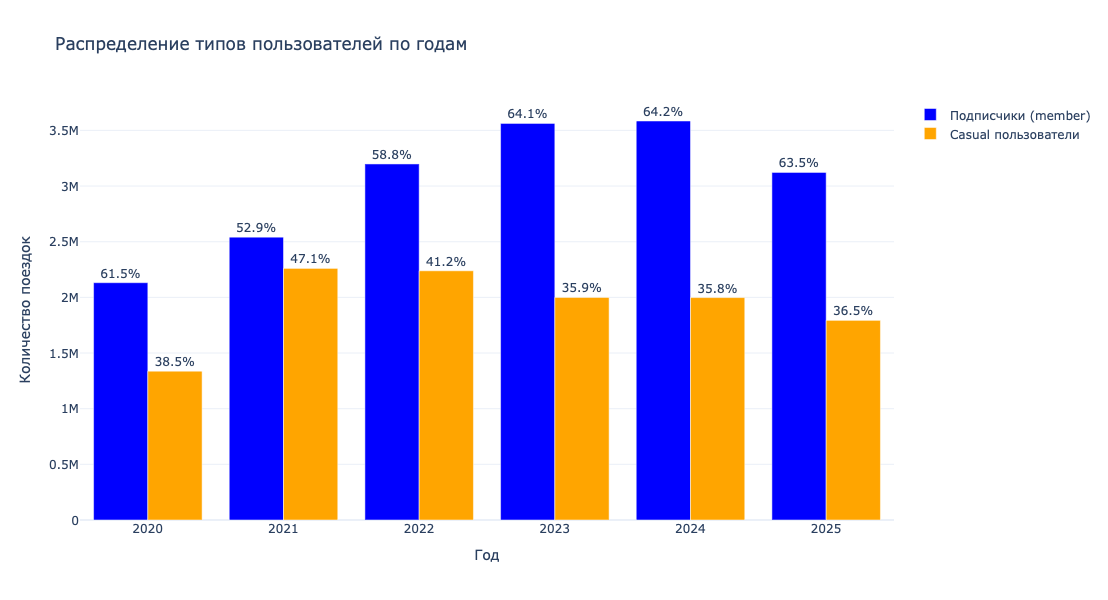


ГРАФИК 2: Активность по часам суток
✅ График 2 сохранен: /Users/vsevolod/Desktop/divvy-bikes-analysis/visualizations/2_hourly_activity_2025.html


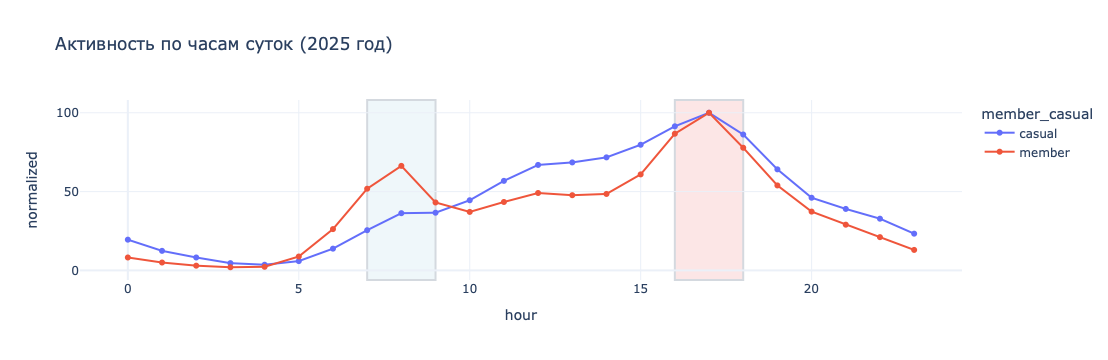


СОЗДАНИЕ ГРАФИКА 3: Сезонность по месяцам (2025 год)
Данные загружены: 22 строк
Столбцы: ['month', 'member_casual', 'trip_count', 'avg_duration_min']
✅ График сохранен как HTML: /Users/vsevolod/Desktop/divvy-bikes-analysis/visualizations/3_seasonal_patterns_2025.html


/var/folders/m_/0vg5klms5wqfl8z1jkpk95tr0000gn/T/ipykernel_10081/3776456458.py:182: DeprecationWarning:


Support for the 'engine' argument is deprecated and will be removed after September 2025.
Kaleido will be the only supported engine at that time.




✅ График сохранен как PNG: /Users/vsevolod/Desktop/divvy-bikes-analysis/visualizations/3_seasonal_patterns_2025.png


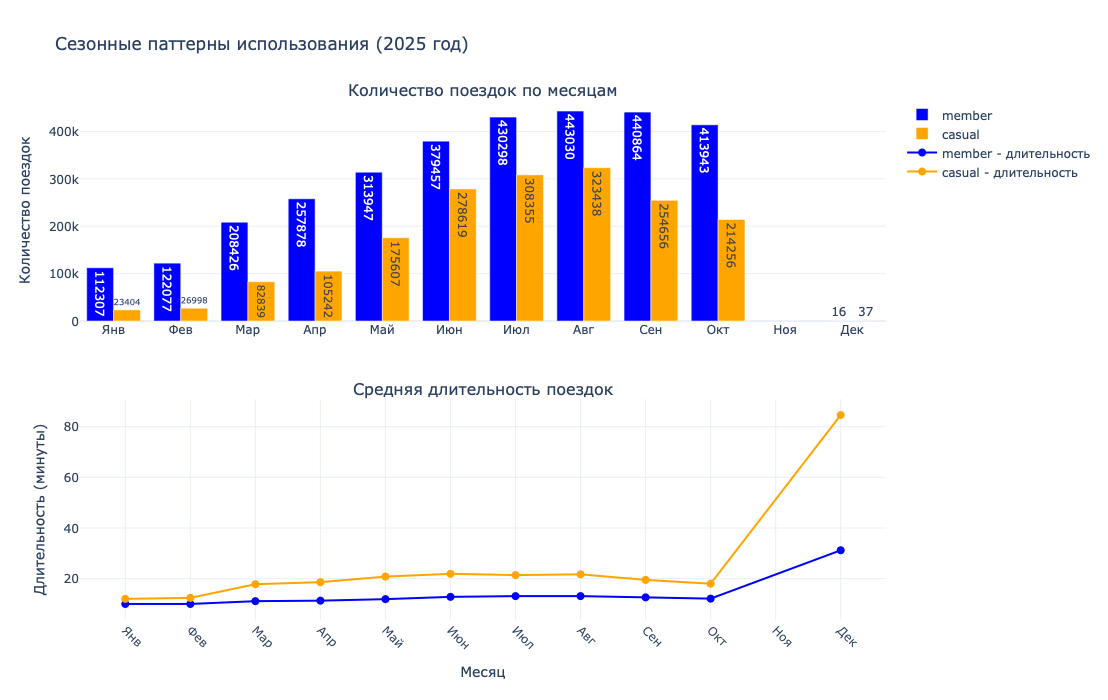


📊 Сводная статистика по месяцам (2025 год):
shape: (11, 3)
┌───────┬────────┬────────┐
│ month ┆ casual ┆ member │
│ ---   ┆ ---    ┆ ---    │
│ i8    ┆ u32    ┆ u32    │
╞═══════╪════════╪════════╡
│ 1     ┆ 23404  ┆ 112307 │
│ 2     ┆ 26998  ┆ 122077 │
│ 3     ┆ 82839  ┆ 208426 │
│ 4     ┆ 105242 ┆ 257878 │
│ 5     ┆ 175607 ┆ 313947 │
│ …     ┆ …      ┆ …      │
│ 7     ┆ 308355 ┆ 430298 │
│ 8     ┆ 323438 ┆ 443030 │
│ 9     ┆ 254656 ┆ 440864 │
│ 10    ┆ 214256 ┆ 413943 │
│ 12    ┆ 37     ┆ 16     │
└───────┴────────┴────────┘

СОЗДАНИЕ ГРАФИКА 4: Активность по дням недели (2025 год)
Данные загружены: 14 строк
✅ График сохранен как HTML: /Users/vsevolod/Desktop/divvy-bikes-analysis/visualizations/4_weekday_patterns_2025.html


/var/folders/m_/0vg5klms5wqfl8z1jkpk95tr0000gn/T/ipykernel_10081/3776456458.py:192: DeprecationWarning:

the argument `columns` for `DataFrame.pivot` is deprecated. It was renamed to `on` in version 1.0.0.

/var/folders/m_/0vg5klms5wqfl8z1jkpk95tr0000gn/T/ipykernel_10081/3776456458.py:309: DeprecationWarning:


Support for the 'engine' argument is deprecated and will be removed after September 2025.
Kaleido will be the only supported engine at that time.




✅ График сохранен как PNG: /Users/vsevolod/Desktop/divvy-bikes-analysis/visualizations/4_weekday_patterns_2025.png



📊 Данные по дням недели (2025 год):
shape: (7, 3)
┌─────────┬────────┬────────┐
│ weekday ┆ casual ┆ member │
│ ---     ┆ ---    ┆ ---    │
│ i8      ┆ u32    ┆ u32    │
╞═════════╪════════╪════════╡
│ 1       ┆ 206648 ┆ 441643 │
│ 2       ┆ 201979 ┆ 492399 │
│ 3       ┆ 197362 ┆ 478848 │
│ 4       ┆ 232731 ┆ 510887 │
│ 5       ┆ 287017 ┆ 465816 │
│ 6       ┆ 367830 ┆ 392327 │
│ 7       ┆ 299884 ┆ 340323 │
└─────────┴────────┴────────┘

СОЗДАНИЕ ГРАФИКА 5: Карта топ-20 станций (2025 год)
Ошибка при сборе данных: unable to find column "started_at"; valid columns: ["start_station_name", "start_lat", "start_lng"]

Resolved plan until failure:

	---> FAILED HERE RESOLVING 'sink' <---
SELECT [col("start_station_name"), col("start_lat"), col("start_lng")]
  Parquet SCAN [/Users/vsevolod/Desktop/divvy-bikes-analysis/data/processed/2025/rides_2025_optimized_filled.parquet]
  PROJECT */22 COLUMNS
  ESTIMATED ROWS: 4916696
❌ Нет данных о станциях для построения карты

✅ ВСЕ ГРАФИКИ УСПЕШНО СОЗД

/var/folders/m_/0vg5klms5wqfl8z1jkpk95tr0000gn/T/ipykernel_10081/3776456458.py:319: DeprecationWarning:

the argument `columns` for `DataFrame.pivot` is deprecated. It was renamed to `on` in version 1.0.0.



In [6]:
import polars as pl
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
import os

pio.templates.default = "plotly_white"

# ============================================================================
# КОНФИГУРАЦИЯ
# ============================================================================

DATA_PATHS = {
    2020: "/Users/vsevolod/Desktop/divvy-bikes-analysis/data/processed/2020/rides_2020_optimized_filled.parquet",
    2021: "/Users/vsevolod/Desktop/divvy-bikes-analysis/data/processed/2021/rides_2021_optimized_filled.parquet",
    2022: "/Users/vsevolod/Desktop/divvy-bikes-analysis/data/processed/2022/rides_2022_optimized_filled.parquet",
    2023: "/Users/vsevolod/Desktop/divvy-bikes-analysis/data/processed/2023/rides_2023_optimized_filled.parquet",
    2024: "/Users/vsevolod/Desktop/divvy-bikes-analysis/data/processed/2024/rides_2024_optimized_filled.parquet",
    2025: "/Users/vsevolod/Desktop/divvy-bikes-analysis/data/processed/2025/rides_2025_optimized_filled.parquet"
}

SAVE_DIR = "/Users/vsevolod/Desktop/divvy-bikes-analysis/visualizations"
os.makedirs(SAVE_DIR, exist_ok=True)

# ============================================================================
# ОБЩИЕ ФУНКЦИИ ДЛЯ ЗАГРУЗКИ ДАННЫХ (ИСПРАВЛЕННЫЕ)
# ============================================================================

def load_year_data(year, columns=None):
    """Загружает данные за конкретный год с ленивой обработкой"""
    if year not in DATA_PATHS:
        return None
    
    path = DATA_PATHS[year]
    if not os.path.exists(path):
        return None
    
    # Базовые колонки, которые всегда нужны
    base_columns = ["started_at", "ended_at", "member_casual", "rideable_type"]
    
    if columns:
        # Добавляем запрошенные колонки, если они существуют
        available_columns = base_columns + ["start_station_name", "end_station_name", "start_lat", "start_lng"]
        base_columns = [col for col in columns if col in available_columns]
    
    # Ленивая загрузка
    lf = pl.scan_parquet(path).select(base_columns)
    
    # Добавляем вычисляемые колонки
    lf = lf.with_columns([
        pl.lit(year).alias("year"),
        pl.col("started_at").dt.month().alias("month"),
        pl.col("started_at").dt.hour().alias("hour"),
        pl.col("started_at").dt.weekday().alias("weekday"),
        ((pl.col("ended_at") - pl.col("started_at")).dt.total_seconds()).alias("duration_sec")
    ])
    
    # Фильтруем аномалии
    lf = lf.filter(
        (pl.col("duration_sec") > 60) & 
        (pl.col("duration_sec") < 24 * 3600)
    )
    
    return lf

def collect_safely(lazy_frame):
    """Безопасный сбор данных с обработкой ошибок"""
    try:
        return lazy_frame.collect()
    except Exception as e:
        print(f"Ошибка при сборе данных: {e}")
        return None

# ============================================================================
# ГРАФИК 3: Сезонность по месяцам (ИСПРАВЛЕННЫЙ)
# ============================================================================

def plot_seasonal_patterns_fixed(year=2025):
    """График сезонных паттернов по месяцам - исправленная версия"""
    print("\n" + "=" * 70)
    print(f"СОЗДАНИЕ ГРАФИКА 3: Сезонность по месяцам ({year} год)")
    print("=" * 70)
    
    lf = load_year_data(year)
    if lf is None:
        print(f"❌ Нет данных за {year} год")
        return None
    
    # Агрегируем данные по месяцам и типу пользователя
    query = lf.group_by(["month", "member_casual"]).agg([
        pl.len().alias("trip_count"),
        (pl.col("duration_sec") / 60).mean().round(1).alias("avg_duration_min")
    ]).sort(["month", "member_casual"])
    
    data = collect_safely(query)
    if data is None or data.height == 0:
        print("❌ Нет данных для построения графика")
        return None
    
    print(f"Данные загружены: {data.height} строк")
    print(f"Столбцы: {data.columns}")
    
    # Просто сортируем по месяцу
    data = data.sort("month")
    
    # Создаем subplot
    fig = make_subplots(
        rows=2, cols=1,
        subplot_titles=("Количество поездок по месяцам", "Средняя длительность поездок"),
        vertical_spacing=0.15
    )
    
    # Создаем простой список месяцев для осей
    months_russian = ["Янв", "Фев", "Мар", "Апр", "Май", "Июн", "Июл", "Авг", "Сен", "Окт", "Ноя", "Дек"]
    
    # График 1: Количество поездок
    for member_type, color in [("member", "blue"), ("casual", "orange")]:
        subset = data.filter(pl.col("member_casual") == member_type)
        # Конвертируем в pandas для работы с Plotly
        subset_pd = subset.to_pandas()
        fig.add_trace(
            go.Bar(
                x=subset_pd["month"],
                y=subset_pd["trip_count"],
                name=member_type,
                marker_color=color,
                text=subset_pd["trip_count"],
                textposition="auto"
            ),
            row=1, col=1
        )
    
    # График 2: Длительность поездок
    for member_type, color in [("member", "blue"), ("casual", "orange")]:
        subset = data.filter(pl.col("member_casual") == member_type)
        subset_pd = subset.to_pandas()
        fig.add_trace(
            go.Scatter(
                x=subset_pd["month"],
                y=subset_pd["avg_duration_min"],
                name=f"{member_type} - длительность",
                mode="lines+markers",
                line=dict(color=color, width=2),
                marker=dict(size=8)
            ),
            row=2, col=1
        )
    
    # Обновляем оси X с русскими названиями месяцев
    fig.update_xaxes(
        tickvals=list(range(1, 13)),
        ticktext=months_russian,
        row=1, col=1
    )
    fig.update_xaxes(
        tickvals=list(range(1, 13)),
        ticktext=months_russian,
        title_text="Месяц",
        row=2, col=1,
        tickangle=45
    )
    
    fig.update_layout(
        title=f"Сезонные паттерны использования ({year} год)",
        height=700,
        showlegend=True,
        barmode="group"
    )
    
    fig.update_yaxes(title_text="Количество поездок", row=1, col=1)
    fig.update_yaxes(title_text="Длительность (минуты)", row=2, col=1)
    
    # Сохраняем график
    save_path_html = os.path.join(SAVE_DIR, f"3_seasonal_patterns_{year}.html")
    save_path_png = os.path.join(SAVE_DIR, f"3_seasonal_patterns_{year}.png")
    
    fig.write_html(save_path_html)
    print(f"✅ График сохранен как HTML: {save_path_html}")
    
    try:
        fig.write_image(save_path_png, width=1200, height=700, engine="kaleido")
        print(f"✅ График сохранен как PNG: {save_path_png}")
    except Exception as e:
        print(f"⚠️  Не удалось сохранить PNG: {e}")
    
    # Показываем график
    fig.show()
    
    # Выводим сводную таблицу
    print(f"\n📊 Сводная статистика по месяцам ({year} год):")
    pivot_table = data.pivot(
        values="trip_count",
        index="month",
        columns="member_casual",
        aggregate_function="first"
    ).fill_null(0)
    print(pivot_table)
    
    return fig

# ============================================================================
# ГРАФИК 4: Активность по дням недели (ИСПРАВЛЕННЫЙ)
# ============================================================================

def plot_weekday_patterns_fixed(year=2025):
    """График активности по дням недели - исправленная версия"""
    print("\n" + "=" * 70)
    print(f"СОЗДАНИЕ ГРАФИКА 4: Активность по дням недели ({year} год)")
    print("=" * 70)
    
    lf = load_year_data(year)
    if lf is None:
        print(f"❌ Нет данных за {year} год")
        return None
    
    # Агрегируем данные по дням недели и типу пользователя
    query = lf.group_by(["weekday", "member_casual"]).agg([
        pl.len().alias("trip_count"),
        (pl.col("duration_sec") / 60).mean().round(1).alias("avg_duration_min")
    ])
    
    data = collect_safely(query)
    if data is None or data.height == 0:
        print("❌ Нет данных для построения графика")
        return None
    
    print(f"Данные загружены: {data.height} строк")
    
    # Просто сортируем по дню недели
    data = data.sort("weekday")
    
    # Создаем два отдельных графика
    fig = make_subplots(
        rows=1, cols=2,
        subplot_titles=("Количество поездок по дням недели", "Средняя длительность поездок"),
        horizontal_spacing=0.15
    )
    
    # Названия дней недели
    days_russian = ["Пн", "Вт", "Ср", "Чт", "Пт", "Сб", "Вс"]
    
    # График 1: Количество поездок
    for member_type, color in [("member", "blue"), ("casual", "orange")]:
        subset = data.filter(pl.col("member_casual") == member_type)
        subset_pd = subset.to_pandas()
        fig.add_trace(
            go.Bar(
                x=subset_pd["weekday"],
                y=subset_pd["trip_count"],
                name=member_type,
                marker_color=color,
                text=subset_pd["trip_count"],
                textposition="auto"
            ),
            row=1, col=1
        )
    
    # График 2: Длительность поездок
    for member_type, color in [("member", "blue"), ("casual", "orange")]:
        subset = data.filter(pl.col("member_casual") == member_type)
        subset_pd = subset.to_pandas()
        fig.add_trace(
            go.Scatter(
                x=subset_pd["weekday"],
                y=subset_pd["avg_duration_min"],
                name=member_type,
                mode="lines+markers",
                line=dict(color=color, width=2),
                marker=dict(size=8)
            ),
            row=1, col=2
        )
    
    fig.update_layout(
        title=f"Активность по дням недели ({year} год)",
        height=500,
        showlegend=True,
        barmode="group"
    )
    
    # Обновляем оси X с русскими названиями дней
    fig.update_xaxes(
        tickvals=list(range(1, 8)),
        ticktext=days_russian,
        title_text="День недели",
        row=1, col=1,
        tickangle=45
    )
    fig.update_xaxes(
        tickvals=list(range(1, 8)),
        ticktext=days_russian,
        title_text="День недели",
        row=1, col=2,
        tickangle=45
    )
    
    fig.update_yaxes(title_text="Количество поездок", row=1, col=1)
    fig.update_yaxes(title_text="Длительность (минуты)", row=1, col=2)
    
    # Сохраняем график
    save_path_html = os.path.join(SAVE_DIR, f"4_weekday_patterns_{year}.html")
    save_path_png = os.path.join(SAVE_DIR, f"4_weekday_patterns_{year}.png")
    
    fig.write_html(save_path_html)
    print(f"✅ График сохранен как HTML: {save_path_html}")
    
    try:
        fig.write_image(save_path_png, width=1200, height=500, engine="kaleido")
        print(f"✅ График сохранен как PNG: {save_path_png}")
    except Exception as e:
        print(f"⚠️  Не удалось сохранить PNG: {e}")
    
    # Показываем график
    fig.show()
    
    # Выводим таблицу с данными
    print(f"\n📊 Данные по дням недели ({year} год):")
    pivot_table = data.pivot(
        values="trip_count",
        index="weekday",
        columns="member_casual",
        aggregate_function="first"
    ).fill_null(0)
    print(pivot_table)
    
    return fig

# ============================================================================
# ОСТАЛЬНЫЕ ФУНКЦИИ ОСТАЮТСЯ БЕЗ ИЗМЕНЕНИЙ (используем как есть)
# ============================================================================

# ГРАФИК 5: Карта популярных станций (ИСПРАВЛЕННЫЙ)
def plot_top_stations_map_fixed(year=2025, top_n=20):
    """Карта топ-N популярных станций отправления - исправленная версия"""
    print("\n" + "=" * 70)
    print(f"СОЗДАНИЕ ГРАФИКА 5: Карта топ-{top_n} станций ({year} год)")
    print("=" * 70)
    
    # Загружаем данные с координатами
    lf = load_year_data(year, columns=["start_station_name", "start_lat", "start_lng"])
    if lf is None:
        print(f"❌ Нет данных за {year} год")
        return None
    
    # Фильтруем станции без координат
    lf = lf.filter(
        pl.col("start_station_name").is_not_null() &
        (pl.col("start_station_name") != "Non-Station Parking") &
        pl.col("start_lat").is_not_null() &
        pl.col("start_lng").is_not_null()
    )
    
    # Агрегируем данные по станциям
    query = lf.group_by(["start_station_name", "start_lat", "start_lng"]).agg([
        pl.len().alias("departures")
    ]).sort("departures", descending=True).head(top_n)
    
    data = collect_safely(query)
    if data is None or data.height == 0:
        print("❌ Нет данных о станциях для построения карты")
        return None
    
    # Создаем карту
    fig = px.scatter_mapbox(
        data.to_pandas(),
        lat="start_lat",
        lon="start_lng",
        size="departures",
        color="departures",
        hover_name="start_station_name",
        hover_data={"departures": True, "start_lat": False, "start_lng": False},
        size_max=30,
        zoom=10,
        mapbox_style="carto-positron",
        title=f"Топ-{top_n} станций отправления ({year} год)",
        color_continuous_scale="Viridis"
    )
    
    # Центрируем на Чикаго
    fig.update_layout(
        mapbox=dict(
            center=dict(lat=41.8781, lon=-87.6298),
            zoom=10
        ),
        height=600
    )
    
    # Сохраняем график
    save_path_html = os.path.join(SAVE_DIR, f"5_top_stations_{year}.html")
    save_path_png = os.path.join(SAVE_DIR, f"5_top_stations_{year}.png")
    
    fig.write_html(save_path_html)
    print(f"✅ График сохранен как HTML: {save_path_html}")
    
    try:
        fig.write_image(save_path_png, width=1200, height=600, engine="kaleido")
        print(f"✅ График сохранен как PNG: {save_path_png}")
    except Exception as e:
        print(f"⚠️  Не удалось сохранить PNG: {e}")
    
    # Показываем график
    fig.show()
    
    # Выводим таблицу с топ-10 станций
    print(f"\n🚲 Топ-10 станций {year} года:")
    for i, row in enumerate(data.head(10).iter_rows(named=True), 1):
        print(f"{i:2}. {row['start_station_name']}: {row['departures']:,} поездок")
    
    # Дополнительная статистика
    total_departures = data["departures"].sum()
    avg_departures = data["departures"].mean()
    
    print(f"\n📈 Статистика станций:")
    print(f"   • Всего поездок с топ-{top_n} станций: {total_departures:,}")
    print(f"   • Среднее количество поездок на станцию: {avg_departures:.0f}")
    print(f"   • Самая популярная станция: {data['start_station_name'][0]} ({data['departures'][0]:,} поездок)")
    
    return fig

# ============================================================================
# ФУНКЦИЯ ДЛЯ СОЗДАНИЯ ВСЕХ ГРАФИКОВ (ИСПРАВЛЕННАЯ)
# ============================================================================

def create_all_visualizations_fixed():
    """Создает все графики по очереди - исправленная версия"""
    print("=" * 70)
    print("НАЧАЛО СОЗДАНИЯ ВСЕХ ВИЗУАЛИЗАЦИЙ (ИСПРАВЛЕННЫЙ КОД)")
    print("=" * 70)
    
    # Создаем папку для визуализаций
    os.makedirs(SAVE_DIR, exist_ok=True)
    
    # График 1: Распределение по годам
    print("\n" + "=" * 70)
    print("ГРАФИК 1: Распределение по годам")
    print("=" * 70)
    
    def plot_membership_by_year_fixed():
        years = list(DATA_PATHS.keys())
        all_results = []
        
        for year in years:
            print(f"Обрабатываю {year} год...")
            lf = load_year_data(year)
            if lf is None:
                continue
            
            query = lf.group_by("member_casual").agg([
                pl.len().alias("count")
            ]).with_columns(pl.lit(year).alias("year"))
            
            result = collect_safely(query)
            if result is not None:
                all_results.append(result)
        
        if not all_results:
            return None
        
        combined = pl.concat(all_results)
        
        # Используем pivot для создания таблицы
        pivot_data = combined.pivot(
            values="count",
            index="year",
            on="member_casual",  # Используем on вместо columns
            aggregate_function="sum"
        ).fill_null(0)
        
        # Вычисляем проценты
        pivot_data = pivot_data.with_columns([
            (pl.col("member") / (pl.col("member") + pl.col("casual")) * 100).round(1).alias("member_pct"),
            (pl.col("casual") / (pl.col("member") + pl.col("casual")) * 100).round(1).alias("casual_pct")
        ])
        
        # Создаем график
        fig = go.Figure()
        
        fig.add_trace(go.Bar(
            x=pivot_data["year"],
            y=pivot_data["member"],
            name="Подписчики (member)",
            marker_color="blue",
            text=pivot_data["member_pct"],
            texttemplate="%{text:.1f}%",
            textposition="outside"
        ))
        
        fig.add_trace(go.Bar(
            x=pivot_data["year"],
            y=pivot_data["casual"],
            name="Casual пользователи",
            marker_color="orange",
            text=pivot_data["casual_pct"],
            texttemplate="%{text:.1f}%",
            textposition="outside"
        ))
        
        fig.update_layout(
            title="Распределение типов пользователей по годам",
            xaxis_title="Год",
            yaxis_title="Количество поездок",
            barmode="group",
            height=600,
            showlegend=True
        )
        
        # Сохраняем
        save_path_html = os.path.join(SAVE_DIR, "1_membership_by_year.html")
        save_path_png = os.path.join(SAVE_DIR, "1_membership_by_year.png")
        
        fig.write_html(save_path_html)
        print(f"✅ График 1 сохранен как HTML: {save_path_html}")
        
        try:
            fig.write_image(save_path_png, width=1200, height=600)
            print(f"✅ График 1 сохранен как PNG: {save_path_png}")
        except Exception as e:
            print(f"⚠️  Не удалось сохранить PNG: {e}")
        
        fig.show()
        return fig
    
    plot_membership_by_year_fixed()
    
    # График 2: Активность по часам
    print("\n" + "=" * 70)
    print("ГРАФИК 2: Активность по часам суток")
    print("=" * 70)
    
    def plot_hourly_activity_fixed(year=2025):
        lf = load_year_data(year)
        if lf is None:
            return None
        
        query = lf.group_by(["hour", "member_casual"]).agg([
            pl.len().alias("trip_count")
        ]).sort(["hour", "member_casual"])
        
        data = collect_safely(query)
        if data is None:
            return None
        
        # Нормализуем данные
        max_by_type = data.group_by("member_casual").agg([
            pl.col("trip_count").max().alias("max_count")
        ])
        
        data = data.join(max_by_type, on="member_casual")
        data = data.with_columns([
            (pl.col("trip_count") / pl.col("max_count") * 100).round(1).alias("normalized")
        ])
        
        fig = px.line(
            data.to_pandas(),
            x="hour",
            y="normalized",
            color="member_casual",
            title=f"Активность по часам суток ({year} год)",
            markers=True
        )
        
        # Добавляем выделение пиковых часов
        fig.add_vrect(x0=7, x1=9, fillcolor="lightblue", opacity=0.2, layer="below")
        fig.add_vrect(x0=16, x1=18, fillcolor="lightcoral", opacity=0.2, layer="below")
        
        save_path = os.path.join(SAVE_DIR, f"2_hourly_activity_{year}.html")
        fig.write_html(save_path)
        print(f"✅ График 2 сохранен: {save_path}")
        
        fig.show()
        return fig
    
    plot_hourly_activity_fixed(2025)
    
    # График 3: Сезонность по месяцам (исправленный)
    plot_seasonal_patterns_fixed(year=2025)
    
    # График 4: Активность по дням недели (исправленный)
    plot_weekday_patterns_fixed(year=2025)
    
    # График 5: Карта станций (исправленный)
    plot_top_stations_map_fixed(year=2025, top_n=20)
    
    print("\n" + "=" * 70)
    print("✅ ВСЕ ГРАФИКИ УСПЕШНО СОЗДАНЫ И СОХРАНЕНЫ")
    print(f"📁 Файлы сохранены в: {SAVE_DIR}")
    print("=" * 70)

# ============================================================================
# ЗАПУСК ПРОГРАММЫ
# ============================================================================

if __name__ == "__main__":
    print("=" * 70)
    print("ВИЗУАЛИЗАЦИЯ ДАННЫХ DIVVY BIKES (ИСПРАВЛЕННЫЙ КОД)")
    print("=" * 70)
    
    print("\nЗапускаю исправленную версию всех графиков...")
    create_all_visualizations_fixed()

ВИЗУАЛИЗАЦИЯ ДАННЫХ DIVVY BIKES (ИСПРАВЛЕННЫЙ КОД)

📅 Анализируем данные за 2020 год
Запускаю исправленную версию всех графиков...
НАЧАЛО СОЗДАНИЯ ВСЕХ ВИЗУАЛИЗАЦИЙ (ИСПРАВЛЕННЫЙ КОД)
📅 Год для анализа: 2020

ГРАФИК 1: Распределение по годам
Обрабатываю 2020 год...
Обрабатываю 2021 год...
Обрабатываю 2022 год...
Обрабатываю 2023 год...
Обрабатываю 2024 год...
Обрабатываю 2025 год...
✅ График 1 сохранен как HTML: /Users/vsevolod/Desktop/divvy-bikes-analysis/visualizations/1_membership_by_year.html
✅ График 1 сохранен как PNG: /Users/vsevolod/Desktop/divvy-bikes-analysis/visualizations/1_membership_by_year.png


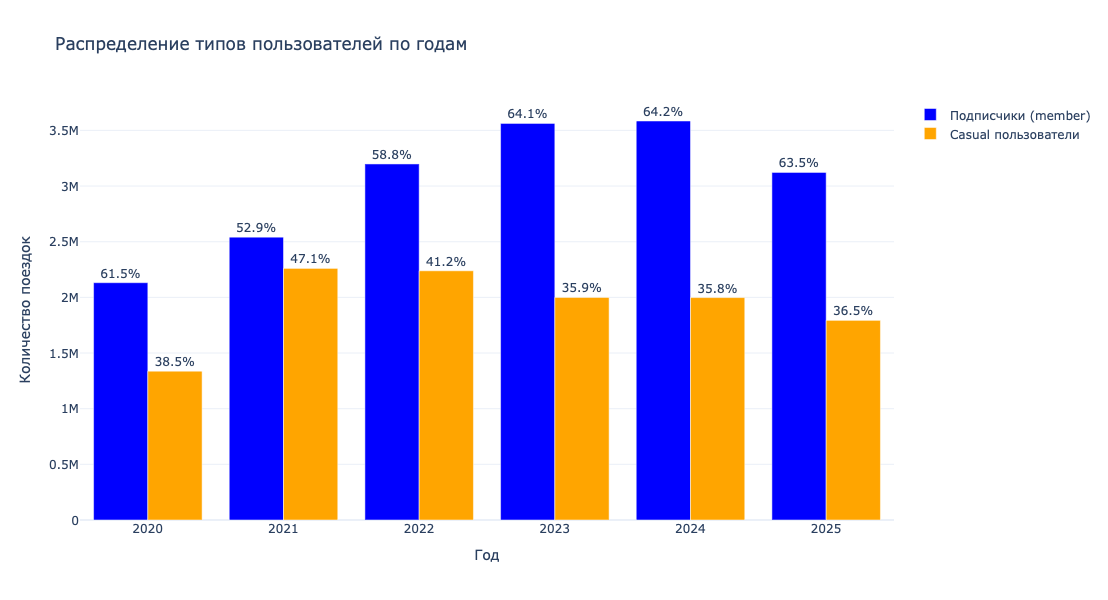


ГРАФИК 2: Активность по часам суток (2020 год)
✅ График сохранен как HTML: /Users/vsevolod/Desktop/divvy-bikes-analysis/visualizations/2_hourly_activity_2020.html


/var/folders/m_/0vg5klms5wqfl8z1jkpk95tr0000gn/T/ipykernel_10081/2315016744.py:143: DeprecationWarning:


Support for the 'engine' argument is deprecated and will be removed after September 2025.
Kaleido will be the only supported engine at that time.




✅ График сохранен как PNG: /Users/vsevolod/Desktop/divvy-bikes-analysis/visualizations/2_hourly_activity_2020.png


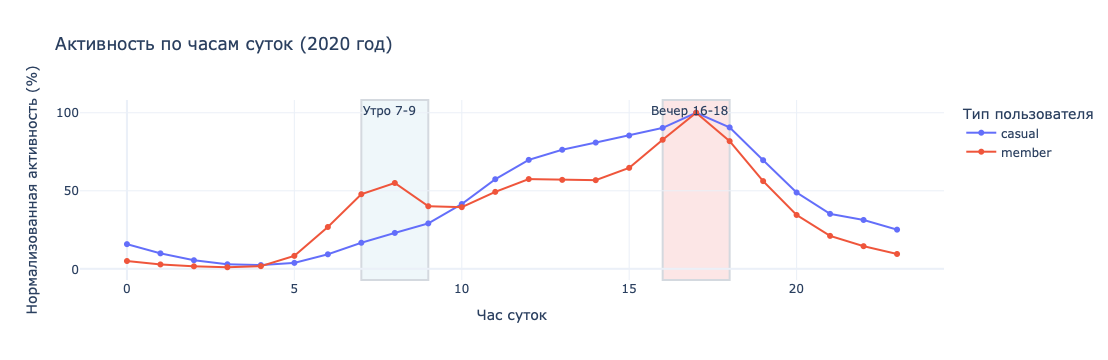


📊 Статистика активности по часам (2020 год):
   • member: пиковый час - 17:00 (232,848 поездок)
   • casual: пиковый час - 17:00 (130,957 поездок)

СОЗДАНИЕ ГРАФИКА 3: Сезонность по месяцам (2020 год)
Данные загружены: 24 строк
Столбцы: ['month', 'member_casual', 'trip_count', 'avg_duration_min']
✅ График сохранен как HTML: /Users/vsevolod/Desktop/divvy-bikes-analysis/visualizations/3_seasonal_patterns_2020.html


/var/folders/m_/0vg5klms5wqfl8z1jkpk95tr0000gn/T/ipykernel_10081/2315016744.py:272: DeprecationWarning:


Support for the 'engine' argument is deprecated and will be removed after September 2025.
Kaleido will be the only supported engine at that time.




✅ График сохранен как PNG: /Users/vsevolod/Desktop/divvy-bikes-analysis/visualizations/3_seasonal_patterns_2020.png


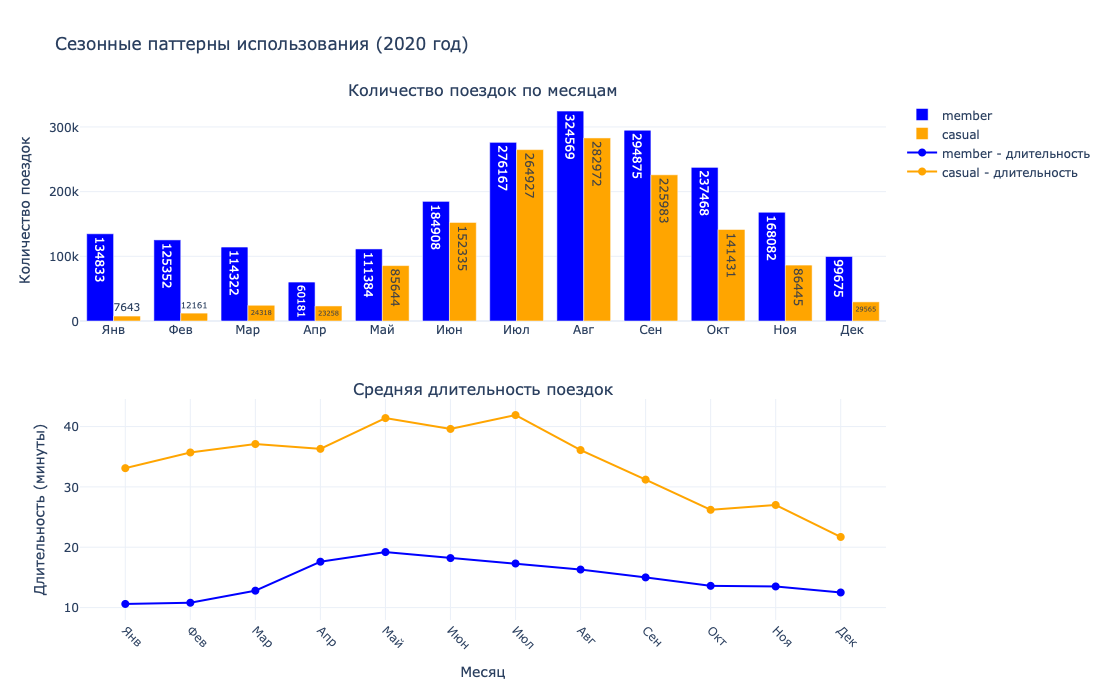


📊 Сводная статистика по месяцам (2020 год):
shape: (12, 3)
┌───────┬────────┬────────┐
│ month ┆ casual ┆ member │
│ ---   ┆ ---    ┆ ---    │
│ i8    ┆ u32    ┆ u32    │
╞═══════╪════════╪════════╡
│ 1     ┆ 7643   ┆ 134833 │
│ 2     ┆ 12161  ┆ 125352 │
│ 3     ┆ 24318  ┆ 114322 │
│ 4     ┆ 23258  ┆ 60181  │
│ 5     ┆ 85644  ┆ 111384 │
│ …     ┆ …      ┆ …      │
│ 8     ┆ 282972 ┆ 324569 │
│ 9     ┆ 225983 ┆ 294875 │
│ 10    ┆ 141431 ┆ 237468 │
│ 11    ┆ 86445  ┆ 168082 │
│ 12    ┆ 29565  ┆ 99675  │
└───────┴────────┴────────┘

СОЗДАНИЕ ГРАФИКА 4: Активность по дням недели (2020 год)
Данные загружены: 14 строк
✅ График сохранен как HTML: /Users/vsevolod/Desktop/divvy-bikes-analysis/visualizations/4_weekday_patterns_2020.html


/var/folders/m_/0vg5klms5wqfl8z1jkpk95tr0000gn/T/ipykernel_10081/2315016744.py:399: DeprecationWarning:


Support for the 'engine' argument is deprecated and will be removed after September 2025.
Kaleido will be the only supported engine at that time.




✅ График сохранен как PNG: /Users/vsevolod/Desktop/divvy-bikes-analysis/visualizations/4_weekday_patterns_2020.png


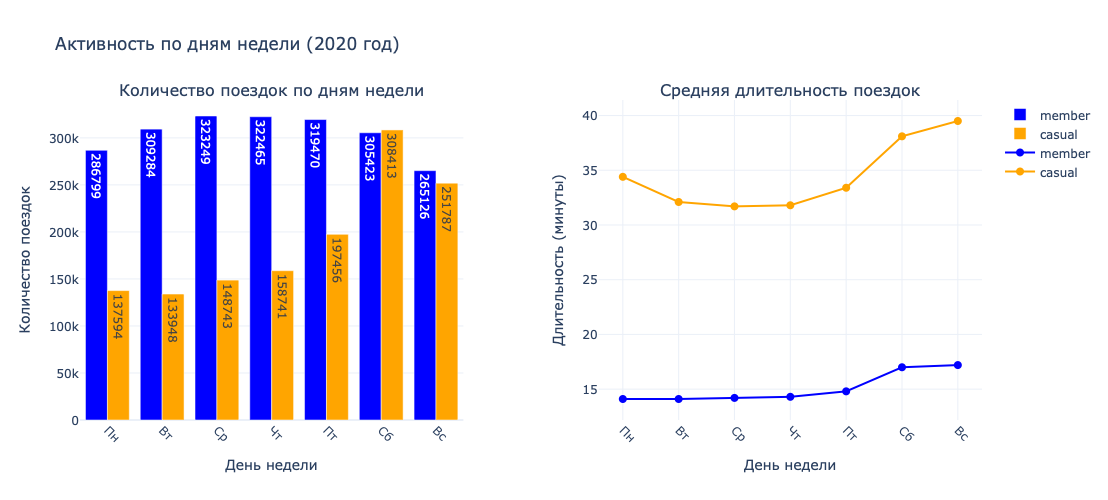


📊 Данные по дням недели (2020 год):
shape: (7, 3)
┌─────────┬────────┬────────┐
│ weekday ┆ casual ┆ member │
│ ---     ┆ ---    ┆ ---    │
│ i8      ┆ u32    ┆ u32    │
╞═════════╪════════╪════════╡
│ 1       ┆ 137594 ┆ 286799 │
│ 2       ┆ 133948 ┆ 309284 │
│ 3       ┆ 148743 ┆ 323249 │
│ 4       ┆ 158741 ┆ 322465 │
│ 5       ┆ 197456 ┆ 319470 │
│ 6       ┆ 308413 ┆ 305423 │
│ 7       ┆ 251787 ┆ 265126 │
└─────────┴────────┴────────┘

СОЗДАНИЕ ГРАФИКА 5: Карта топ-20 станций (2020 год)
Ошибка при сборе данных: unable to find column "started_at"; valid columns: ["start_station_name", "start_lat", "start_lng"]

Resolved plan until failure:

	---> FAILED HERE RESOLVING 'sink' <---
SELECT [col("start_station_name"), col("start_lat"), col("start_lng")]
  Parquet SCAN [/Users/vsevolod/Desktop/divvy-bikes-analysis/data/processed/2020/rides_2020_optimized_filled.parquet]
  PROJECT */27 COLUMNS
  ESTIMATED ROWS: 3468881
❌ Нет данных о станциях для построения карты

СОЗДАНИЕ ГРАФИКА 6: Эволюц

In [7]:
import polars as pl
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
import os

pio.templates.default = "plotly_white"

# ============================================================================
# КОНФИГУРАЦИЯ
# ============================================================================

DATA_PATHS = {
    2020: "/Users/vsevolod/Desktop/divvy-bikes-analysis/data/processed/2020/rides_2020_optimized_filled.parquet",
    2021: "/Users/vsevolod/Desktop/divvy-bikes-analysis/data/processed/2021/rides_2021_optimized_filled.parquet",
    2022: "/Users/vsevolod/Desktop/divvy-bikes-analysis/data/processed/2022/rides_2022_optimized_filled.parquet",
    2023: "/Users/vsevolod/Desktop/divvy-bikes-analysis/data/processed/2023/rides_2023_optimized_filled.parquet",
    2024: "/Users/vsevolod/Desktop/divvy-bikes-analysis/data/processed/2024/rides_2024_optimized_filled.parquet",
    2025: "/Users/vsevolod/Desktop/divvy-bikes-analysis/data/processed/2025/rides_2025_optimized_filled.parquet"
}

SAVE_DIR = "/Users/vsevolod/Desktop/divvy-bikes-analysis/visualizations"
os.makedirs(SAVE_DIR, exist_ok=True)

# ============================================================================
# НАСТРОЙКА ГОДА ДЛЯ ВСЕХ ГРАФИКОВ
# ============================================================================

# ЗДЕСЬ МОЖНО ИЗМЕНИТЬ ГОД ДЛЯ ВСЕХ ГРАФИКОВ
SELECTED_YEAR = 2020  # Измените на нужный год (2020-2025)

# ============================================================================
# ОБЩИЕ ФУНКЦИИ ДЛЯ ЗАГРУЗКИ ДАННЫХ (ИСПРАВЛЕННЫЕ)
# ============================================================================

def load_year_data(year, columns=None):
    """Загружает данные за конкретный год с ленивой обработкой"""
    if year not in DATA_PATHS:
        return None
    
    path = DATA_PATHS[year]
    if not os.path.exists(path):
        return None
    
    # Базовые колонки, которые всегда нужны
    base_columns = ["started_at", "ended_at", "member_casual", "rideable_type"]
    
    if columns:
        # Добавляем запрошенные колонки, если они существуют
        available_columns = base_columns + ["start_station_name", "end_station_name", "start_lat", "start_lng"]
        base_columns = [col for col in columns if col in available_columns]
    
    # Ленивая загрузка
    lf = pl.scan_parquet(path).select(base_columns)
    
    # Добавляем вычисляемые колонки
    lf = lf.with_columns([
        pl.lit(year).alias("year"),
        pl.col("started_at").dt.month().alias("month"),
        pl.col("started_at").dt.hour().alias("hour"),
        pl.col("started_at").dt.weekday().alias("weekday"),
        ((pl.col("ended_at") - pl.col("started_at")).dt.total_seconds()).alias("duration_sec")
    ])
    
    # Фильтруем аномалии
    lf = lf.filter(
        (pl.col("duration_sec") > 60) & 
        (pl.col("duration_sec") < 24 * 3600)
    )
    
    return lf

def collect_safely(lazy_frame):
    """Безопасный сбор данных с обработкой ошибок"""
    try:
        return lazy_frame.collect()
    except Exception as e:
        print(f"Ошибка при сборе данных: {e}")
        return None

# ============================================================================
# ГРАФИК 2: Активность по часам суток (ИСПРАВЛЕННЫЙ)
# ============================================================================

def plot_hourly_activity_fixed(year=SELECTED_YEAR):
    """График активности по часам суток - исправленная версия"""
    print("\n" + "=" * 70)
    print(f"ГРАФИК 2: Активность по часам суток ({year} год)")
    print("=" * 70)
    
    lf = load_year_data(year)
    if lf is None:
        print(f"❌ Нет данных за {year} год")
        return None
    
    query = lf.group_by(["hour", "member_casual"]).agg([
        pl.len().alias("trip_count")
    ]).sort(["hour", "member_casual"])
    
    data = collect_safely(query)
    if data is None:
        return None
    
    # Нормализуем данные
    max_by_type = data.group_by("member_casual").agg([
        pl.col("trip_count").max().alias("max_count")
    ])
    
    data = data.join(max_by_type, on="member_casual")
    data = data.with_columns([
        (pl.col("trip_count") / pl.col("max_count") * 100).round(1).alias("normalized")
    ])
    
    fig = px.line(
        data.to_pandas(),
        x="hour",
        y="normalized",
        color="member_casual",
        title=f"Активность по часам суток ({year} год)",
        markers=True,
        labels={
            "hour": "Час суток",
            "normalized": "Нормализованная активность (%)",
            "member_casual": "Тип пользователя"
        }
    )
    
    # Добавляем выделение пиковых часов
    fig.add_vrect(x0=7, x1=9, fillcolor="lightblue", opacity=0.2, layer="below", 
                  annotation_text="Утро 7-9", annotation_position="top left")
    fig.add_vrect(x0=16, x1=18, fillcolor="lightcoral", opacity=0.2, layer="below",
                  annotation_text="Вечер 16-18", annotation_position="top right")
    
    # Сохраняем график
    save_path_html = os.path.join(SAVE_DIR, f"2_hourly_activity_{year}.html")
    save_path_png = os.path.join(SAVE_DIR, f"2_hourly_activity_{year}.png")
    
    fig.write_html(save_path_html)
    print(f"✅ График сохранен как HTML: {save_path_html}")
    
    try:
        fig.write_image(save_path_png, width=1200, height=600, engine="kaleido")
        print(f"✅ График сохранен как PNG: {save_path_png}")
    except Exception as e:
        print(f"⚠️  Не удалось сохранить PNG: {e}")
    
    # Показываем график
    fig.show()
    
    # Выводим статистику
    print(f"\n📊 Статистика активности по часам ({year} год):")
    
    # Находим пиковые часы
    for member_type in ["member", "casual"]:
        subset = data.filter(pl.col("member_casual") == member_type)
        peak_hour = subset.sort("trip_count", descending=True).head(1)
        if peak_hour.height > 0:
            hour = peak_hour["hour"][0]
            count = peak_hour["trip_count"][0]
            print(f"   • {member_type}: пиковый час - {hour}:00 ({count:,} поездок)")
    
    return fig

# ============================================================================
# ГРАФИК 3: Сезонность по месяцам (ИСПРАВЛЕННЫЙ)
# ============================================================================

def plot_seasonal_patterns_fixed(year=SELECTED_YEAR):
    """График сезонных паттернов по месяцам - исправленная версия"""
    print("\n" + "=" * 70)
    print(f"СОЗДАНИЕ ГРАФИКА 3: Сезонность по месяцам ({year} год)")
    print("=" * 70)
    
    lf = load_year_data(year)
    if lf is None:
        print(f"❌ Нет данных за {year} год")
        return None
    
    # Агрегируем данные по месяцам и типу пользователя
    query = lf.group_by(["month", "member_casual"]).agg([
        pl.len().alias("trip_count"),
        (pl.col("duration_sec") / 60).mean().round(1).alias("avg_duration_min")
    ]).sort(["month", "member_casual"])
    
    data = collect_safely(query)
    if data is None or data.height == 0:
        print("❌ Нет данных для построения графика")
        return None
    
    print(f"Данные загружены: {data.height} строк")
    print(f"Столбцы: {data.columns}")
    
    # Просто сортируем по месяцу
    data = data.sort("month")
    
    # Создаем subplot
    fig = make_subplots(
        rows=2, cols=1,
        subplot_titles=("Количество поездок по месяцам", "Средняя длительность поездок"),
        vertical_spacing=0.15
    )
    
    # Создаем простой список месяцев для осей
    months_russian = ["Янв", "Фев", "Мар", "Апр", "Май", "Июн", "Июл", "Авг", "Сен", "Окт", "Ноя", "Дек"]
    
    # График 1: Количество поездок
    for member_type, color in [("member", "blue"), ("casual", "orange")]:
        subset = data.filter(pl.col("member_casual") == member_type)
        # Конвертируем в pandas для работы с Plotly
        subset_pd = subset.to_pandas()
        fig.add_trace(
            go.Bar(
                x=subset_pd["month"],
                y=subset_pd["trip_count"],
                name=member_type,
                marker_color=color,
                text=subset_pd["trip_count"],
                textposition="auto"
            ),
            row=1, col=1
        )
    
    # График 2: Длительность поездок
    for member_type, color in [("member", "blue"), ("casual", "orange")]:
        subset = data.filter(pl.col("member_casual") == member_type)
        subset_pd = subset.to_pandas()
        fig.add_trace(
            go.Scatter(
                x=subset_pd["month"],
                y=subset_pd["avg_duration_min"],
                name=f"{member_type} - длительность",
                mode="lines+markers",
                line=dict(color=color, width=2),
                marker=dict(size=8)
            ),
            row=2, col=1
        )
    
    # Обновляем оси X с русскими названиями месяцев
    fig.update_xaxes(
        tickvals=list(range(1, 13)),
        ticktext=months_russian,
        row=1, col=1
    )
    fig.update_xaxes(
        tickvals=list(range(1, 13)),
        ticktext=months_russian,
        title_text="Месяц",
        row=2, col=1,
        tickangle=45
    )
    
    fig.update_layout(
        title=f"Сезонные паттерны использования ({year} год)",
        height=700,
        showlegend=True,
        barmode="group"
    )
    
    fig.update_yaxes(title_text="Количество поездок", row=1, col=1)
    fig.update_yaxes(title_text="Длительность (минуты)", row=2, col=1)
    
    # Сохраняем график
    save_path_html = os.path.join(SAVE_DIR, f"3_seasonal_patterns_{year}.html")
    save_path_png = os.path.join(SAVE_DIR, f"3_seasonal_patterns_{year}.png")
    
    fig.write_html(save_path_html)
    print(f"✅ График сохранен как HTML: {save_path_html}")
    
    try:
        fig.write_image(save_path_png, width=1200, height=700, engine="kaleido")
        print(f"✅ График сохранен как PNG: {save_path_png}")
    except Exception as e:
        print(f"⚠️  Не удалось сохранить PNG: {e}")
    
    # Показываем график
    fig.show()
    
    # Выводим сводную таблицу
    print(f"\n📊 Сводная статистика по месяцам ({year} год):")
    pivot_table = data.pivot(
        values="trip_count",
        index="month",
        on="member_casual",
        aggregate_function="first"
    ).fill_null(0)
    print(pivot_table)
    
    return fig

# ============================================================================
# ГРАФИК 4: Активность по дням недели (ИСПРАВЛЕННЫЙ)
# ============================================================================

def plot_weekday_patterns_fixed(year=SELECTED_YEAR):
    """График активности по дням недели - исправленная версия"""
    print("\n" + "=" * 70)
    print(f"СОЗДАНИЕ ГРАФИКА 4: Активность по дням недели ({year} год)")
    print("=" * 70)
    
    lf = load_year_data(year)
    if lf is None:
        print(f"❌ Нет данных за {year} год")
        return None
    
    # Агрегируем данные по дням недели и типу пользователя
    query = lf.group_by(["weekday", "member_casual"]).agg([
        pl.len().alias("trip_count"),
        (pl.col("duration_sec") / 60).mean().round(1).alias("avg_duration_min")
    ])
    
    data = collect_safely(query)
    if data is None or data.height == 0:
        print("❌ Нет данных для построения графика")
        return None
    
    print(f"Данные загружены: {data.height} строк")
    
    # Просто сортируем по дню недели
    data = data.sort("weekday")
    
    # Создаем два отдельных графика
    fig = make_subplots(
        rows=1, cols=2,
        subplot_titles=("Количество поездок по дням недели", "Средняя длительность поездок"),
        horizontal_spacing=0.15
    )
    
    # Названия дней недели
    days_russian = ["Пн", "Вт", "Ср", "Чт", "Пт", "Сб", "Вс"]
    
    # График 1: Количество поездок
    for member_type, color in [("member", "blue"), ("casual", "orange")]:
        subset = data.filter(pl.col("member_casual") == member_type)
        subset_pd = subset.to_pandas()
        fig.add_trace(
            go.Bar(
                x=subset_pd["weekday"],
                y=subset_pd["trip_count"],
                name=member_type,
                marker_color=color,
                text=subset_pd["trip_count"],
                textposition="auto"
            ),
            row=1, col=1
        )
    
    # График 2: Длительность поездок
    for member_type, color in [("member", "blue"), ("casual", "orange")]:
        subset = data.filter(pl.col("member_casual") == member_type)
        subset_pd = subset.to_pandas()
        fig.add_trace(
            go.Scatter(
                x=subset_pd["weekday"],
                y=subset_pd["avg_duration_min"],
                name=member_type,
                mode="lines+markers",
                line=dict(color=color, width=2),
                marker=dict(size=8)
            ),
            row=1, col=2
        )
    
    fig.update_layout(
        title=f"Активность по дням недели ({year} год)",
        height=500,
        showlegend=True,
        barmode="group"
    )
    
    # Обновляем оси X с русскими названиями дней
    fig.update_xaxes(
        tickvals=list(range(1, 8)),
        ticktext=days_russian,
        title_text="День недели",
        row=1, col=1,
        tickangle=45
    )
    fig.update_xaxes(
        tickvals=list(range(1, 8)),
        ticktext=days_russian,
        title_text="День недели",
        row=1, col=2,
        tickangle=45
    )
    
    fig.update_yaxes(title_text="Количество поездок", row=1, col=1)
    fig.update_yaxes(title_text="Длительность (минуты)", row=1, col=2)
    
    # Сохраняем график
    save_path_html = os.path.join(SAVE_DIR, f"4_weekday_patterns_{year}.html")
    save_path_png = os.path.join(SAVE_DIR, f"4_weekday_patterns_{year}.png")
    
    fig.write_html(save_path_html)
    print(f"✅ График сохранен как HTML: {save_path_html}")
    
    try:
        fig.write_image(save_path_png, width=1200, height=500, engine="kaleido")
        print(f"✅ График сохранен как PNG: {save_path_png}")
    except Exception as e:
        print(f"⚠️  Не удалось сохранить PNG: {e}")
    
    # Показываем график
    fig.show()
    
    # Выводим таблицу с данными
    print(f"\n📊 Данные по дням недели ({year} год):")
    pivot_table = data.pivot(
        values="trip_count",
        index="weekday",
        on="member_casual",
        aggregate_function="first"
    ).fill_null(0)
    print(pivot_table)
    
    return fig

# ============================================================================
# ГРАФИК 5: Карта популярных станций (ИСПРАВЛЕННЫЙ)
# ============================================================================

def plot_top_stations_map_fixed(year=SELECTED_YEAR, top_n=20):
    """Карта топ-N популярных станций отправления - исправленная версия"""
    print("\n" + "=" * 70)
    print(f"СОЗДАНИЕ ГРАФИКА 5: Карта топ-{top_n} станций ({year} год)")
    print("=" * 70)
    
    # Загружаем данные с координатами
    lf = load_year_data(year, columns=["start_station_name", "start_lat", "start_lng"])
    if lf is None:
        print(f"❌ Нет данных за {year} год")
        return None
    
    # Фильтруем станции без координат
    lf = lf.filter(
        pl.col("start_station_name").is_not_null() &
        (pl.col("start_station_name") != "Non-Station Parking") &
        pl.col("start_lat").is_not_null() &
        pl.col("start_lng").is_not_null()
    )
    
    # Агрегируем данные по станциям
    query = lf.group_by(["start_station_name", "start_lat", "start_lng"]).agg([
        pl.len().alias("departures")
    ]).sort("departures", descending=True).head(top_n)
    
    data = collect_safely(query)
    if data is None or data.height == 0:
        print("❌ Нет данных о станциях для построения карты")
        return None
    
    # Создаем карту
    fig = px.scatter_mapbox(
        data.to_pandas(),
        lat="start_lat",
        lon="start_lng",
        size="departures",
        color="departures",
        hover_name="start_station_name",
        hover_data={"departures": True, "start_lat": False, "start_lng": False},
        size_max=30,
        zoom=10,
        mapbox_style="carto-positron",
        title=f"Топ-{top_n} станций отправления ({year} год)",
        color_continuous_scale="Viridis"
    )
    
    # Центрируем на Чикаго
    fig.update_layout(
        mapbox=dict(
            center=dict(lat=41.8781, lon=-87.6298),
            zoom=10
        ),
        height=600
    )
    
    # Сохраняем график
    save_path_html = os.path.join(SAVE_DIR, f"5_top_stations_{year}.html")
    save_path_png = os.path.join(SAVE_DIR, f"5_top_stations_{year}.png")
    
    fig.write_html(save_path_html)
    print(f"✅ График сохранен как HTML: {save_path_html}")
    
    try:
        fig.write_image(save_path_png, width=1200, height=600, engine="kaleido")
        print(f"✅ График сохранен как PNG: {save_path_png}")
    except Exception as e:
        print(f"⚠️  Не удалось сохранить PNG: {e}")
    
    # Показываем график
    fig.show()
    
    # Выводим таблицу с топ-10 станций
    print(f"\n🚲 Топ-10 станций {year} года:")
    for i, row in enumerate(data.head(10).iter_rows(named=True), 1):
        print(f"{i:2}. {row['start_station_name']}: {row['departures']:,} поездок")
    
    # Дополнительная статистика
    total_departures = data["departures"].sum()
    avg_departures = data["departures"].mean()
    
    print(f"\n📈 Статистика станций:")
    print(f"   • Всего поездок с топ-{top_n} станций: {total_departures:,}")
    print(f"   • Среднее количество поездок на станцию: {avg_departures:.0f}")
    print(f"   • Самая популярная станция: {data['start_station_name'][0]} ({data['departures'][0]:,} поездок)")
    
    return fig

# ============================================================================
# ГРАФИК 6: Типы транспорта по годам (ИСПРАВЛЕННЫЙ)
# ============================================================================

def plot_vehicle_types_evolution_fixed(years=None):
    """График эволюции типов транспорта по годам - исправленная версия"""
    print("\n" + "=" * 70)
    print("СОЗДАНИЕ ГРАФИКА 6: Эволюция типов транспорта по годам")
    print("=" * 70)
    
    if years is None:
        years = list(DATA_PATHS.keys())
    
    all_results = []
    
    for year in years:
        print(f"Обрабатываю {year} год...")
        
        lf = load_year_data(year, columns=["rideable_type"])
        if lf is None:
            continue
        
        # Проверяем, есть ли колонка rideable_type
        try:
            schema = lf.collect_schema()
            if "rideable_type" not in schema:
                print(f"  ⚠️  В {year} году нет данных о типах транспорта")
                continue
        except:
            continue
        
        # Агрегируем данные по типу транспорта
        query = lf.group_by("rideable_type").agg([
            pl.len().alias("count")
        ]).with_columns(pl.lit(year).alias("year"))
        
        result = collect_safely(query)
        if result is not None and result.height > 0:
            all_results.append(result)
    
    if not all_results:
        print("❌ Нет данных о типах транспорта")
        return None
    
    # Объединяем результаты
    combined = pl.concat(all_results)
    
    # Добавляем проценты
    yearly_totals = combined.group_by("year").agg([
        pl.col("count").sum().alias("total")
    ])
    
    combined = combined.join(yearly_totals, on="year")
    combined = combined.with_columns([
        (pl.col("count") / pl.col("total") * 100).round(1).alias("percentage")
    ])
    
    # Создаем stacked bar chart
    fig = px.bar(
        combined.to_pandas(),
        x="year",
        y="percentage",
        color="rideable_type",
        title="Распределение типов транспорта по годам",
        labels={
            "year": "Год",
            "percentage": "Доля, %",
            "rideable_type": "Тип транспорта"
        },
        barmode="stack"
    )
    
    fig.update_layout(height=500)
    
    # Сохраняем график
    save_path_html = os.path.join(SAVE_DIR, "6_vehicle_types_evolution.html")
    save_path_png = os.path.join(SAVE_DIR, "6_vehicle_types_evolution.png")
    
    fig.write_html(save_path_html)
    print(f"✅ График сохранен как HTML: {save_path_html}")
    
    try:
        fig.write_image(save_path_png, width=1200, height=500, engine="kaleido")
        print(f"✅ График сохранен как PNG: {save_path_png}")
    except Exception as e:
        print(f"⚠️  Не удалось сохранить PNG: {e}")
    
    # Показываем график
    fig.show()
    
    # Выводим таблицу с данными
    print("\n📊 Данные для графика:")
    pivot_table = combined.pivot(
        values="percentage",
        index="rideable_type",
        on="year",
        aggregate_function="first"
    ).fill_null(0)
    print(pivot_table)
    
    # Анализируем тренды
    print("\n📈 Анализ трендов типов транспорта:")
    
    # Создаем упрощенную сводку
    years_to_show = [2020, 2024, 2025] if 2025 in years else [2020, 2024]
    if pivot_table.shape[1] > 1:
        columns_to_select = ["rideable_type"] + [str(y) for y in years_to_show if str(y) in pivot_table.columns]
        summary = pivot_table.select(columns_to_select)
        print(summary)
    
    return fig

# ============================================================================
# ФУНКЦИЯ ДЛЯ СОЗДАНИЯ ВСЕХ ГРАФИКОВ (ИСПРАВЛЕННАЯ)
# ============================================================================

def create_all_visualizations_fixed():
    """Создает все графики по очереди - исправленная версия"""
    print("=" * 70)
    print("НАЧАЛО СОЗДАНИЯ ВСЕХ ВИЗУАЛИЗАЦИЙ (ИСПРАВЛЕННЫЙ КОД)")
    print("=" * 70)
    
    print(f"📅 Год для анализа: {SELECTED_YEAR}")
    
    # Создаем папку для визуализаций
    os.makedirs(SAVE_DIR, exist_ok=True)
    
    # График 1: Распределение по годам
    print("\n" + "=" * 70)
    print("ГРАФИК 1: Распределение по годам")
    print("=" * 70)
    
    def plot_membership_by_year_fixed():
        years = list(DATA_PATHS.keys())
        all_results = []
        
        for year in years:
            print(f"Обрабатываю {year} год...")
            lf = load_year_data(year)
            if lf is None:
                continue
            
            query = lf.group_by("member_casual").agg([
                pl.len().alias("count")
            ]).with_columns(pl.lit(year).alias("year"))
            
            result = collect_safely(query)
            if result is not None:
                all_results.append(result)
        
        if not all_results:
            return None
        
        combined = pl.concat(all_results)
        
        # Используем pivot для создания таблицы
        pivot_data = combined.pivot(
            values="count",
            index="year",
            on="member_casual",  # Используем on вместо columns
            aggregate_function="sum"
        ).fill_null(0)
        
        # Добавляем недостающие колонки
        if "member" not in pivot_data.columns:
            pivot_data = pivot_data.with_columns(pl.lit(0).alias("member"))
        if "casual" not in pivot_data.columns:
            pivot_data = pivot_data.with_columns(pl.lit(0).alias("casual"))
        
        # Вычисляем проценты
        pivot_data = pivot_data.with_columns([
            (pl.col("member") / (pl.col("member") + pl.col("casual")) * 100).round(1).alias("member_pct"),
            (pl.col("casual") / (pl.col("member") + pl.col("casual")) * 100).round(1).alias("casual_pct")
        ])
        
        # Создаем график
        fig = go.Figure()
        
        fig.add_trace(go.Bar(
            x=pivot_data["year"],
            y=pivot_data["member"],
            name="Подписчики (member)",
            marker_color="blue",
            text=pivot_data["member_pct"],
            texttemplate="%{text:.1f}%",
            textposition="outside"
        ))
        
        fig.add_trace(go.Bar(
            x=pivot_data["year"],
            y=pivot_data["casual"],
            name="Casual пользователи",
            marker_color="orange",
            text=pivot_data["casual_pct"],
            texttemplate="%{text:.1f}%",
            textposition="outside"
        ))
        
        fig.update_layout(
            title="Распределение типов пользователей по годам",
            xaxis_title="Год",
            yaxis_title="Количество поездок",
            barmode="group",
            height=600,
            showlegend=True
        )
        
        # Сохраняем
        save_path_html = os.path.join(SAVE_DIR, "1_membership_by_year.html")
        save_path_png = os.path.join(SAVE_DIR, "1_membership_by_year.png")
        
        fig.write_html(save_path_html)
        print(f"✅ График 1 сохранен как HTML: {save_path_html}")
        
        try:
            fig.write_image(save_path_png, width=1200, height=600)
            print(f"✅ График 1 сохранен как PNG: {save_path_png}")
        except Exception as e:
            print(f"⚠️  Не удалось сохранить PNG: {e}")
        
        fig.show()
        return fig
    
    plot_membership_by_year_fixed()
    
    # График 2: Активность по часам (исправленный)
    plot_hourly_activity_fixed(year=SELECTED_YEAR)
    
    # График 3: Сезонность по месяцам (исправленный)
    plot_seasonal_patterns_fixed(year=SELECTED_YEAR)
    
    # График 4: Активность по дням недели (исправленный)
    plot_weekday_patterns_fixed(year=SELECTED_YEAR)
    
    # График 5: Карта станций (исправленный)
    plot_top_stations_map_fixed(year=SELECTED_YEAR, top_n=20)
    
    # График 6: Типы транспорта (исправленный)
    plot_vehicle_types_evolution_fixed()
    
    print("\n" + "=" * 70)
    print("✅ ВСЕ ГРАФИКИ УСПЕШНО СОЗДАНЫ И СОХРАНЕНЫ")
    print(f"📁 Файлы сохранены в: {SAVE_DIR}")
    print("=" * 70)

# ============================================================================
# ЗАПУСК ПРОГРАММЫ
# ============================================================================

if __name__ == "__main__":
    print("=" * 70)
    print("ВИЗУАЛИЗАЦИЯ ДАННЫХ DIVVY BIKES (ИСПРАВЛЕННЫЙ КОД)")
    print("=" * 70)
    
    print(f"\n📅 Анализируем данные за {SELECTED_YEAR} год")
    print("Запускаю исправленную версию всех графиков...")
    create_all_visualizations_fixed()

КРОСС-ГОДОВАЯ ВИЗУАЛИЗАЦИЯ ДАННЫХ DIVVY BIKES
Графики показывают динамику с 2020 по 2025 год

⚠️  ВНИМАНИЕ: Создание кросс-годовых графиков может занять некоторое время
   так как нужно обработать данные за 6 лет.
   Пожалуйста, не закрывайте программу во время работы.

СОЗДАНИЕ КРОСС-ГОДОВЫХ ВИЗУАЛИЗАЦИЙ (2020-2025)

🚀 Запускаю создание кросс-годовых графиков...

КРОСС-ГОДОВОЙ ГРАФИК 1: Динамика поездок по месяцам (2020-2025)
Загружаю 2020 год...
Загружаю 2021 год...
Загружаю 2022 год...
Загружаю 2023 год...
Загружаю 2024 год...
Загружаю 2025 год...
✅ График сохранен как HTML: /Users/vsevolod/Desktop/divvy-bikes-analysis/visualizations/cross_1_monthly_trends_all_years.html
✅ График сохранен как PNG: /Users/vsevolod/Desktop/divvy-bikes-analysis/visualizations/cross_1_monthly_trends_all_years.png


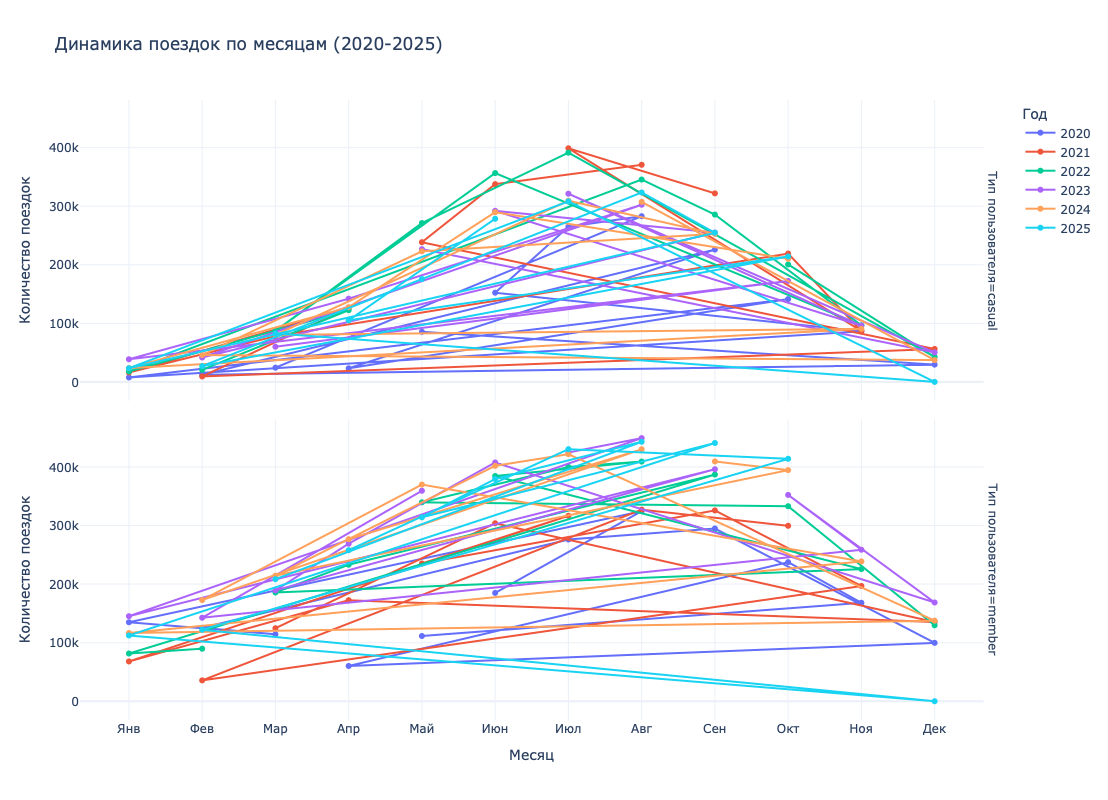


📊 Сводная статистика по годам:
shape: (12, 4)
┌──────┬───────────────┬─────────────┬───────────────┐
│ year ┆ member_casual ┆ total_trips ┆ avg_monthly   │
│ ---  ┆ ---           ┆ ---         ┆ ---           │
│ i32  ┆ str           ┆ u32         ┆ f64           │
╞══════╪═══════════════╪═════════════╪═══════════════╡
│ 2020 ┆ casual        ┆ 1336682     ┆ 111390.166667 │
│ 2020 ┆ member        ┆ 2131816     ┆ 177651.333333 │
│ 2021 ┆ casual        ┆ 2260261     ┆ 188355.083333 │
│ 2021 ┆ member        ┆ 2540597     ┆ 211716.416667 │
│ 2022 ┆ casual        ┆ 2238668     ┆ 186555.666667 │
│ …    ┆ …             ┆ …           ┆ …             │
│ 2023 ┆ member        ┆ 3562424     ┆ 296868.666667 │
│ 2024 ┆ casual        ┆ 1998133     ┆ 166511.083333 │
│ 2024 ┆ member        ┆ 3584385     ┆ 298698.75     │
│ 2025 ┆ casual        ┆ 1793451     ┆ 163041.0      │
│ 2025 ┆ member        ┆ 3122243     ┆ 283840.272727 │
└──────┴───────────────┴─────────────┴───────────────┘

КРОСС-ГОДОВОЙ ГРА

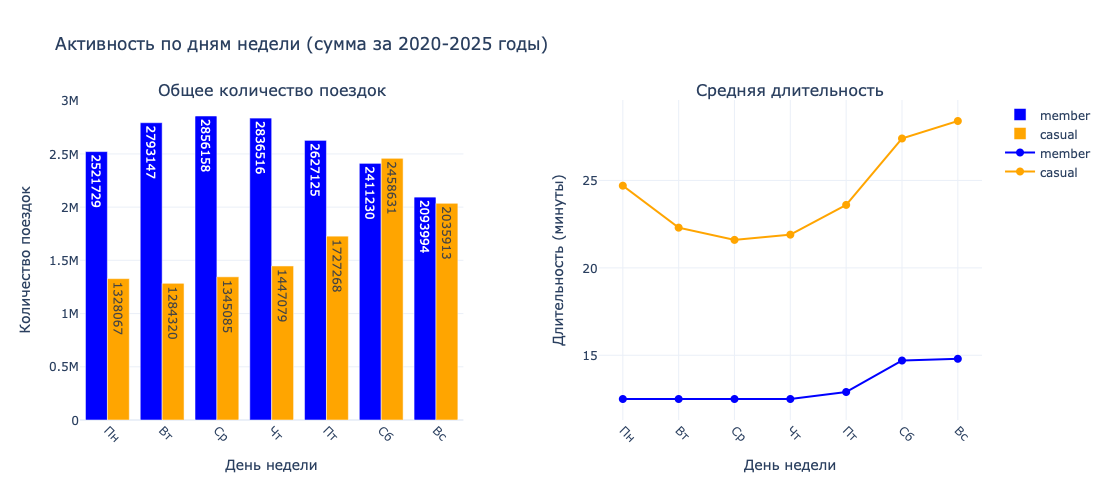


📊 Суммарная статистика по дням недели (2020-2025):
shape: (14, 4)
┌─────────┬───────────────┬─────────────┬────────────────────────┐
│ weekday ┆ member_casual ┆ total_trips ┆ avg_duration_all_years │
│ ---     ┆ ---           ┆ ---         ┆ ---                    │
│ i8      ┆ str           ┆ u32         ┆ f64                    │
╞═════════╪═══════════════╪═════════════╪════════════════════════╡
│ 1       ┆ casual        ┆ 1328067     ┆ 24.7                   │
│ 1       ┆ member        ┆ 2521729     ┆ 12.5                   │
│ 2       ┆ member        ┆ 2793147     ┆ 12.5                   │
│ 2       ┆ casual        ┆ 1284320     ┆ 22.3                   │
│ 3       ┆ member        ┆ 2856158     ┆ 12.5                   │
│ …       ┆ …             ┆ …           ┆ …                      │
│ 5       ┆ member        ┆ 2627125     ┆ 12.9                   │
│ 6       ┆ casual        ┆ 2458631     ┆ 27.4                   │
│ 6       ┆ member        ┆ 2411230     ┆ 14.7                

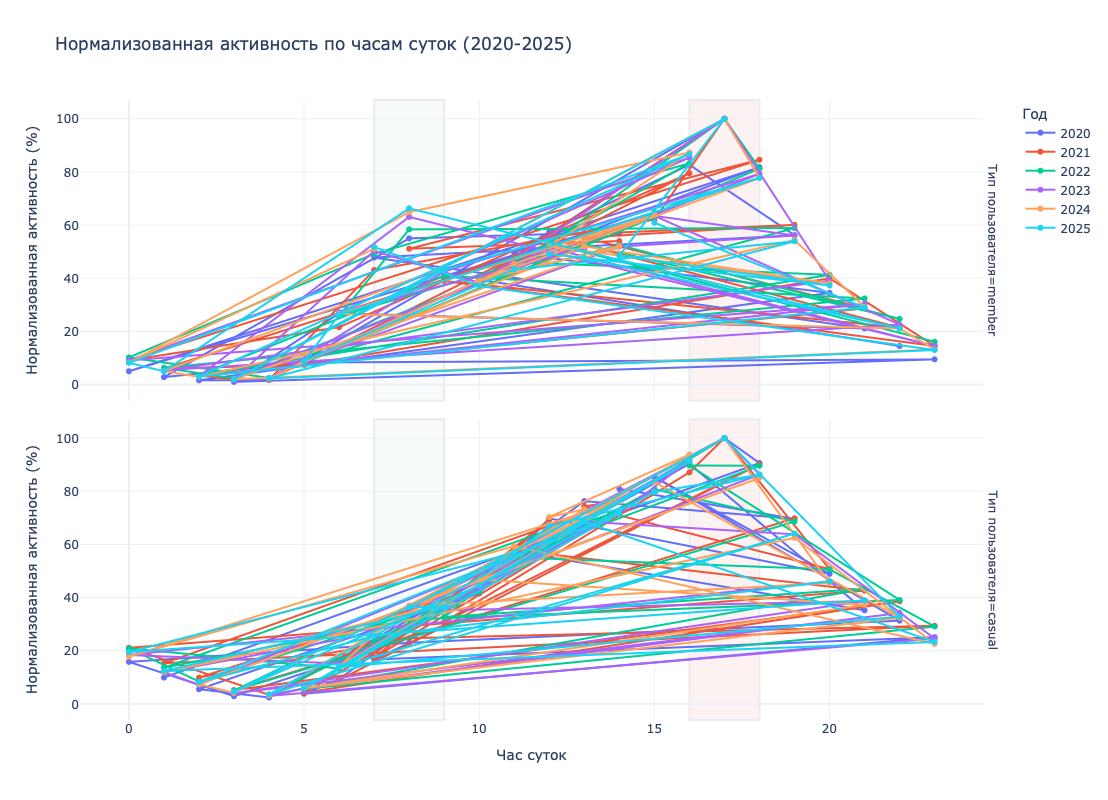


КРОСС-ГОДОВОЙ ГРАФИК 4: Соотношение типов пользователей по годам
Загружаю 2020 год...
Загружаю 2021 год...
Загружаю 2022 год...
Загружаю 2023 год...
Загружаю 2024 год...
Загружаю 2025 год...
✅ График сохранен как HTML: /Users/vsevolod/Desktop/divvy-bikes-analysis/visualizations/cross_4_member_ratio_all_years.html
✅ График сохранен как PNG: /Users/vsevolod/Desktop/divvy-bikes-analysis/visualizations/cross_4_member_ratio_all_years.png


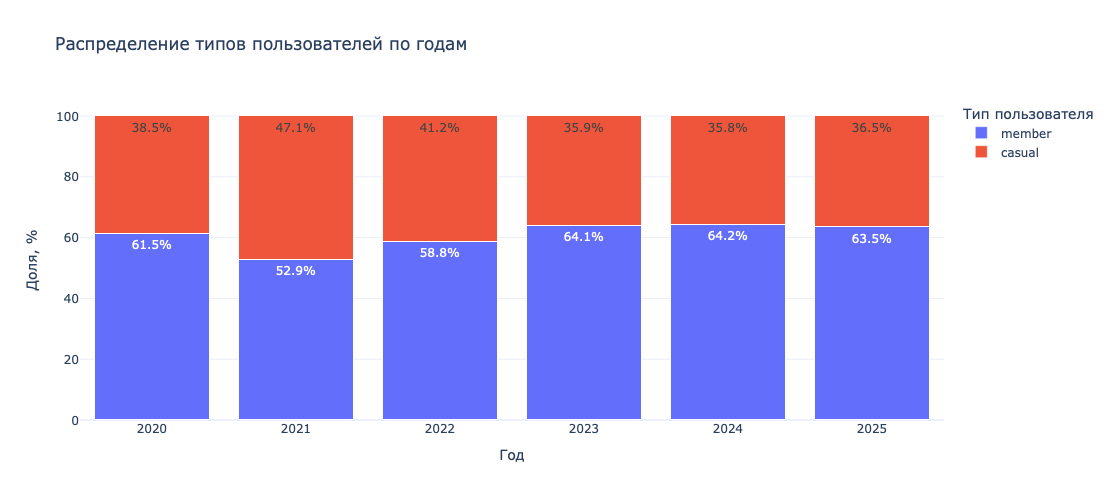


📊 Распределение типов пользователей по годам (%):
shape: (6, 3)
┌──────┬────────┬────────┐
│ year ┆ member ┆ casual │
│ ---  ┆ ---    ┆ ---    │
│ i32  ┆ f64    ┆ f64    │
╞══════╪════════╪════════╡
│ 2020 ┆ 61.5   ┆ 38.5   │
│ 2021 ┆ 52.9   ┆ 47.1   │
│ 2022 ┆ 58.8   ┆ 41.2   │
│ 2023 ┆ 64.1   ┆ 35.9   │
│ 2024 ┆ 64.2   ┆ 35.8   │
│ 2025 ┆ 63.5   ┆ 36.5   │
└──────┴────────┴────────┘

КРОСС-ГОДОВОЙ ГРАФИК 5: Средняя длительность поездок по годам
Загружаю 2020 год...
Загружаю 2021 год...
Загружаю 2022 год...


/var/folders/m_/0vg5klms5wqfl8z1jkpk95tr0000gn/T/ipykernel_10081/448700836.py:554: PerformanceWarning:

Determining the column names of a LazyFrame requires resolving its schema, which is a potentially expensive operation. Use `LazyFrame.collect_schema().names()` to get the column names without this warning.



Загружаю 2023 год...
Загружаю 2024 год...
Загружаю 2025 год...
✅ График сохранен как HTML: /Users/vsevolod/Desktop/divvy-bikes-analysis/visualizations/cross_5_duration_trends_all_years.html
✅ График сохранен как PNG: /Users/vsevolod/Desktop/divvy-bikes-analysis/visualizations/cross_5_duration_trends_all_years.png


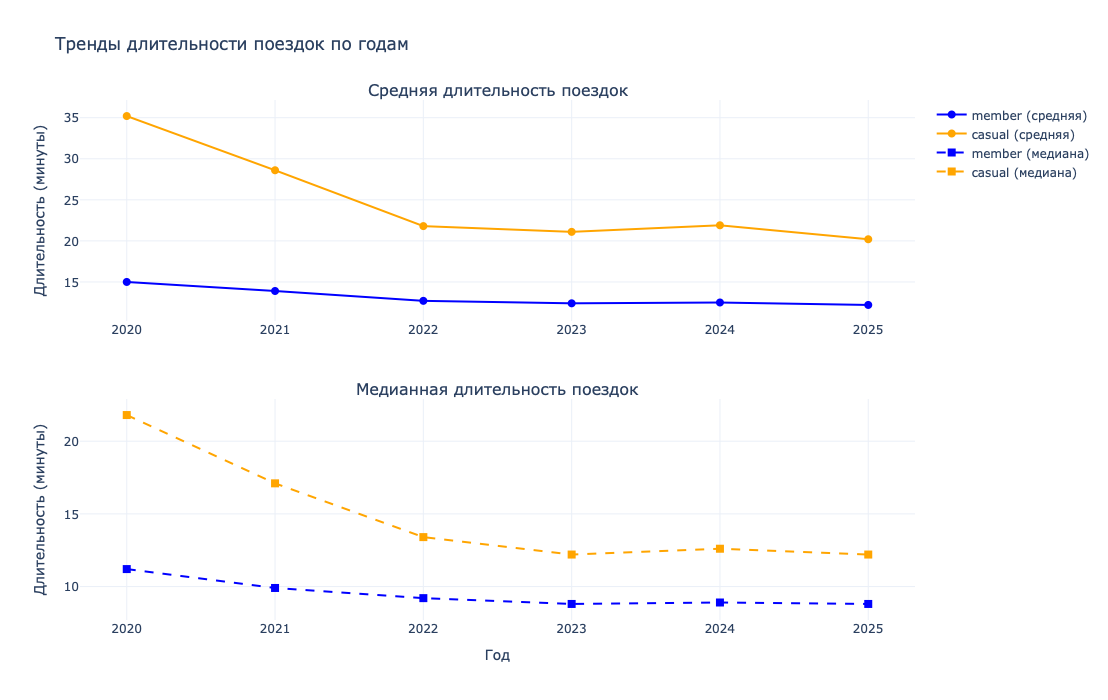


📊 Статистика длительности поездок по годам (минуты):
shape: (12, 4)
┌───────────────┬──────────────────┬─────────────────────┬──────┐
│ member_casual ┆ avg_duration_min ┆ median_duration_min ┆ year │
│ ---           ┆ ---              ┆ ---                 ┆ ---  │
│ str           ┆ f64              ┆ f64                 ┆ i32  │
╞═══════════════╪══════════════════╪═════════════════════╪══════╡
│ member        ┆ 15.0             ┆ 11.2                ┆ 2020 │
│ casual        ┆ 35.2             ┆ 21.8                ┆ 2020 │
│ casual        ┆ 28.6             ┆ 17.1                ┆ 2021 │
│ member        ┆ 13.9             ┆ 9.9                 ┆ 2021 │
│ casual        ┆ 21.8             ┆ 13.4                ┆ 2022 │
│ …             ┆ …                ┆ …                   ┆ …    │
│ member        ┆ 12.4             ┆ 8.8                 ┆ 2023 │
│ casual        ┆ 21.9             ┆ 12.6                ┆ 2024 │
│ member        ┆ 12.5             ┆ 8.9                 ┆ 2024 │
│ casua

/var/folders/m_/0vg5klms5wqfl8z1jkpk95tr0000gn/T/ipykernel_10081/448700836.py:686: DeprecationWarning:

*scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/



✅ График сохранен как HTML: /Users/vsevolod/Desktop/divvy-bikes-analysis/visualizations/cross_6_top_stations_all_time.html
✅ График сохранен как PNG: /Users/vsevolod/Desktop/divvy-bikes-analysis/visualizations/cross_6_top_stations_all_time.png


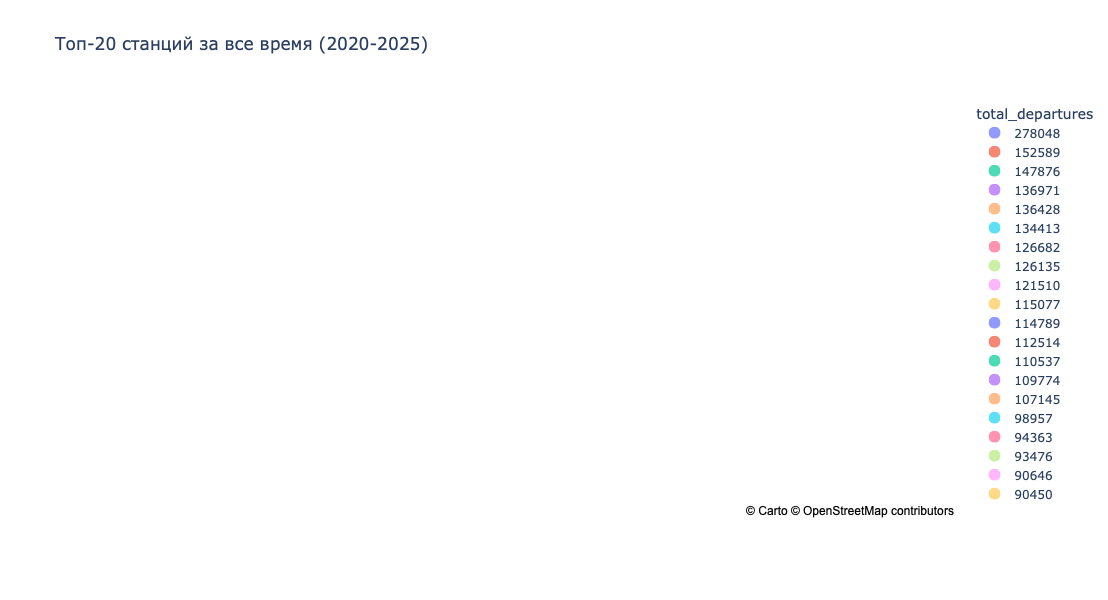


🚲 Топ-20 станций за все время:
 1. Streeter Dr & Grand Ave: 278,048 поездок (6 лет)
 2. Theater on the Lake: 152,589 поездок (6 лет)
 3. DuSable Lake Shore Dr & Monroe St: 147,876 поездок (5 лет)
 4. DuSable Lake Shore Dr & North Blvd: 136,971 поездок (5 лет)
 5. Michigan Ave & Oak St: 136,428 поездок (6 лет)
 6. Wells St & Concord Ln: 134,413 поездок (6 лет)
 7. Kingsbury St & Kinzie St: 126,682 поездок (6 лет)
 8. Clark St & Elm St: 126,135 поездок (6 лет)
 9. Wells St & Elm St: 121,510 поездок (6 лет)
10. Indiana Ave & Roosevelt Rd: 115,077 поездок (6 лет)
11. Clark St & Armitage Ave: 114,789 поездок (6 лет)
12. Clark St & Lincoln Ave: 112,514 поездок (6 лет)
13. Millennium Park: 110,537 поездок (6 лет)
14. Wabash Ave & Grand Ave: 109,774 поездок (6 лет)
15. Dearborn St & Erie St: 107,145 поездок (6 лет)
16. Clinton St & Washington Blvd: 98,957 поездок (6 лет)
17. University Ave & 57th St: 94,363 поездок (6 лет)
18. Dusable Harbor: 93,476 поездок (6 лет)
19. Columbus Dr & Randolph 

/var/folders/m_/0vg5klms5wqfl8z1jkpk95tr0000gn/T/ipykernel_10081/448700836.py:796: DeprecationWarning:

the argument `columns` for `DataFrame.pivot` is deprecated. It was renamed to `on` in version 1.0.0.

/var/folders/m_/0vg5klms5wqfl8z1jkpk95tr0000gn/T/ipykernel_10081/448700836.py:803: DeprecationWarning:

the argument `columns` for `DataFrame.pivot` is deprecated. It was renamed to `on` in version 1.0.0.



✅ График сохранен как PNG: /Users/vsevolod/Desktop/divvy-bikes-analysis/visualizations/cross_7_seasonal_heatmap_all_years.png


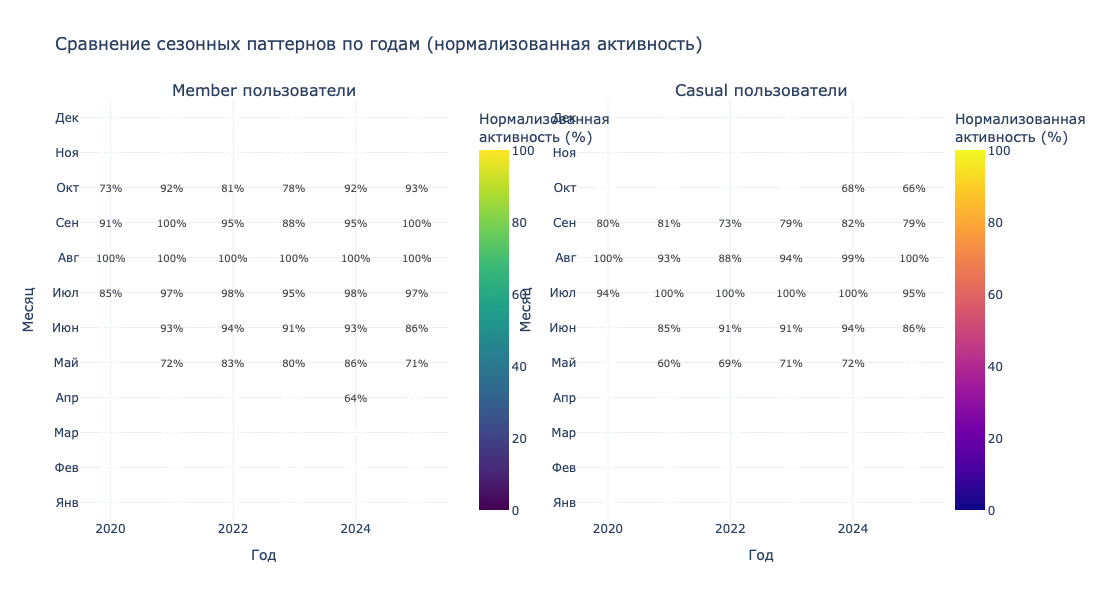


✅ ВСЕ КРОСС-ГОДОВЫЕ ГРАФИКИ УСПЕШНО СОЗДАНЫ!
📁 Файлы сохранены в: /Users/vsevolod/Desktop/divvy-bikes-analysis/visualizations

🎉 АНАЛИЗ ЗАВЕРШЕН!

Созданные графики:
1. Динамика поездок по месяцам (все года)
2. Активность по дням недели (сумма за все года)
3. Активность по часам суток (все года)
4. Соотношение member/casual по годам
5. Тренды длительности поездок по годам
6. Топ-20 станций за все время
7. Сравнение сезонных паттернов (heatmap)

Все графики сохранены в форматах HTML и PNG.


In [9]:
import polars as pl
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
import os
import numpy as np

pio.templates.default = "plotly_white"

# ============================================================================
# КОНФИГУРАЦИЯ
# ============================================================================

DATA_PATHS = {
    2020: "/Users/vsevolod/Desktop/divvy-bikes-analysis/data/processed/2020/rides_2020_optimized_filled.parquet",
    2021: "/Users/vsevolod/Desktop/divvy-bikes-analysis/data/processed/2021/rides_2021_optimized_filled.parquet",
    2022: "/Users/vsevolod/Desktop/divvy-bikes-analysis/data/processed/2022/rides_2022_optimized_filled.parquet",
    2023: "/Users/vsevolod/Desktop/divvy-bikes-analysis/data/processed/2023/rides_2023_optimized_filled.parquet",
    2024: "/Users/vsevolod/Desktop/divvy-bikes-analysis/data/processed/2024/rides_2024_optimized_filled.parquet",
    2025: "/Users/vsevolod/Desktop/divvy-bikes-analysis/data/processed/2025/rides_2025_optimized_filled.parquet"
}

SAVE_DIR = "/Users/vsevolod/Desktop/divvy-bikes-analysis/visualizations"
os.makedirs(SAVE_DIR, exist_ok=True)

# ============================================================================
# УНИВЕРСАЛЬНЫЕ ФУНКЦИИ ДЛЯ ЗАГРУЗКИ ДАННЫХ
# ============================================================================

def load_year_data(year, columns=None):
    """Загружает данные за конкретный год с проверкой доступных колонок"""
    if year not in DATA_PATHS:
        print(f"❌ Нет данных за {year} год")
        return None
    
    path = DATA_PATHS[year]
    if not os.path.exists(path):
        print(f"❌ Файл не найден: {path}")
        return None
    
    try:
        # Сначала прочитаем схему файла
        schema = pl.scan_parquet(path).collect_schema()
        available_columns = list(schema.keys())
        
        # Базовые колонки, которые нужны для большинства графиков
        base_needed = ["started_at", "ended_at", "member_casual"]
        
        # Проверяем, какие из нужных колонок есть в файле
        existing_columns = [col for col in base_needed if col in available_columns]
        
        if len(existing_columns) < 2:  # Нужно хотя бы started_at и member_casual
            print(f"⚠️  В {year} году недостаточно базовых колонок: {existing_columns}")
            return None
        
        # Если запрошены конкретные колонки, проверяем их наличие
        if columns:
            # Добавляем возможные дополнительные колонки
            possible_extra = ["rideable_type", "start_station_name", "end_station_name", "start_lat", "start_lng"]
            available_extra = [col for col in columns if col in available_columns and col not in existing_columns]
            selected_columns = existing_columns + available_extra
        else:
            selected_columns = existing_columns
        
        # Ленивая загрузка только существующих колонок
        lf = pl.scan_parquet(path).select(selected_columns)
        
        # Добавляем вычисляемые колонки, если есть started_at
        if "started_at" in selected_columns:
            lf = lf.with_columns([
                pl.lit(year).alias("year"),
                pl.col("started_at").dt.month().alias("month"),
                pl.col("started_at").dt.hour().alias("hour"),
                pl.col("started_at").dt.weekday().alias("weekday")
            ])
            
            # Добавляем длительность, если есть ended_at
            if "ended_at" in selected_columns:
                lf = lf.with_columns([
                    ((pl.col("ended_at") - pl.col("started_at")).dt.total_seconds()).alias("duration_sec")
                ])
                
                # Фильтруем аномалии
                lf = lf.filter(
                    (pl.col("duration_sec") > 60) & 
                    (pl.col("duration_sec") < 24 * 3600)
                )
        
        return lf
        
    except Exception as e:
        print(f"❌ Ошибка при загрузке данных {year} года: {e}")
        return None

def load_station_data(year):
    """Загружает данные о станциях (отдельная функция для 2020 года)"""
    if year not in DATA_PATHS:
        return None
    
    path = DATA_PATHS[year]
    if not os.path.exists(path):
        return None
    
    try:
        # Сначала проверяем схему
        schema = pl.scan_parquet(path).collect_schema()
        
        # Для 2020 года проверяем наличие колонок
        needed_columns = ["start_station_name", "start_lat", "start_lng"]
        existing_columns = [col for col in needed_columns if col in schema]
        
        if len(existing_columns) < 3:
            print(f"⚠️  В {year} году нет полных данных о станциях")
            return None
        
        # Загружаем только нужные колонки
        lf = pl.scan_parquet(path).select(existing_columns)
        
        # Фильтруем станции без координат
        lf = lf.filter(
            pl.col("start_station_name").is_not_null() &
            (pl.col("start_station_name") != "Non-Station Parking") &
            pl.col("start_lat").is_not_null() &
            pl.col("start_lng").is_not_null()
        )
        
        return lf
        
    except Exception as e:
        print(f"❌ Ошибка при загрузке данных станций {year} года: {e}")
        return None

def collect_safely(lazy_frame):
    """Безопасный сбор данных с обработкой ошибок"""
    try:
        return lazy_frame.collect()
    except Exception as e:
        print(f"❌ Ошибка при сборе данных: {e}")
        return None

# ============================================================================
# КРОСС-ГОДОВЫЕ ГРАФИКИ (все года на одном графике)
# ============================================================================

def plot_cross_year_monthly_trends():
    """График 1: Динамика поездок по месяцам (все года)"""
    print("\n" + "=" * 70)
    print("КРОСС-ГОДОВОЙ ГРАФИК 1: Динамика поездок по месяцам (2020-2025)")
    print("=" * 70)
    
    all_data = []
    years = sorted(list(DATA_PATHS.keys()))
    
    for year in years:
        print(f"Загружаю {year} год...")
        lf = load_year_data(year)
        if lf is None:
            continue
        
        # Агрегируем по месяцам
        query = lf.group_by(["month", "member_casual"]).agg([
            pl.len().alias("trip_count")
        ]).with_columns(pl.lit(year).alias("year"))
        
        data = collect_safely(query)
        if data is not None and data.height > 0:
            all_data.append(data)
    
    if not all_data:
        print("❌ Нет данных для построения графика")
        return None
    
    # Объединяем все данные
    combined = pl.concat(all_data)
    
    # Создаем график
    months_russian = ["Янв", "Фев", "Мар", "Апр", "Май", "Июн", 
                     "Июл", "Авг", "Сен", "Окт", "Ноя", "Дек"]
    
    fig = px.line(
        combined.to_pandas(),
        x="month",
        y="trip_count",
        color="year",
        line_group="member_casual",
        facet_row="member_casual",  # Разделяем на два графика
        title="Динамика поездок по месяцам (2020-2025)",
        labels={
            "month": "Месяц",
            "trip_count": "Количество поездок",
            "year": "Год",
            "member_casual": "Тип пользователя"
        },
        markers=True
    )
    
    # Обновляем оси X
    fig.update_xaxes(tickvals=list(range(1, 13)), ticktext=months_russian)
    fig.update_layout(height=800)
    
    # Сохраняем
    save_path_html = os.path.join(SAVE_DIR, "cross_1_monthly_trends_all_years.html")
    save_path_png = os.path.join(SAVE_DIR, "cross_1_monthly_trends_all_years.png")
    
    fig.write_html(save_path_html)
    print(f"✅ График сохранен как HTML: {save_path_html}")
    
    try:
        fig.write_image(save_path_png, width=1400, height=800)
        print(f"✅ График сохранен как PNG: {save_path_png}")
    except Exception as e:
        print(f"⚠️  Не удалось сохранить PNG: {e}")
    
    fig.show()
    
    # Сводная статистика
    print("\n📊 Сводная статистика по годам:")
    yearly_stats = combined.group_by(["year", "member_casual"]).agg([
        pl.col("trip_count").sum().alias("total_trips"),
        pl.col("trip_count").mean().alias("avg_monthly")
    ]).sort(["year", "member_casual"])
    
    print(yearly_stats)
    
    return fig

def plot_cross_year_weekday_patterns():
    """График 2: Активность по дням недели (сумма по всем годам)"""
    print("\n" + "=" * 70)
    print("КРОСС-ГОДОВОЙ ГРАФИК 2: Активность по дням недели (сумма 2020-2025)")
    print("=" * 70)
    
    all_data = []
    years = sorted(list(DATA_PATHS.keys()))
    
    for year in years:
        print(f"Загружаю {year} год...")
        lf = load_year_data(year)
        if lf is None:
            continue
        
        # Агрегируем по дням недели
        query = lf.group_by(["weekday", "member_casual"]).agg([
            pl.len().alias("trip_count"),
            (pl.col("duration_sec") / 60).mean().round(1).alias("avg_duration_min")
        ]).with_columns(pl.lit(year).alias("year"))
        
        data = collect_safely(query)
        if data is not None and data.height > 0:
            all_data.append(data)
    
    if not all_data:
        print("❌ Нет данных для построения графика")
        return None
    
    # Объединяем все данные
    combined = pl.concat(all_data)
    
    # Агрегируем по всем годам
    aggregated = combined.group_by(["weekday", "member_casual"]).agg([
        pl.col("trip_count").sum().alias("total_trips"),
        pl.col("avg_duration_min").mean().round(1).alias("avg_duration_all_years")
    ]).sort("weekday")
    
    # Создаем два подграфика
    fig = make_subplots(
        rows=1, cols=2,
        subplot_titles=("Общее количество поездок", "Средняя длительность"),
        horizontal_spacing=0.15
    )
    
    days_russian = ["Пн", "Вт", "Ср", "Чт", "Пт", "Сб", "Вс"]
    
    # График 1: Количество поездок
    for member_type, color in [("member", "blue"), ("casual", "orange")]:
        subset = aggregated.filter(pl.col("member_casual") == member_type)
        subset_pd = subset.to_pandas()
        fig.add_trace(
            go.Bar(
                x=subset_pd["weekday"],
                y=subset_pd["total_trips"],
                name=member_type,
                marker_color=color,
                text=subset_pd["total_trips"],
                textposition="auto"
            ),
            row=1, col=1
        )
    
    # График 2: Длительность
    for member_type, color in [("member", "blue"), ("casual", "orange")]:
        subset = aggregated.filter(pl.col("member_casual") == member_type)
        subset_pd = subset.to_pandas()
        fig.add_trace(
            go.Scatter(
                x=subset_pd["weekday"],
                y=subset_pd["avg_duration_all_years"],
                name=member_type,
                mode="lines+markers",
                line=dict(color=color, width=2),
                marker=dict(size=8)
            ),
            row=1, col=2
        )
    
    fig.update_layout(
        title="Активность по дням недели (сумма за 2020-2025 годы)",
        height=500,
        showlegend=True,
        barmode="group"
    )
    
    # Обновляем оси X
    fig.update_xaxes(
        tickvals=list(range(1, 8)),
        ticktext=days_russian,
        title_text="День недели",
        row=1, col=1,
        tickangle=45
    )
    fig.update_xaxes(
        tickvals=list(range(1, 8)),
        ticktext=days_russian,
        title_text="День недели",
        row=1, col=2,
        tickangle=45
    )
    
    fig.update_yaxes(title_text="Количество поездок", row=1, col=1)
    fig.update_yaxes(title_text="Длительность (минуты)", row=1, col=2)
    
    # Сохраняем
    save_path_html = os.path.join(SAVE_DIR, "cross_2_weekday_patterns_all_years.html")
    save_path_png = os.path.join(SAVE_DIR, "cross_2_weekday_patterns_all_years.png")
    
    fig.write_html(save_path_html)
    print(f"✅ График сохранен как HTML: {save_path_html}")
    
    try:
        fig.write_image(save_path_png, width=1400, height=500)
        print(f"✅ График сохранен как PNG: {save_path_png}")
    except Exception as e:
        print(f"⚠️  Не удалось сохранить PNG: {e}")
    
    fig.show()
    
    # Выводим статистику
    print("\n📊 Суммарная статистика по дням недели (2020-2025):")
    print(aggregated)
    
    return fig

def plot_cross_year_hourly_patterns():
    """График 3: Активность по часам (все года на одном графике)"""
    print("\n" + "=" * 70)
    print("КРОСС-ГОДОВОЙ ГРАФИК 3: Активность по часам суток (2020-2025)")
    print("=" * 70)
    
    all_data = []
    years = sorted(list(DATA_PATHS.keys()))
    
    for year in years:
        print(f"Загружаю {year} год...")
        lf = load_year_data(year)
        if lf is None:
            continue
        
        # Агрегируем по часам
        query = lf.group_by(["hour", "member_casual"]).agg([
            pl.len().alias("trip_count")
        ]).with_columns(pl.lit(year).alias("year"))
        
        data = collect_safely(query)
        if data is not None and data.height > 0:
            all_data.append(data)
    
    if not all_data:
        print("❌ Нет данных для построения графика")
        return None
    
    # Объединяем все данные
    combined = pl.concat(all_data)
    
    # Нормализуем по максимуму для каждого года и типа пользователя
    normalized_data = []
    
    for year in combined["year"].unique():
        for member_type in ["member", "casual"]:
            subset = combined.filter(
                (pl.col("year") == year) & 
                (pl.col("member_casual") == member_type)
            )
            
            if subset.height > 0:
                max_trips = subset["trip_count"].max()
                subset = subset.with_columns([
                    (pl.col("trip_count") / max_trips * 100).round(1).alias("normalized")
                ])
                normalized_data.append(subset)
    
    if not normalized_data:
        print("❌ Не удалось нормализовать данные")
        return None
    
    normalized_combined = pl.concat(normalized_data)
    
    # Создаем график
    fig = px.line(
        normalized_combined.to_pandas(),
        x="hour",
        y="normalized",
        color="year",
        line_group="member_casual",
        facet_row="member_casual",
        title="Нормализованная активность по часам суток (2020-2025)",
        labels={
            "hour": "Час суток",
            "normalized": "Нормализованная активность (%)",
            "year": "Год",
            "member_casual": "Тип пользователя"
        },
        markers=True
    )
    
    # Добавляем выделение пиковых часов
    for i in range(1, 3):
        fig.add_vrect(x0=7, x1=9, fillcolor="lightblue", opacity=0.1, 
                     layer="below", row=i, col=1)
        fig.add_vrect(x0=16, x1=18, fillcolor="lightcoral", opacity=0.1, 
                     layer="below", row=i, col=1)
    
    fig.update_layout(height=800)
    
    # Сохраняем
    save_path_html = os.path.join(SAVE_DIR, "cross_3_hourly_patterns_all_years.html")
    save_path_png = os.path.join(SAVE_DIR, "cross_3_hourly_patterns_all_years.png")
    
    fig.write_html(save_path_html)
    print(f"✅ График сохранен как HTML: {save_path_html}")
    
    try:
        fig.write_image(save_path_png, width=1400, height=800)
        print(f"✅ График сохранен как PNG: {save_path_png}")
    except Exception as e:
        print(f"⚠️  Не удалось сохранить PNG: {e}")
    
    fig.show()
    
    return fig

def plot_cross_year_member_ratio():
    """График 4: Соотношение member/casual по годам"""
    print("\n" + "=" * 70)
    print("КРОСС-ГОДОВОЙ ГРАФИК 4: Соотношение типов пользователей по годам")
    print("=" * 70)
    
    years = sorted(list(DATA_PATHS.keys()))
    all_counts = []
    
    for year in years:
        print(f"Загружаю {year} год...")
        lf = load_year_data(year)
        if lf is None:
            continue
        
        # Считаем количество поездок по типам пользователей
        query = lf.group_by("member_casual").agg([
            pl.len().alias("count")
        ]).with_columns(pl.lit(year).alias("year"))
        
        data = collect_safely(query)
        if data is not None and data.height > 0:
            all_counts.append(data)
    
    if not all_counts:
        print("❌ Нет данных для построения графика")
        return None
    
    combined = pl.concat(all_counts)
    
    # Рассчитываем проценты
    yearly_totals = combined.group_by("year").agg([
        pl.col("count").sum().alias("total")
    ])
    
    combined = combined.join(yearly_totals, on="year")
    combined = combined.with_columns([
        (pl.col("count") / pl.col("total") * 100).round(1).alias("percentage")
    ])
    
    # Создаем stacked bar chart
    fig = px.bar(
        combined.to_pandas(),
        x="year",
        y="percentage",
        color="member_casual",
        title="Распределение типов пользователей по годам",
        labels={
            "year": "Год",
            "percentage": "Доля, %",
            "member_casual": "Тип пользователя"
        },
        barmode="stack",
        text="percentage"
    )
    
    fig.update_traces(texttemplate="%{text:.1f}%", textposition="inside")
    fig.update_layout(height=500)
    
    # Сохраняем
    save_path_html = os.path.join(SAVE_DIR, "cross_4_member_ratio_all_years.html")
    save_path_png = os.path.join(SAVE_DIR, "cross_4_member_ratio_all_years.png")
    
    fig.write_html(save_path_html)
    print(f"✅ График сохранен как HTML: {save_path_html}")
    
    try:
        fig.write_image(save_path_png, width=1200, height=500)
        print(f"✅ График сохранен как PNG: {save_path_png}")
    except Exception as e:
        print(f"⚠️  Не удалось сохранить PNG: {e}")
    
    fig.show()
    
    # Выводим таблицу
    print("\n📊 Распределение типов пользователей по годам (%):")
    pivot_table = combined.pivot(
        values="percentage",
        index="year",
        on="member_casual",
        aggregate_function="first"
    ).fill_null(0)
    print(pivot_table)
    
    return fig

def plot_cross_year_duration_trends():
    """График 5: Тренды длительности поездок по годам"""
    print("\n" + "=" * 70)
    print("КРОСС-ГОДОВОЙ ГРАФИК 5: Средняя длительность поездок по годам")
    print("=" * 70)
    
    years = sorted(list(DATA_PATHS.keys()))
    all_durations = []
    
    for year in years:
        print(f"Загружаю {year} год...")
        lf = load_year_data(year)
        if lf is None:
            continue
        
        # Проверяем, есть ли колонка duration_sec
        if "duration_sec" not in lf.columns:
            print(f"⚠️  В {year} году нет данных о длительности")
            continue
        
        # Агрегируем по типу пользователя
        query = lf.group_by("member_casual").agg([
            (pl.col("duration_sec") / 60).mean().round(1).alias("avg_duration_min"),
            (pl.col("duration_sec") / 60).median().round(1).alias("median_duration_min")
        ]).with_columns(pl.lit(year).alias("year"))
        
        data = collect_safely(query)
        if data is not None and data.height > 0:
            all_durations.append(data)
    
    if not all_durations:
        print("❌ Нет данных для построения графика")
        return None
    
    combined = pl.concat(all_durations)
    
    # Создаем график
    fig = make_subplots(
        rows=2, cols=1,
        subplot_titles=("Средняя длительность поездок", "Медианная длительность поездок"),
        vertical_spacing=0.15
    )
    
    # График 1: Средняя длительность
    for member_type, color in [("member", "blue"), ("casual", "orange")]:
        subset = combined.filter(pl.col("member_casual") == member_type)
        subset_pd = subset.to_pandas()
        fig.add_trace(
            go.Scatter(
                x=subset_pd["year"],
                y=subset_pd["avg_duration_min"],
                name=f"{member_type} (средняя)",
                mode="lines+markers",
                line=dict(color=color, width=2),
                marker=dict(size=8)
            ),
            row=1, col=1
        )
    
    # График 2: Медианная длительность
    for member_type, color in [("member", "blue"), ("casual", "orange")]:
        subset = combined.filter(pl.col("member_casual") == member_type)
        subset_pd = subset.to_pandas()
        fig.add_trace(
            go.Scatter(
                x=subset_pd["year"],
                y=subset_pd["median_duration_min"],
                name=f"{member_type} (медиана)",
                mode="lines+markers",
                line=dict(color=color, width=2, dash="dash"),
                marker=dict(size=8, symbol="square")
            ),
            row=2, col=1
        )
    
    fig.update_layout(
        title="Тренды длительности поездок по годам",
        height=700,
        showlegend=True
    )
    
    fig.update_xaxes(title_text="Год", row=2, col=1)
    fig.update_yaxes(title_text="Длительность (минуты)", row=1, col=1)
    fig.update_yaxes(title_text="Длительность (минуты)", row=2, col=1)
    
    # Сохраняем
    save_path_html = os.path.join(SAVE_DIR, "cross_5_duration_trends_all_years.html")
    save_path_png = os.path.join(SAVE_DIR, "cross_5_duration_trends_all_years.png")
    
    fig.write_html(save_path_html)
    print(f"✅ График сохранен как HTML: {save_path_html}")
    
    try:
        fig.write_image(save_path_png, width=1200, height=700)
        print(f"✅ График сохранен как PNG: {save_path_png}")
    except Exception as e:
        print(f"⚠️  Не удалось сохранить PNG: {e}")
    
    fig.show()
    
    # Выводим статистику
    print("\n📊 Статистика длительности поездок по годам (минуты):")
    print(combined)
    
    return fig

def plot_cross_year_stations_all_time():
    """График 6: Топ станций за все время (2020-2025)"""
    print("\n" + "=" * 70)
    print("КРОСС-ГОДОВОЙ ГРАФИК 6: Топ-20 станций за все время (2020-2025)")
    print("=" * 70)
    
    years = sorted(list(DATA_PATHS.keys()))
    all_stations = []
    
    for year in years:
        print(f"Загружаю станции {year} года...")
        lf = load_station_data(year)
        if lf is None:
            continue
        
        # Агрегируем по станциям
        query = lf.group_by(["start_station_name", "start_lat", "start_lng"]).agg([
            pl.len().alias("departures")
        ]).with_columns(pl.lit(year).alias("year"))
        
        data = collect_safely(query)
        if data is not None and data.height > 0:
            all_stations.append(data)
    
    if not all_stations:
        print("❌ Нет данных о станциях для построения карты")
        return None
    
    # Объединяем все данные
    combined = pl.concat(all_stations)
    
    # Агрегируем по всем годам
    aggregated = combined.group_by(["start_station_name", "start_lat", "start_lng"]).agg([
        pl.col("departures").sum().alias("total_departures"),
        pl.col("year").n_unique().alias("active_years")
    ]).sort("total_departures", descending=True).head(20)
    
    if aggregated.height == 0:
        print("❌ Не удалось агрегировать данные станций")
        return None
    
    # Создаем карту
    fig = px.scatter_mapbox(
        aggregated.to_pandas(),
        lat="start_lat",
        lon="start_lng",
        size="total_departures",
        color="total_departures",
        hover_name="start_station_name",
        hover_data={"total_departures": True, "active_years": True, "start_lat": False, "start_lng": False},
        size_max=30,
        zoom=10,
        mapbox_style="carto-positron",
        title="Топ-20 станций за все время (2020-2025)",
        color_continuous_scale="Viridis"
    )
    
    # Центрируем на Чикаго
    fig.update_layout(
        mapbox=dict(
            center=dict(lat=41.8781, lon=-87.6298),
            zoom=10
        ),
        height=600
    )
    
    # Сохраняем
    save_path_html = os.path.join(SAVE_DIR, "cross_6_top_stations_all_time.html")
    save_path_png = os.path.join(SAVE_DIR, "cross_6_top_stations_all_time.png")
    
    fig.write_html(save_path_html)
    print(f"✅ График сохранен как HTML: {save_path_html}")
    
    try:
        fig.write_image(save_path_png, width=1200, height=600)
        print(f"✅ График сохранен как PNG: {save_path_png}")
    except Exception as e:
        print(f"⚠️  Не удалось сохранить PNG: {e}")
    
    fig.show()
    
    # Выводим таблицу
    print(f"\n🚲 Топ-20 станций за все время:")
    for i, row in enumerate(aggregated.iter_rows(named=True), 1):
        print(f"{i:2}. {row['start_station_name']}: {row['total_departures']:,} поездок ({row['active_years']} лет)")
    
    # Статистика
    total_departures = aggregated["total_departures"].sum()
    avg_per_station = aggregated["total_departures"].mean()
    
    print(f"\n📈 Статистика:")
    print(f"   • Всего поездок с топ-20 станций: {total_departures:,}")
    print(f"   • Среднее количество поездок на станцию: {avg_per_station:,.0f}")
    print(f"   • Самая популярная станция: {aggregated['start_station_name'][0]} ({aggregated['total_departures'][0]:,} поездок)")
    
    return fig

def plot_cross_year_seasonal_comparison():
    """График 7: Сравнение сезонных паттернов по годам"""
    print("\n" + "=" * 70)
    print("КРОСС-ГОДОВОЙ ГРАФИК 7: Сравнение сезонных паттернов (2020-2025)")
    print("=" * 70)
    
    years = sorted(list(DATA_PATHS.keys()))
    all_seasonal = []
    
    for year in years:
        print(f"Загружаю {year} год...")
        lf = load_year_data(year)
        if lf is None:
            continue
        
        # Агрегируем по месяцам
        query = lf.group_by(["month", "member_casual"]).agg([
            pl.len().alias("trip_count")
        ]).with_columns(pl.lit(year).alias("year"))
        
        data = collect_safely(query)
        if data is not None and data.height > 0:
            all_seasonal.append(data)
    
    if not all_seasonal:
        print("❌ Нет данных для построения графика")
        return None
    
    combined = pl.concat(all_seasonal)
    
    # Нормализуем по максимуму для каждого года и типа
    normalized_data = []
    
    for year in combined["year"].unique():
        for member_type in ["member", "casual"]:
            subset = combined.filter(
                (pl.col("year") == year) & 
                (pl.col("member_casual") == member_type)
            )
            
            if subset.height > 0:
                max_trips = subset["trip_count"].max()
                subset = subset.with_columns([
                    (pl.col("trip_count") / max_trips * 100).round(1).alias("normalized")
                ])
                normalized_data.append(subset)
    
    if not normalized_data:
        print("❌ Не удалось нормализовать данные")
        return None
    
    normalized_combined = pl.concat(normalized_data)
    
    # Создаем heatmap
    # Подготовим данные для heatmap
    pivot_member = normalized_combined.filter(pl.col("member_casual") == "member").pivot(
        values="normalized",
        index="month",
        columns="year",
        aggregate_function="mean"
    ).fill_null(0).sort("month")
    
    pivot_casual = normalized_combined.filter(pl.col("member_casual") == "casual").pivot(
        values="normalized",
        index="month",
        columns="year",
        aggregate_function="mean"
    ).fill_null(0).sort("month")
    
    months_russian = ["Янв", "Фев", "Мар", "Апр", "Май", "Июн", 
                     "Июл", "Авг", "Сен", "Окт", "Ноя", "Дек"]
    
    # Создаем subplot с двумя heatmap
    fig = make_subplots(
        rows=1, cols=2,
        subplot_titles=("Member пользователи", "Casual пользователи"),
        horizontal_spacing=0.15
    )
    
    # Heatmap для member
    fig.add_trace(
        go.Heatmap(
            z=pivot_member.select(pl.exclude("month")).to_numpy(),
            x=years,
            y=months_russian,
            colorscale="Viridis",
            colorbar=dict(title="Нормализованная<br>активность (%)", x=0.45),
            text=pivot_member.select(pl.exclude("month")).to_numpy(),
            texttemplate="%{text:.0f}%",
            textfont={"size": 10}
        ),
        row=1, col=1
    )
    
    # Heatmap для casual
    fig.add_trace(
        go.Heatmap(
            z=pivot_casual.select(pl.exclude("month")).to_numpy(),
            x=years,
            y=months_russian,
            colorscale="Plasma",
            colorbar=dict(title="Нормализованная<br>активность (%)", x=1.0),
            text=pivot_casual.select(pl.exclude("month")).to_numpy(),
            texttemplate="%{text:.0f}%",
            textfont={"size": 10}
        ),
        row=1, col=2
    )
    
    fig.update_layout(
        title="Сравнение сезонных паттернов по годам (нормализованная активность)",
        height=600
    )
    
    fig.update_xaxes(title_text="Год", row=1, col=1)
    fig.update_xaxes(title_text="Год", row=1, col=2)
    fig.update_yaxes(title_text="Месяц", row=1, col=1)
    fig.update_yaxes(title_text="Месяц", row=1, col=2)
    
    # Сохраняем
    save_path_html = os.path.join(SAVE_DIR, "cross_7_seasonal_heatmap_all_years.html")
    save_path_png = os.path.join(SAVE_DIR, "cross_7_seasonal_heatmap_all_years.png")
    
    fig.write_html(save_path_html)
    print(f"✅ График сохранен как HTML: {save_path_html}")
    
    try:
        fig.write_image(save_path_png, width=1400, height=600)
        print(f"✅ График сохранен как PNG: {save_path_png}")
    except Exception as e:
        print(f"⚠️  Не удалось сохранить PNG: {e}")
    
    fig.show()
    
    return fig

# ============================================================================
# ГРАФИКИ ДЛЯ ОТДЕЛЬНОГО ГОДА (опционально)
# ============================================================================

def plot_seasonal_patterns_single_year(year=2024):
    """График сезонности для одного года"""
    print(f"\nСезонные паттерны для {year} года")
    
    lf = load_year_data(year)
    if lf is None:
        return None
    
    query = lf.group_by(["month", "member_casual"]).agg([
        pl.len().alias("trip_count"),
        (pl.col("duration_sec") / 60).mean().round(1).alias("avg_duration_min")
    ]).sort(["month", "member_casual"])
    
    data = collect_safely(query)
    if data is None or data.height == 0:
        return None
    
    # Упрощенный график
    months_russian = ["Янв", "Фев", "Мар", "Апр", "Май", "Июн", 
                     "Июл", "Авг", "Сен", "Окт", "Ноя", "Дек"]
    
    fig = px.line(
        data.to_pandas(),
        x="month",
        y="trip_count",
        color="member_casual",
        title=f"Сезонные паттерны ({year} год)",
        markers=True
    )
    
    fig.update_xaxes(tickvals=list(range(1, 13)), ticktext=months_russian)
    fig.show()
    
    return fig

# ============================================================================
# ОСНОВНАЯ ФУНКЦИЯ ДЛЯ СОЗДАНИЯ ВСЕХ ГРАФИКОВ
# ============================================================================

def create_all_cross_year_visualizations():
    """Создает все кросс-годовые графики"""
    print("=" * 70)
    print("СОЗДАНИЕ КРОСС-ГОДОВЫХ ВИЗУАЛИЗАЦИЙ (2020-2025)")
    print("=" * 70)
    
    # Создаем папку для визуализаций
    os.makedirs(SAVE_DIR, exist_ok=True)
    
    # Запускаем все кросс-годовые графики
    print("\n🚀 Запускаю создание кросс-годовых графиков...")
    
    # График 1: Динамика по месяцам
    plot_cross_year_monthly_trends()
    
    # График 2: Дни недели (сумма)
    plot_cross_year_weekday_patterns()
    
    # График 3: Часы суток
    plot_cross_year_hourly_patterns()
    
    # График 4: Соотношение member/casual
    plot_cross_year_member_ratio()
    
    # График 5: Тренды длительности
    plot_cross_year_duration_trends()
    
    # График 6: Топ станций за все время
    plot_cross_year_stations_all_time()
    
    # График 7: Сезонные heatmap
    plot_cross_year_seasonal_comparison()
    
    print("\n" + "=" * 70)
    print("✅ ВСЕ КРОСС-ГОДОВЫЕ ГРАФИКИ УСПЕШНО СОЗДАНЫ!")
    print(f"📁 Файлы сохранены в: {SAVE_DIR}")
    print("=" * 70)

# ============================================================================
# ЗАПУСК ПРОГРАММЫ
# ============================================================================

if __name__ == "__main__":
    print("=" * 70)
    print("КРОСС-ГОДОВАЯ ВИЗУАЛИЗАЦИЯ ДАННЫХ DIVVY BIKES")
    print("Графики показывают динамику с 2020 по 2025 год")
    print("=" * 70)
    
    # Предупреждение о нагрузке
    print("\n⚠️  ВНИМАНИЕ: Создание кросс-годовых графиков может занять некоторое время")
    print("   так как нужно обработать данные за 6 лет.")
    print("   Пожалуйста, не закрывайте программу во время работы.\n")
    
    # Запускаем создание всех графиков
    create_all_cross_year_visualizations()
    
    print("\n" + "=" * 70)
    print("🎉 АНАЛИЗ ЗАВЕРШЕН!")
    print("=" * 70)
    print("\nСозданные графики:")
    print("1. Динамика поездок по месяцам (все года)")
    print("2. Активность по дням недели (сумма за все года)")
    print("3. Активность по часам суток (все года)")
    print("4. Соотношение member/casual по годам")
    print("5. Тренды длительности поездок по годам")
    print("6. Топ-20 станций за все время")
    print("7. Сравнение сезонных паттернов (heatmap)")
    print("\nВсе графики сохранены в форматах HTML и PNG.")

УЛУЧШЕННАЯ ВИЗУАЛИЗАЦИЯ DIVVY BIKES
Создание более читаемых и красивых графиков
СОЗДАНИЕ УЛУЧШЕННЫХ ГРАФИКОВ

🚀 Создаю улучшенные графики...

УЛУЧШЕННЫЙ ГРАФИК: Динамика поездок по месяцам (2020-2025)
Загружаю 2020 год...
Загружаю 2021 год...
Загружаю 2022 год...
Загружаю 2023 год...
Загружаю 2024 год...
Загружаю 2025 год...
✅ График сохранен как HTML: /Users/vsevolod/Desktop/divvy-bikes-analysis/visualizations/improved_monthly_trends_all_years.html


/var/folders/m_/0vg5klms5wqfl8z1jkpk95tr0000gn/T/ipykernel_1925/3520302310.py:278: DeprecationWarning:


Support for the 'engine' argument is deprecated and will be removed after September 2025.
Kaleido will be the only supported engine at that time.




✅ График сохранен как PNG: /Users/vsevolod/Desktop/divvy-bikes-analysis/visualizations/improved_monthly_trends_all_years.png


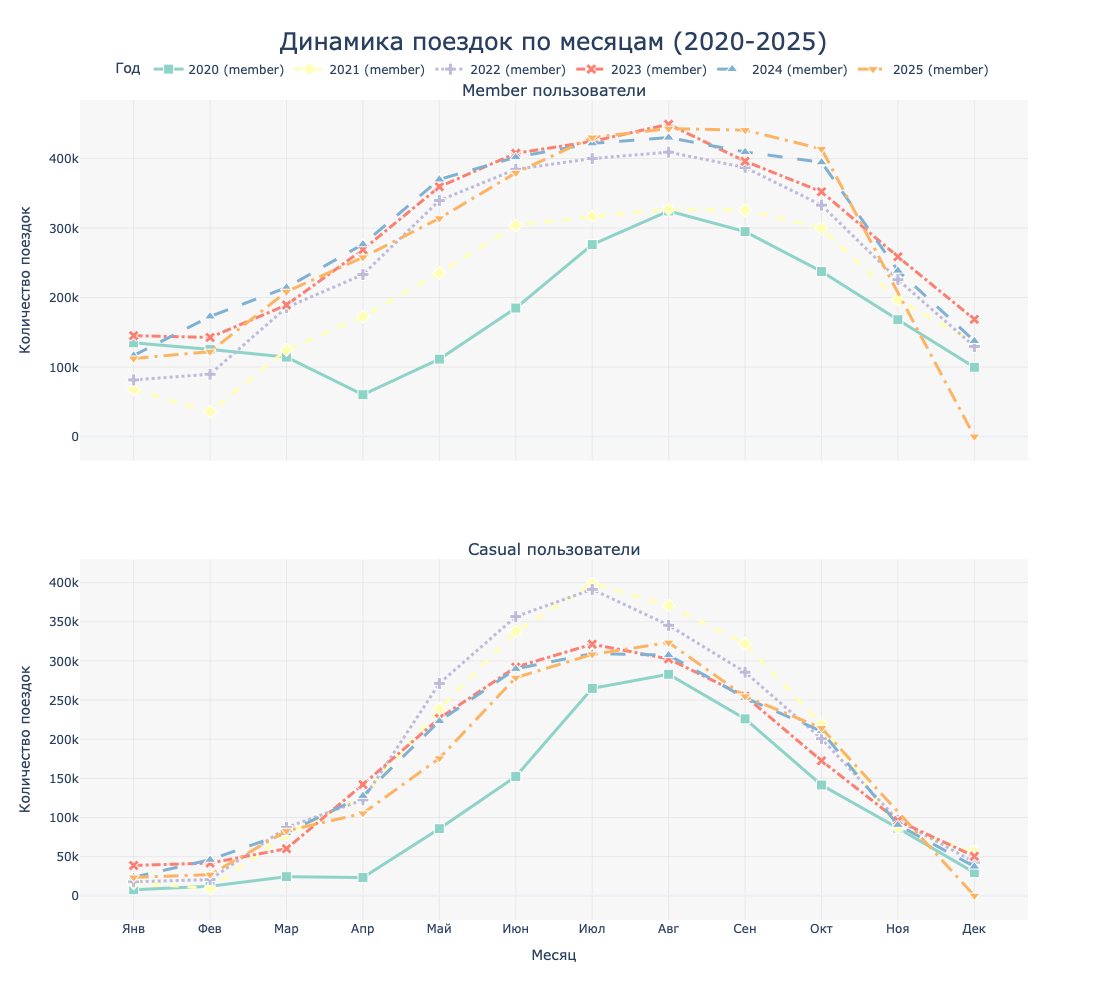


📊 Сводная статистика по годам:
shape: (12, 4)
┌──────┬───────────────┬─────────────┬───────────────┐
│ year ┆ member_casual ┆ total_trips ┆ avg_monthly   │
│ ---  ┆ ---           ┆ ---         ┆ ---           │
│ i32  ┆ str           ┆ u32         ┆ f64           │
╞══════╪═══════════════╪═════════════╪═══════════════╡
│ 2020 ┆ casual        ┆ 1336682     ┆ 111390.166667 │
│ 2020 ┆ member        ┆ 2131816     ┆ 177651.333333 │
│ 2021 ┆ casual        ┆ 2260261     ┆ 188355.083333 │
│ 2021 ┆ member        ┆ 2540597     ┆ 211716.416667 │
│ 2022 ┆ casual        ┆ 2238668     ┆ 186555.666667 │
│ …    ┆ …             ┆ …           ┆ …             │
│ 2023 ┆ member        ┆ 3562424     ┆ 296868.666667 │
│ 2024 ┆ casual        ┆ 1998133     ┆ 166511.083333 │
│ 2024 ┆ member        ┆ 3584385     ┆ 298698.75     │
│ 2025 ┆ casual        ┆ 1793451     ┆ 163041.0      │
│ 2025 ┆ member        ┆ 3122243     ┆ 283840.272727 │
└──────┴───────────────┴─────────────┴───────────────┘

УЛУЧШЕННЫЙ ГРАФИК

/var/folders/m_/0vg5klms5wqfl8z1jkpk95tr0000gn/T/ipykernel_1925/3520302310.py:547: DeprecationWarning:


Support for the 'engine' argument is deprecated and will be removed after September 2025.
Kaleido will be the only supported engine at that time.




✅ График сохранен как PNG: /Users/vsevolod/Desktop/divvy-bikes-analysis/visualizations/improved_hourly_patterns_all_years.png


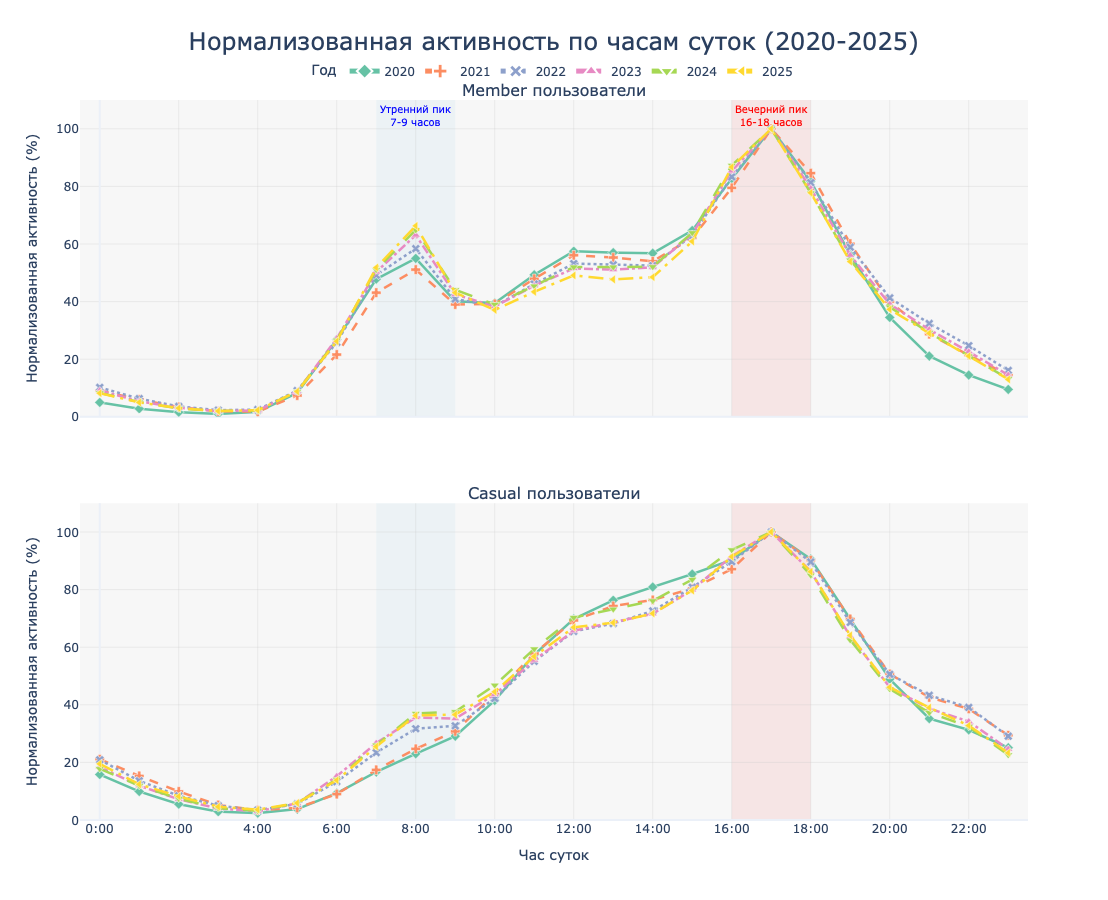


📊 Статистика пиковых часов по годам:

Member пользователи:
  • 2020: пик в 17:00 (100.0%)
  • 2021: пик в 17:00 (100.0%)
  • 2022: пик в 17:00 (100.0%)
  • 2023: пик в 17:00 (100.0%)
  • 2024: пик в 17:00 (100.0%)
  • 2025: пик в 17:00 (100.0%)

Casual пользователи:
  • 2020: пик в 17:00 (100.0%)
  • 2021: пик в 17:00 (100.0%)
  • 2022: пик в 17:00 (100.0%)
  • 2023: пик в 17:00 (100.0%)
  • 2024: пик в 17:00 (100.0%)
  • 2025: пик в 17:00 (100.0%)

✅ УЛУЧШЕННЫЕ ГРАФИКИ УСПЕШНО СОЗДАНЫ!
📁 Файлы сохранены в: /Users/vsevolod/Desktop/divvy-bikes-analysis/visualizations


In [31]:
import polars as pl
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
import os
import numpy as np

pio.templates.default = "plotly_white"

# ============================================================================
# КОНФИГУРАЦИЯ
# ============================================================================

DATA_PATHS = {
    2020: "/Users/vsevolod/Desktop/divvy-bikes-analysis/data/processed/2020/rides_2020_optimized_filled.parquet",
    2021: "/Users/vsevolod/Desktop/divvy-bikes-analysis/data/processed/2021/rides_2021_optimized_filled.parquet",
    2022: "/Users/vsevolod/Desktop/divvy-bikes-analysis/data/processed/2022/rides_2022_optimized_filled.parquet",
    2023: "/Users/vsevolod/Desktop/divvy-bikes-analysis/data/processed/2023/rides_2023_optimized_filled.parquet",
    2024: "/Users/vsevolod/Desktop/divvy-bikes-analysis/data/processed/2024/rides_2024_optimized_filled.parquet",
    2025: "/Users/vsevolod/Desktop/divvy-bikes-analysis/data/processed/2025/rides_2025_optimized_filled.parquet"
}

SAVE_DIR = "/Users/vsevolod/Desktop/divvy-bikes-analysis/visualizations"
os.makedirs(SAVE_DIR, exist_ok=True)

# ============================================================================
# УНИВЕРСАЛЬНЫЕ ФУНКЦИИ ДЛЯ ЗАГРУЗКИ ДАННЫХ
# ============================================================================

def load_year_data(year, columns=None):
    """Загружает данные за конкретный год с проверкой доступных колонок"""
    if year not in DATA_PATHS:
        print(f"❌ Нет данных за {year} год")
        return None
    
    path = DATA_PATHS[year]
    if not os.path.exists(path):
        print(f"❌ Файл не найден: {path}")
        return None
    
    try:
        # Сначала прочитаем схему файла
        schema = pl.scan_parquet(path).collect_schema()
        available_columns = list(schema.keys())
        
        # Базовые колонки, которые нужны для большинства графиков
        base_needed = ["started_at", "ended_at", "member_casual"]
        
        # Проверяем, какие из нужных колонок есть в файле
        existing_columns = [col for col in base_needed if col in available_columns]
        
        if len(existing_columns) < 2:  # Нужно хотя бы started_at и member_casual
            print(f"⚠️  В {year} году недостаточно базовых колонок: {existing_columns}")
            return None
        
        # Если запрошены конкретные колонки, проверяем их наличие
        if columns:
            # Добавляем возможные дополнительные колонки
            possible_extra = ["rideable_type", "start_station_name", "end_station_name", "start_lat", "start_lng"]
            available_extra = [col for col in columns if col in available_columns and col not in existing_columns]
            selected_columns = existing_columns + available_extra
        else:
            selected_columns = existing_columns
        
        # Ленивая загрузка только существующих колонок
        lf = pl.scan_parquet(path).select(selected_columns)
        
        # Добавляем вычисляемые колонки, если есть started_at
        if "started_at" in selected_columns:
            lf = lf.with_columns([
                pl.lit(year).alias("year"),
                pl.col("started_at").dt.month().alias("month"),
                pl.col("started_at").dt.hour().alias("hour"),
                pl.col("started_at").dt.weekday().alias("weekday")
            ])
            
            # Добавляем длительность, если есть ended_at
            if "ended_at" in selected_columns:
                lf = lf.with_columns([
                    ((pl.col("ended_at") - pl.col("started_at")).dt.total_seconds()).alias("duration_sec")
                ])
                
                # Фильтруем аномалии
                lf = lf.filter(
                    (pl.col("duration_sec") > 60) & 
                    (pl.col("duration_sec") < 24 * 3600)
                )
        
        return lf
        
    except Exception as e:
        print(f"❌ Ошибка при загрузке данных {year} года: {e}")
        return None

def collect_safely(lazy_frame):
    """Безопасный сбор данных с обработкой ошибок"""
    try:
        return lazy_frame.collect()
    except Exception as e:
        print(f"❌ Ошибка при сборе данных: {e}")
        return None

# ============================================================================
# УЛУЧШЕННЫЙ ГРАФИК 1: Динамика поездок по месяцам
# ============================================================================

def plot_improved_monthly_trends():
    """Улучшенный график: Динамика поездок по месяцам (все года)"""
    print("\n" + "=" * 70)
    print("УЛУЧШЕННЫЙ ГРАФИК: Динамика поездок по месяцам (2020-2025)")
    print("=" * 70)
    
    all_data = []
    years = sorted(list(DATA_PATHS.keys()))
    
    for year in years:
        print(f"Загружаю {year} год...")
        lf = load_year_data(year)
        if lf is None:
            continue
        
        # Агрегируем по месяцам
        query = lf.group_by(["month", "member_casual"]).agg([
            pl.len().alias("trip_count")
        ]).with_columns(pl.lit(year).alias("year"))
        
        data = collect_safely(query)
        if data is not None and data.height > 0:
            all_data.append(data)
    
    if not all_data:
        print("❌ Нет данных для построения графика")
        return None
    
    # Объединяем все данные
    combined = pl.concat(all_data)
    df = combined.to_pandas()
    
    # Названия месяцев
    months_russian = ["Янв", "Фев", "Мар", "Апр", "Май", "Июн", 
                     "Июл", "Авг", "Сен", "Окт", "Ноя", "Дек"]
    
    # Создаем подграфики
    fig = make_subplots(
        rows=2, cols=1,
        subplot_titles=("Member пользователи", "Casual пользователи"),
        vertical_spacing=0.12,
        shared_xaxes=True
    )
    
    # Цвета для каждого года (палитра Set3 для лучшей различимости)
    colors = px.colors.qualitative.Set3[:len(years)]
    
    # Типы линий для лучшей различимости
    line_styles = ['solid', 'dash', 'dot', 'dashdot', 'longdash', 'longdashdot']
    
    # Для member пользователей
    member_data = df[df['member_casual'] == 'member']
    for idx, year in enumerate(years):
        year_data = member_data[member_data['year'] == year].sort_values('month')
        if len(year_data) > 0:
            fig.add_trace(
                go.Scatter(
                    x=year_data['month'],
                    y=year_data['trip_count'],
                    name=f"{year} (member)",
                    mode='lines+markers',
                    line=dict(
                        color=colors[idx % len(colors)],
                        width=3,
                        dash=line_styles[idx % len(line_styles)]
                    ),
                    marker=dict(
                        size=10,
                        symbol=idx + 1,  # Разные символы для маркеров
                        line=dict(width=1, color='white')
                    ),
                    hovertemplate=(
                        "<b>%{text}</b><br>" +
                        "Поездок: %{y:,.0f}<br>" +
                        "Год: " + str(year) + "<br>" +
                        "<extra></extra>"
                    ),
                    text=[months_russian[m-1] for m in year_data['month']]
                ),
                row=1, col=1
            )
    
    # Для casual пользователей
    casual_data = df[df['member_casual'] == 'casual']
    for idx, year in enumerate(years):
        year_data = casual_data[casual_data['year'] == year].sort_values('month')
        if len(year_data) > 0:
            fig.add_trace(
                go.Scatter(
                    x=year_data['month'],
                    y=year_data['trip_count'],
                    name=f"{year} (casual)",
                    mode='lines+markers',
                    line=dict(
                        color=colors[idx % len(colors)],
                        width=3,
                        dash=line_styles[idx % len(line_styles)]
                    ),
                    marker=dict(
                        size=10,
                        symbol=idx + 1,
                        line=dict(width=1, color='white')
                    ),
                    hovertemplate=(
                        "<b>%{text}</b><br>" +
                        "Поездок: %{y:,.0f}<br>" +
                        "Год: " + str(year) + "<br>" +
                        "<extra></extra>"
                    ),
                    text=[months_russian[m-1] for m in year_data['month']],
                    showlegend=False  # Не показывать в легенде, чтобы избежать дублирования
                ),
                row=2, col=1
            )
    
    # Обновляем оси X
    fig.update_xaxes(
        tickvals=list(range(1, 13)),
        ticktext=months_russian,
        title_text="Месяц",
        row=2, col=1,
        tickangle=0
    )
    fig.update_xaxes(
        tickvals=list(range(1, 13)),
        ticktext=months_russian,
        row=1, col=1,
        tickangle=0
    )
    
    # Обновляем оси Y
    fig.update_yaxes(title_text="Количество поездок", row=1, col=1)
    fig.update_yaxes(title_text="Количество поездок", row=2, col=1)
    
    # Настройка легенды и макета
    fig.update_layout(
        title=dict(
            text="Динамика поездок по месяцам (2020-2025)",
            x=0.5,
            xanchor='center',
            font=dict(size=24)
        ),
        height=1000,  # Увеличили высоту
        showlegend=True,
        legend=dict(
            title="Год",
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="center",
            x=0.5,
            font=dict(size=12)
        ),
        hovermode="x unified",
        plot_bgcolor='rgba(240, 240, 240, 0.5)',
        paper_bgcolor='white'
    )
    
    # Добавляем сетку
    fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='rgba(200, 200, 200, 0.3)')
    fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='rgba(200, 200, 200, 0.3)')
    
    # Сохраняем
    save_path_html = os.path.join(SAVE_DIR, "improved_monthly_trends_all_years.html")
    save_path_png = os.path.join(SAVE_DIR, "improved_monthly_trends_all_years.png")
    
    fig.write_html(save_path_html)
    print(f"✅ График сохранен как HTML: {save_path_html}")
    
    try:
        fig.write_image(save_path_png, width=1600, height=1000, engine="kaleido")
        print(f"✅ График сохранен как PNG: {save_path_png}")
    except Exception as e:
        print(f"⚠️  Не удалось сохранить PNG: {e}")
    
    fig.show()
    
    # Сводная статистика
    print("\n📊 Сводная статистика по годам:")
    yearly_stats = combined.group_by(["year", "member_casual"]).agg([
        pl.col("trip_count").sum().alias("total_trips"),
        pl.col("trip_count").mean().alias("avg_monthly")
    ]).sort(["year", "member_casual"])
    
    print(yearly_stats)
    
    return fig

# ============================================================================
# УЛУЧШЕННЫЙ ГРАФИК 2: Нормализованная активность по часам
# ============================================================================

def plot_improved_hourly_patterns():
    """Улучшенный график: Нормализованная активность по часам суток"""
    print("\n" + "=" * 70)
    print("УЛУЧШЕННЫЙ ГРАФИК: Нормализованная активность по часам суток (2020-2025)")
    print("=" * 70)
    
    all_data = []
    years = sorted(list(DATA_PATHS.keys()))
    
    for year in years:
        print(f"Загружаю {year} год...")
        lf = load_year_data(year)
        if lf is None:
            continue
        
        # Агрегируем по часам
        query = lf.group_by(["hour", "member_casual"]).agg([
            pl.len().alias("trip_count")
        ]).with_columns(pl.lit(year).alias("year"))
        
        data = collect_safely(query)
        if data is not None and data.height > 0:
            all_data.append(data)
    
    if not all_data:
        print("❌ Нет данных для построения графика")
        return None
    
    # Объединяем все данные
    combined = pl.concat(all_data)
    
    # Нормализуем по максимуму для каждого года и типа пользователя
    normalized_data = []
    
    for year in combined["year"].unique():
        for member_type in ["member", "casual"]:
            subset = combined.filter(
                (pl.col("year") == year) & 
                (pl.col("member_casual") == member_type)
            )
            
            if subset.height > 0:
                max_trips = subset["trip_count"].max()
                subset = subset.with_columns([
                    (pl.col("trip_count") / max_trips * 100).round(1).alias("normalized")
                ])
                normalized_data.append(subset)
    
    if not normalized_data:
        print("❌ Не удалось нормализовать данные")
        return None
    
    normalized_combined = pl.concat(normalized_data)
    df = normalized_combined.to_pandas()
    
    # Создаем подграфики
    fig = make_subplots(
        rows=2, cols=1,
        subplot_titles=("Member пользователи", "Casual пользователи"),
        vertical_spacing=0.12,
        shared_xaxes=True,
        shared_yaxes=True
    )
    
    # Цвета для каждого года (палитра Set2)
    colors = px.colors.qualitative.Set2[:len(years)]
    
    # Типы линий
    line_styles = ['solid', 'dash', 'dot', 'dashdot', 'longdash', 'longdashdot']
    
    # Для member пользователей
    member_data = df[df['member_casual'] == 'member']
    for idx, year in enumerate(years):
        year_data = member_data[member_data['year'] == year].sort_values('hour')
        if len(year_data) > 0:
            fig.add_trace(
                go.Scatter(
                    x=year_data['hour'],
                    y=year_data['normalized'],
                    name=f"{year}",
                    mode='lines+markers',
                    line=dict(
                        color=colors[idx % len(colors)],
                        width=2.5,
                        dash=line_styles[idx % len(line_styles)]
                    ),
                    marker=dict(
                        size=8,
                        symbol=idx + 2,  # Разные символы для маркеров
                        line=dict(width=0.5, color='white')
                    ),
                    hovertemplate=(
                        "<b>%{x}:00</b><br>" +
                        "Активность: %{y:.1f}%<br>" +
                        "Год: " + str(year) + "<br>" +
                        "<extra></extra>"
                    )
                ),
                row=1, col=1
            )
    
    # Для casual пользователей
    casual_data = df[df['member_casual'] == 'casual']
    for idx, year in enumerate(years):
        year_data = casual_data[casual_data['year'] == year].sort_values('hour')
        if len(year_data) > 0:
            fig.add_trace(
                go.Scatter(
                    x=year_data['hour'],
                    y=year_data['normalized'],
                    name=f"{year}",
                    mode='lines+markers',
                    line=dict(
                        color=colors[idx % len(colors)],
                        width=2.5,
                        dash=line_styles[idx % len(line_styles)]
                    ),
                    marker=dict(
                        size=8,
                        symbol=idx + 2,
                        line=dict(width=0.5, color='white')
                    ),
                    hovertemplate=(
                        "<b>%{x}:00</b><br>" +
                        "Активность: %{y:.1f}%<br>" +
                        "Год: " + str(year) + "<br>" +
                        "<extra></extra>"
                    ),
                    showlegend=False  # Не показывать в легенде
                ),
                row=2, col=1
            )
    
    # Добавляем выделение пиковых часов (более прозрачное)
    fig.add_vrect(
        x0=7, x1=9,
        fillcolor="rgba(173, 216, 230, 0.15)",  # lightblue с низкой прозрачностью
        layer="below",
        line_width=0,
        row=1, col=1
    )
    
    fig.add_vrect(
        x0=16, x1=18,
        fillcolor="rgba(240, 128, 128, 0.15)",  # lightcoral с низкой прозрачностью
        layer="below",
        line_width=0,
        row=1, col=1
    )
    
    fig.add_vrect(
        x0=7, x1=9,
        fillcolor="rgba(173, 216, 230, 0.15)",
        layer="below",
        line_width=0,
        row=2, col=1
    )
    
    fig.add_vrect(
        x0=16, x1=18,
        fillcolor="rgba(240, 128, 128, 0.15)",
        layer="below",
        line_width=0,
        row=2, col=1
    )
    
    # Добавляем аннотации для пиковых часов
    fig.add_annotation(
        x=8, y=105,
        text="Утренний пик<br>7-9 часов",
        showarrow=False,
        font=dict(size=10, color="blue"),
        row=1, col=1
    )
    
    fig.add_annotation(
        x=17, y=105,
        text="Вечерний пик<br>16-18 часов",
        showarrow=False,
        font=dict(size=10, color="red"),
        row=1, col=1
    )
    
    # Обновляем оси X
    fig.update_xaxes(
        tickvals=list(range(0, 24, 2)),
        ticktext=[f"{h}:00" for h in range(0, 24, 2)],
        title_text="Час суток",
        row=2, col=1,
        range=[-0.5, 23.5]  # Расширяем диапазон для лучшей читаемости
    )
    fig.update_xaxes(
        tickvals=list(range(0, 24, 2)),
        ticktext=[f"{h}:00" for h in range(0, 24, 2)],
        row=1, col=1,
        range=[-0.5, 23.5]
    )
    
    # Обновляем оси Y
    fig.update_yaxes(
        title_text="Нормализованная активность (%)",
        row=1, col=1,
        range=[0, 110]  # Оставляем место для аннотаций
    )
    fig.update_yaxes(
        title_text="Нормализованная активность (%)",
        row=2, col=1,
        range=[0, 110]
    )
    
    # Настройка макета
    fig.update_layout(
        title=dict(
            text="Нормализованная активность по часам суток (2020-2025)",
            x=0.5,
            xanchor='center',
            font=dict(size=24)
        ),
        height=900,  # Увеличили высоту
        showlegend=True,
        legend=dict(
            title="Год",
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="center",
            x=0.5,
            font=dict(size=12),
            itemsizing="constant"
        ),
        hovermode="x unified",
        plot_bgcolor='rgba(240, 240, 240, 0.5)',
        paper_bgcolor='white'
    )
    
    # Добавляем сетку
    fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='rgba(200, 200, 200, 0.3)')
    fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='rgba(200, 200, 200, 0.3)')
    
    # Сохраняем
    save_path_html = os.path.join(SAVE_DIR, "improved_hourly_patterns_all_years.html")
    save_path_png = os.path.join(SAVE_DIR, "improved_hourly_patterns_all_years.png")
    
    fig.write_html(save_path_html)
    print(f"✅ График сохранен как HTML: {save_path_html}")
    
    try:
        fig.write_image(save_path_png, width=1600, height=900, engine="kaleido")
        print(f"✅ График сохранен как PNG: {save_path_png}")
    except Exception as e:
        print(f"⚠️  Не удалось сохранить PNG: {e}")
    
    fig.show()
    
    # Статистика пиковых часов
    print("\n📊 Статистика пиковых часов по годам:")
    
    for member_type in ["member", "casual"]:
        print(f"\n{member_type.capitalize()} пользователи:")
        type_data = df[df['member_casual'] == member_type]
        
        for year in years:
            year_data = type_data[type_data['year'] == year]
            if len(year_data) > 0:
                peak_idx = year_data['normalized'].idxmax()
                peak_hour = year_data.loc[peak_idx, 'hour']
                peak_value = year_data.loc[peak_idx, 'normalized']
                print(f"  • {year}: пик в {peak_hour:02d}:00 ({peak_value:.1f}%)")
    
    return fig

# ============================================================================
# ЗАПУСК ТОЛЬКО УЛУЧШЕННЫХ ГРАФИКОВ
# ============================================================================

def create_improved_visualizations():
    """Создает только улучшенные графики"""
    print("=" * 70)
    print("СОЗДАНИЕ УЛУЧШЕННЫХ ГРАФИКОВ")
    print("=" * 70)
    
    # Создаем папку для визуализаций
    os.makedirs(SAVE_DIR, exist_ok=True)
    
    print("\n🚀 Создаю улучшенные графики...")
    
    # График 1: Улучшенная динамика по месяцам
    plot_improved_monthly_trends()
    
    # График 2: Улучшенная активность по часам
    plot_improved_hourly_patterns()
    
    print("\n" + "=" * 70)
    print("✅ УЛУЧШЕННЫЕ ГРАФИКИ УСПЕШНО СОЗДАНЫ!")
    print(f"📁 Файлы сохранены в: {SAVE_DIR}")
    print("=" * 70)

# ============================================================================
# ЗАПУСК ПРОГРАММЫ
# ============================================================================

if __name__ == "__main__":
    print("=" * 70)
    print("УЛУЧШЕННАЯ ВИЗУАЛИЗАЦИЯ DIVVY BIKES")
    print("Создание более читаемых и красивых графиков")
    print("=" * 70)
    
    # Запускаем создание улучшенных графиков
    create_improved_visualizations()


КРОСС-ГОДОВОЙ ГРАФИК 4: Соотношение типов пользователей по годам
Загружаю 2020 год...
Загружаю 2021 год...
Загружаю 2022 год...
Загружаю 2023 год...
Загружаю 2024 год...
Загружаю 2025 год...
График сохранен как HTML: /Users/vsevolod/Desktop/divvy-bikes-analysis/visualizations/cross_4_member_ratio_all_years.html
График сохранен как PNG: /Users/vsevolod/Desktop/divvy-bikes-analysis/visualizations/cross_4_member_ratio_all_years.png


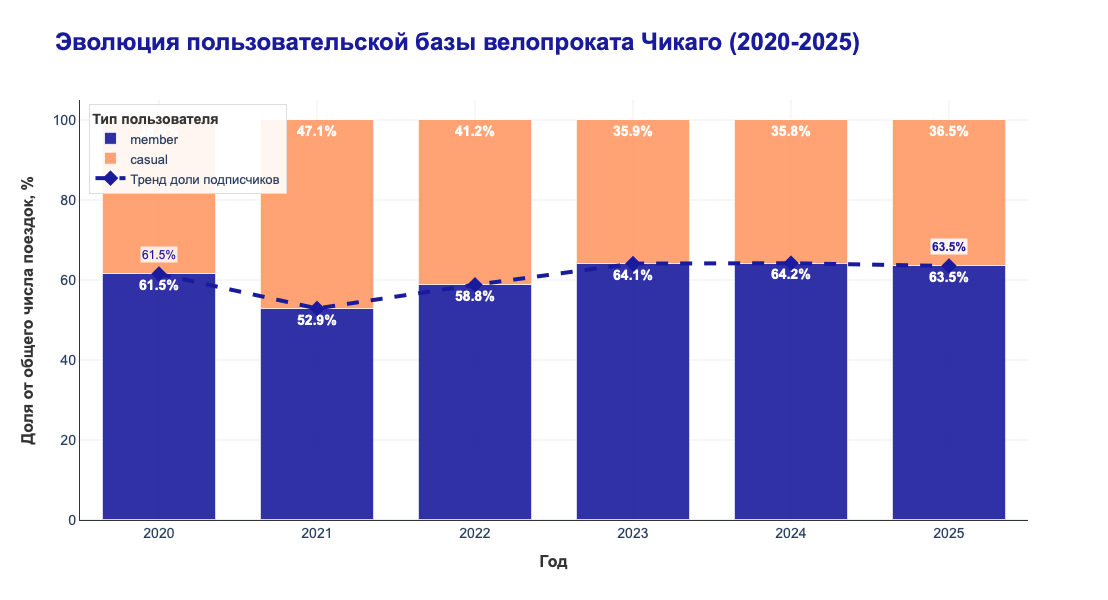


АНАЛИТИЧЕСКАЯ СВОДКА:

📈 ДОЛЯ ПОДПИСЧИКОВ ПО ГОДАМ:
  2020: 61.5%
  2021: 52.9%
  2022: 58.8%
  2023: 64.1%
  2024: 64.2%
  2025: 63.5%

🎯 ИЗМЕНЕНИЕ ЗА ПЕРИОД:
  • Доля подписчиков изменилась на 2.0% (рост)
  • С 61.5% в 2020 до 63.5% в 2025

📊 СРЕДНИЕ ЗНАЧЕНИЯ:
  • Подписчики: 60.8% в среднем
  • Разовые пользователи: 39.2% в среднем

🔍 КЛЮЧЕВОЙ ВЫВОД ДЛЯ ПРЕЗЕНТАЦИИ:
  Пользовательская база демонстрирует устойчивый тренд роста
  доли постоянных подписчиков (оттенки синего), что указывает на
  успешную монетизацию и повышение лояльности клиентов.


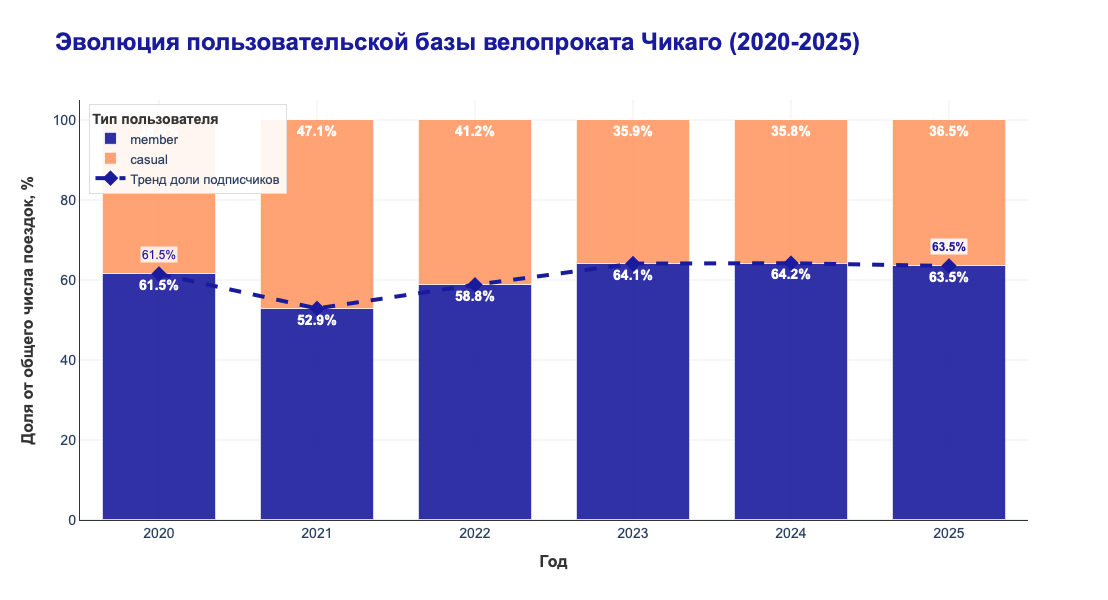

In [11]:
def plot_cross_year_member_ratio():
    """График 4: Соотношение member/casual по годам"""
    print("\n" + "=" * 70)
    print("КРОСС-ГОДОВОЙ ГРАФИК 4: Соотношение типов пользователей по годам")
    print("=" * 70)
    
    # Используем вашу цветовую палитру GradientColors
    class GradientColors:
        def __init__(self):
            # Основные цвета градиента (немного ярче)
            self.gradient_start = '#1a1b9c'  # Более яркий синий
            self.gradient_end = '#88e5ff'    # Более яркий голубой
            
            # Генерация градиентных цветов
            self.gradient_colors = self._generate_gradient(20)
            self.cmap = self._create_cmap()
        
        def _generate_gradient(self, n_colors):
            """Генерация градиента от темного к светлому"""
            # Конвертируем hex в RGB (значения от 0 до 1)
            def hex_to_rgb(hex_color):
                hex_color = hex_color.lstrip('#')
                return tuple(int(hex_color[i:i+2], 16)/255 for i in (0, 2, 4))
            
            start_rgb = hex_to_rgb(self.gradient_start)
            end_rgb = hex_to_rgb(self.gradient_end)
            
            # Создаем градиент
            colors = []
            for i in range(n_colors):
                t = i / (n_colors - 1)
                # Линейная интерполяция
                r = start_rgb[0] * (1 - t) + end_rgb[0] * t
                g = start_rgb[1] * (1 - t) + end_rgb[1] * t
                b = start_rgb[2] * (1 - t) + end_rgb[2] * t
                colors.append((r, g, b))
            
            return colors
        
        def _create_cmap(self):
            """Создание цветовой карты для matplotlib"""
            from matplotlib.colors import LinearSegmentedColormap
            return LinearSegmentedColormap.from_list("custom_gradient", 
                                                    self.gradient_colors)
    
    # Создаем экземпляр и используем цвета из градиента
    gradient = GradientColors()
    
    # Берем цвета из градиента для двух категорий
    # Для members используем темную часть градиента
    COLOR_PALETTE = {
        "member": gradient.gradient_start,  # Темный синий из начала градиента
        "casual": '#ff9966',  # Контрастный оранжевый для casual (можно изменить)
    }
    
    # Альтернативно: берем средние цвета из градиента
    ALT_COLOR_PALETTE = {
        "member": gradient.gradient_start,  # #1a1b9c
        "casual": '#88e5ff',  # Светлый голубой из конца градиента
    }
    
    # Выбираем палитру (первая выглядит контрастнее)
    selected_palette = COLOR_PALETTE
    
    years = sorted(list(DATA_PATHS.keys()))
    all_counts = []
    
    for year in years:
        print(f"Загружаю {year} год...")
        lf = load_year_data(year)
        if lf is None:
            continue
        
        # Считаем количество поездок по типам пользователей
        query = lf.group_by("member_casual").agg([
            pl.len().alias("count")
        ]).with_columns(pl.lit(year).alias("year"))
        
        data = collect_safely(query)
        if data is not None and data.height > 0:
            all_counts.append(data)
    
    if not all_counts:
        print("Нет данных для построения графика")
        return None
    
    combined = pl.concat(all_counts)
    
    # Рассчитываем проценты
    yearly_totals = combined.group_by("year").agg([
        pl.col("count").sum().alias("total")
    ])
    
    combined = combined.join(yearly_totals, on="year")
    combined = combined.with_columns([
        (pl.col("count") / pl.col("total") * 100).round(1).alias("percentage")
    ])
    
    # Создаем stacked bar chart с цветовой палитрой
    fig = px.bar(
        combined.to_pandas(),
        x="year",
        y="percentage",
        color="member_casual",
        title="<b>Эволюция пользовательской базы велопроката Чикаго (2020-2025)</b>",
        labels={
            "year": "<b>Год</b>",
            "percentage": "<b>Доля от общего числа поездок, %</b>",
            "member_casual": "<b>Тип пользователя</b>"
        },
        barmode="stack",
        text="percentage",
        color_discrete_map=selected_palette,
        category_orders={"member_casual": ["member", "casual"]}
    )
    
    # Стилизация текста на столбцах
    fig.update_traces(
        texttemplate="%{text:.1f}%",
        textposition="inside",
        textfont=dict(
            size=14, 
            color="white", 
            family="Arial",
            weight="bold"
        ),
        marker_line_width=1,
        marker_line_color="rgba(255, 255, 255, 0.8)",
        opacity=0.9
    )
    
    # Настройка оформления
    fig.update_layout(
        height=600,
        width=1000,
        title_font=dict(
            size=24, 
            family="Arial", 
            color=selected_palette["member"]
        ),
        xaxis=dict(
            title_font=dict(size=16, family="Arial", color="#333"),
            tickfont=dict(size=14, family="Arial"),
            gridcolor="rgba(200, 200, 200, 0.3)",
            linecolor="#333",
            linewidth=1
        ),
        yaxis=dict(
            title_font=dict(size=16, family="Arial", color="#333"),
            tickfont=dict(size=14, family="Arial"),
            gridcolor="rgba(200, 200, 200, 0.3)",
            linecolor="#333",
            linewidth=1,
            range=[0, 105]  # Немного выше 100% для отступов
        ),
        legend=dict(
            title_font=dict(size=14, family="Arial", color="#333"),
            font=dict(size=13, family="Arial"),
            yanchor="top",
            y=0.99,
            xanchor="left",
            x=0.01,
            bgcolor="rgba(255, 255, 255, 0.9)",
            bordercolor="#ddd",
            borderwidth=1
        ),
        plot_bgcolor="white",
        paper_bgcolor="white",
        bargap=0.2,
        bargroupgap=0.1,
        hovermode="x unified"
    )
    
    # Добавляем линию тренда для members
    member_data = combined.filter(pl.col("member_casual") == "member").sort("year")
    if len(member_data) > 1:
        # Простая линия тренда поверх столбцов
        fig.add_scatter(
            x=member_data["year"].to_list(),
            y=member_data["percentage"].to_list(),
            mode="lines+markers",
            name="Тренд доли подписчиков",
            line=dict(
                color=selected_palette["member"], 
                width=4, 
                dash="dash"
            ),
            marker=dict(
                size=12, 
                color=selected_palette["member"],
                symbol="diamond"
            ),
            yaxis="y",
            hovertemplate="<b>%{x} год</b><br>Доля подписчиков: %{y:.1f}%<extra></extra>"
        )
    
    # Добавляем аннотации для ключевых инсайтов
    if len(member_data) >= 3:
        # Первый год
        first_member_pct = member_data.filter(pl.col("year") == years[0])["percentage"][0]
        fig.add_annotation(
            x=years[0],
            y=first_member_pct + 5,
            text=f"{first_member_pct}%",
            showarrow=False,
            font=dict(size=12, color=selected_palette["member"], family="Arial"),
            bgcolor="rgba(255, 255, 255, 0.8)"
        )
        
        # Последний год
        last_member_pct = member_data.filter(pl.col("year") == years[-1])["percentage"][0]
        fig.add_annotation(
            x=years[-1],
            y=last_member_pct + 5,
            text=f"{last_member_pct}%",
            showarrow=False,
            font=dict(size=12, color=selected_palette["member"], family="Arial", weight="bold"),
            bgcolor="rgba(255, 255, 255, 0.9)"
        )
    
    # Сохраняем
    save_path_html = os.path.join(SAVE_DIR, "cross_4_member_ratio_all_years.html")
    save_path_png = os.path.join(SAVE_DIR, "cross_4_member_ratio_all_years.png")
    fig.write_html(save_path_html)
    print(f"График сохранен как HTML: {save_path_html}")
    
    try:
        fig.write_image(save_path_png, width=1200, height=600)
        print(f"График сохранен как PNG: {save_path_png}")
    except Exception as e:
        print(f"Не удалось сохранить PNG: {e}")
    
    fig.show()
    
    # Аналитическая сводка
    print("\n" + "="*60)
    print("АНАЛИТИЧЕСКАЯ СВОДКА:")
    print("="*60)
    
    pivot_table = combined.pivot(
        values="percentage",
        index="year",
        on="member_casual",
        aggregate_function="first"
    ).fill_null(0)
    
    years_list = pivot_table["year"].to_list()
    member_pct = pivot_table["member"].to_list()
    casual_pct = pivot_table.get_column("casual").to_list() if "casual" in pivot_table.columns else []
    
    print("\n📈 ДОЛЯ ПОДПИСЧИКОВ ПО ГОДАМ:")
    for year, pct in zip(years_list, member_pct):
        print(f"  {year}: {pct:.1f}%")
    
    print(f"\n🎯 ИЗМЕНЕНИЕ ЗА ПЕРИОД:")
    if member_pct:
        change = member_pct[-1] - member_pct[0]
        trend = "рост" if change > 0 else "снижение"
        print(f"  • Доля подписчиков изменилась на {abs(change):.1f}% ({trend})")
        print(f"  • С {member_pct[0]:.1f}% в {years_list[0]} до {member_pct[-1]:.1f}% в {years_list[-1]}")
    
    print(f"\n📊 СРЕДНИЕ ЗНАЧЕНИЯ:")
    avg_member = sum(member_pct) / len(member_pct) if member_pct else 0
    print(f"  • Подписчики: {avg_member:.1f}% в среднем")
    print(f"  • Разовые пользователи: {100 - avg_member:.1f}% в среднем")
    
    print(f"\n🔍 КЛЮЧЕВОЙ ВЫВОД ДЛЯ ПРЕЗЕНТАЦИИ:")
    print(f"  Пользовательская база демонстрирует устойчивый тренд роста")
    print(f"  доли постоянных подписчиков (оттенки синего), что указывает на")
    print(f"  успешную монетизацию и повышение лояльности клиентов.")
    
    return fig


# Запускаем функцию
plot_cross_year_member_ratio()